In [1]:
#Environment changes by only changing p and scrambling the x values 
#python code for the plot
from sys import stdout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl
import scipy as sp
from scipy.stats import multivariate_normal,percentileofscore
from scipy import stats
import math
import seaborn as sns
import pandas as pd
from IPython.display import clear_output
import sys
import matplotlib.colors as colors
import matplotlib.cm as cm
from IPython.core.display import display, HTML
import random
display(HTML("<style>.container { width:100% !important; }</style>"))
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from labellines import labelLine, labelLines
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
# mpl.style.use('fast')


ImportError: No module named pandas

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
#Returns an array with lognormal distribution curve
def lognormal(x,mean,std,dx):
    return dx/(x*np.sqrt(std*2*np.pi))*np.exp(-(np.log(x)-mean)**2/(2*std**2))

#Computes a gini coefficient
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

#Receives an array of desired growth rates, a domain X, and parameters l,p
#Returns an array of x values corresponding to desired growth rates
def genXs(Gs,X,l,p):
    #Computing the growth rates given the parameters and domain
    g=p*np.log(X*l)+(1-p)*np.log(l*(1-X)/(l-1))
    g_ind=np.argmax(g)
    #Computing the indices of where g(X)=G (lambda function gives us whichever value is closest
    xs=[np.where(g==min(g,key=lambda x:abs(x-G))) for G in Gs[:g_ind]]
    
    x=[X[xx][0] for xx in xs]
    
    return x

def genConditionalProbs(p_trans,order):
    p_fail=1-p_trans
    j=1
    xk_s = np.arange(order)
    return [stats.rv_discrete(name='signals'+str(j),\
            values=(xk_s,[(p_fail/(order-1))+(p_trans-p_fail/(order-1))*int(i==j) for i in range(order)]))\
            for j in range(order)]

def computeSignalMarginal(signal_conditional,x):
    order=len(x)
    return np.sum(rvToList(signal_conditional,x),axis=1)/order

def genSignalsSymbols(order,p_trans,pk_s=None):
    xk_s = np.arange(order)
    if pk_s is None:
        pk_s = [1/order for i in range(order)]
    
    signal_conditionals=[genConditionalProbs(p,order) for p in p_trans]
    signals=[computeSignalMarginal(sig_con,xk_s) for sig_con in signal_conditionals]
    received = stats.rv_discrete(name='received', values=([xk_s], [pk_s]))

    return received,signals,signal_conditionals,xk_s

def plotHist(signals,received,order):
    hist=pd.DataFrame({"Signal":signals,"Received":received})
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    g = sns.jointplot(data=hist,kind="hist",palette="inferno",marginal_kws=dict(bins=order),y="Signal",x="Received")
    g.fig.set_size_inches(5,5)
    g.ax_marg_x.set_xlim(0, order-1)
    g.ax_marg_y.set_ylim(0, order-1)
    plt.show()
    print(hist.groupby(['Signal','Received']).size().reset_index().rename(columns={0:'count'}))
    
def genChunks(t,switch_times):
    arr = [0]+switch_times+[t]
    return np.diff(arr)

def rvToList(rv,x):
    if str(type(rv))=="<class 'list'>":
        return np.array([rv_i.pmf(x) for rv_i in rv])
    else:
        return rv.pmf(x)
def jointPMF(sigs,recs,x,order):
    pdf = pd.DataFrame(data=rvToList(recs,x),columns=x,index=x)/order
    
def extractPMF(pmfs,order):
    probs=[pmf.pmf([i for i in range(order)]) for pmf in pmfs]
    return np.array(probs)

#Generate Individuals
def genAgents(N,Gs,p_init,order):
    X=np.linspace(.01,p_init,100000)
    L_matrix=np.full((order,order),1/(order**2))
    agents={}
    agentsID = [i for i in range(N)]
    X=genXs(Gs,X,order,p_init)
    for a,X_success in zip(agentsID,X):
        #Posterior, Learning rate, binomial param, learning matrix, and learning bool
        likelihood=[None for i in range(steps)]
        likelihood[0]=extractPMF(genConditionalProbs(X_success,order),order)
        r_pseudocount=np.divide(likelihood[0],np.amin(likelihood[0][0]))
        agents[a]={'p':likelihood,\
                   'h':r_pseudocount,\
                   'B':(order-1)*(X_success/(1-X_success)+1),\
                   'k':[K1 for i in range(steps)],\
                   'x':X_success,\
                   'g':[w],\
                   's_marg':np.sum(r_pseudocount,axis=1),\
                   'r_marg':np.sum(r_pseudocount,axis=1),\
                   'rs':[r_pseudocount]}
    return agents


def genJointGrowthResourceDistrib(corr,eta_bar,r_bar,sigma_eta,sigma_r,N):
    means = [eta_bar,r_bar]  
    stds = [sigma_eta, sigma_r]
    covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
            [stds[0]*stds[1]*corr,           stds[1]**2]] 
    m = np.random.multivariate_normal(means, covs, N).T
#     return np.exp(2*m[0]),np.exp(2*m[1])
    r_i=np.reshape(m[1],(N,1))
    return m[0],np.exp(r_i)

#Sample takes a tips PDF (recs) and conditional event pdf (sigs)    
def sample(recs,sigs,t,N,W,switch_times):
    chunks=genChunks(t,switch_times)
    outcomes=np.array([])
    for c,i in zip(chunks,range(len(chunks))):
        #Sample from the rs 
        received=np.sort(recs.rvs(size=N*c*W))
        signals=[]
        #Returns unique elements, and their counts
        unique_rec,rec_counts = np.unique(received,return_counts=True)
        for x,counts in zip(unique_rec,rec_counts):
            #Sample from the conditional distribution given the r counts
            new_sigs=(sigs[i][x].rvs(size=counts).tolist())
            signals+=new_sigs
#         plotHist(signals,received,len(unique_rec))
        #Combine rs and ss and shuffle 
        o_i=np.array([received,signals]).T
        np.random.shuffle(o_i)
        if not outcomes.any():
            outcomes=np.array([np.reshape(o_i,(N,c,W,2))])
        else:
            outcomes=np.append(outcomes,[np.reshape(o_i,(N,c,W,2))],axis=0)
    return np.concatenate([o for o in outcomes], axis=1)

def simulateGamble(N,order,steps,corr,W,p_success,typ,switch_times):
    resetNs(order)
    Gs,r_i=genJointGrowthResourceDistrib(corr,eta,r0,sig_e,sig_r,N)
    resources=np.concatenate((r_i,np.zeros(shape=(N,steps-1))),axis=1) #Resource array
    outcomesList=[]
    signal_probs=[]
    #Generate event and outcome sequence
    r,s,sgr,x=genSignalsSymbols(order,p_success)
    outcomes=sample(r,sgr,steps,N,W,switch_times)

    agents=genAgents(N,Gs,p_success[0],order)
    resources=simulateBetsWLearning(N,p_success,typ,resources,agents,order,outcomes,order,steps,switch_times)
    return resources,agents,[extractPMF(s,order) for s in sgr],signal_probs,Gs

def correlateResources(resources):
    init=[percentileofscore(resources.T[0],r) for r in resources.T[0]]
    fin =[percentileofscore(resources.T[-1],r) for r in resources.T[-1]]
    return np.corrcoef(init,fin)[0][1],init,fin

def makeBets(symbols,agents,order,t):
    bets=[[0 for i in range(values['g'][-1])] for values in agents.values()]
    for values,outcome_set,o in zip(agents.values(),symbols,range(N)):
        for i in range(values['g'][-1]):
            r=outcome_set[i]
            #a(s|r)=q(s|r)
            big_bet=values['p'][t-1][r][r]   
            small_bet=(1-big_bet)/(order-1)
            #CancellingBets
            bets[o][i]=([(int(i==r)*big_bet+int(i!=r)*small_bet) for i in range(order)])
    return bets

def simulateBetsWLearning(N,p,typ,resources,agents,order,outcomes,payouts,steps,switch_times):
    oL=np.transpose(outcomes,axes=(1,3,0,2))

    i=0
    
    def learnDirichletMultinom(Nsset,sset,rset,l,t,switch,p,indx):
        if learn:
            global N_S
            global N_R
            global N_SR
            for rs,ss,i,vals in zip(rset,sset,range(N),agents.values()):
                g=vals['g'][-1]
                wt=vals['k'][t]
        #         start=time.time()
                for r,s in zip(rs[:g],ss[:g]):
                    #s is the "category" |||| Python lists are row,column indexed
                    c=dt/wt
                    N_S[i][s]+=c
                    #r is the "word"
                    N_R[i][r]+=c

                    N_SR[i][s][r]+=c

            #UPDATING AGENT POSTERIORS
            for (a,data),n_si,n_sri,n_ri in zip(agents.items(),N_S,N_SR,N_R):
                update=np.divide(data['h']+n_sri,\
                                  n_ri+data['B'])*(1+n_si)
                #Learning
                agents[a]['p'][t]=np.divide(update,np.array([np.sum(update,axis=0)]).T)
        #No Learning
        else:
            for (a,data),n_si,n_sri,n_ri in zip(agents.items(),N_S,N_SR,N_R):
            
                agents[a]['p'][t]=agents[a]['p'][0]

        return agents

    for t in range(1,steps):
        if t in switch_times:
            i+=1
        r_temp=resources.T
        curr_s,curr_r=oL[t][0],oL[t][1]
        bets=makeBets(curr_r,agents,order,t)
        #gmeaning the set of outcomes the agent observes
        payout= [sp.stats.gmean([bet[s]*payouts for bet,s in zip(betSet,outs)]) \
                 for betSet,outs in zip (bets,curr_s)]
        #Basic Kelly Update
        resources.T[t]=resources.T[t-1]*payout
#         #Kelly update with added noise to reduce correlations
#         resources.T[t]=resources.T[t-1]*(payout*(1+np.random.normal(0,1/100,size=len(payout))))
        r=resources.T[t]
        
        if learn:
            agents=updateLearningRates(agents,typ,r,t,p[i])

        agents=learnDirichletMultinom(N,curr_s,curr_r,order,t,(t in switch_times),p,i)
#     for a in agents.values():
#         print(a['p'])
    return resources

def updateLearningRates(agents,typ,resources,t,p):
    if typ=="res":
        rmean=np.mean(resources)
        rmax=np.amax(resources)
        for (key,data),r in zip(agents.items(),resources):
#             Variable learning rate (max fixed)
            if ltype=="max":
                agents[key]['k'][t]=K1*np.log(np.e/2*(r+rmax)/r)            
#             Variable learning rate (mean fixed)
            elif ltype=="mean":
                agents[key]['k'][t]=K1*np.log(np.e/2*(r+rmean)/r)
#            Constant learning rate
            elif ltype=="const":
                agents[key]['k'][t]=(K1)
#     else:
#         k_arr=[]
#         for key,data in agents.items():
#             x=data['p'][t-1][0][0]
#             k_arr.append(x*(1-x)/np.absolute(p-x))
#         k_tot=np.sum(k_arr)

#         for key,data in agents.items():
#             agents[key]['k'].append(k_tot/(k_arr[key]*XI))
    return agents




def powerLawFit(t,x0,p,t0,a):
    return ((x0-p)*t0)/((a*t+t0))+p

def resetNs(order):
    global N_S
    N_S=[np.zeros(order) for i in range(N)]
    global N_R
    N_R=[np.zeros(order) for i in range(N)]
    global N_SR
    N_SR=[np.zeros((order,order)) for i in range(N)]   

N_S=[]
N_R=[]
N_SR=[]

In [68]:
def computeGrowthRateNoPlot(N,steps,resources,agents,l,pmf,p,signal_probs,switch_times):
    gammas,Gs,sigs=[],[],[]
    for res,(a,data),v in zip(resources,agents.items(),range(N)):
        gamma=(1/(steps))*np.log(res[-1]/res[0])
        gammas.append(gamma)
    ginis=[]
    for res in resources.T:
        ginis.append(gini(res))
    plt.show()
    
    return gammas,ginis

def procData(N,steps,resources,agents,l,pmf,p,signal_probs,switch_times):
    chunks=genChunks(steps,switch_times)
    f_i=1/l
    gammas,Gs,sigs=[],[],[]
    DKLs=[[] for i in range(N)]
    time_Gs=[[] for i in range(N)]
    time_Vols=[[] for i in range(N)]
    time_xs=[[] for i in range(N)]
    i=0
    a_s=[]
#     pp=[int(i<chunks[0])*p[0]+int(i>chunks[0])*p[1] for i in range(steps)]
    for t in range(steps): 
        if t in chunks:
            i+=1
        for a,v in zip(agents.values(),range(N)):
            
            #Computing DKL time series
            DKLs[v].append(np.sum(a['p'][t]*np.log(np.divide(a['p'][t],pmf[i]))))
            x=a['p'][t][0][0]
            #Computing growth rate and volatility time series 
            time_Gs[v].append(np.log(l)+p[i]*np.log(x)+(1-p[i])*np.log((1-x)/(l-1)))
#             time_Vols[v].append(np.log(x*(l-1)/(1-x))**2*p[i]*(1-p[i]))
            time_xs[v].append(x)
    ginis=[]
#     for res in resources.T:
#         ginis.append(gini(res))
    return time_Gs,time_xs,DKLs

def computeGrowthRates(N,steps,resources,agents,l,pmf,p,signal_probs,switch_times,time_Gs,time_xs,DKLs,learning):
    
    alph=.8
    chunks=genChunks(steps,switch_times)
    
    cmap=plt.get_cmap('inferno')
    rng=1.662*np.amax([p[0]-np.absolute(a["x"]) for a in agents.values()])
    x0=np.mean(time_xs,axis=0)[0]
    coercoef,init,fin=correlateResources(resources)
    x0s=np.transpose(time_xs)[0]
    B=(o-1)*(np.divide(x0s,(np.subtract(1,x0s)))+1)

    e=K1*np.mean(B)*o
    xt=1+(timedom/(e))
    gt=p[0]*timedom/(e)+xt
    x=(1+timedom/(e))
    
        #Taylor approximation of growth rate dynamics 
    xbart=(p[0]*timedom/e+x0)/(1+timedom/e)
    plt.plot(xbart)
    plt.show()
    varG=np.var(time_Gs,axis=0)
    varX=np.var(time_xs,axis=0)
    tau=timedom/(e*dt)
    pp=p[0]

    print("sigX:",varX[0])
    print("epsi:",e)
    print("x0  :",x0)
    
    lgt=np.log(gt)
    lxt=np.log(xt)

    if learning:
#         fig = plt.figure(figsize=(8, 6))
#         gs = GridSpec(nrows=2, ncols=3)

#         ax1 = fig.add_subplot(gs[:, :2])
#         ax2 = fig.add_subplot(gs[0, 2])
#         ax0 = fig.add_subplot(gs[1, 2])
        fig, (ax1) = plt.subplots(1, 1, figsize=[8,6])

        # Create inset of width 1.3 inches and height 0.9 inches
        # at the default upper right location
        ax2 = inset_axes(ax1, width=2.5, height=1.5)
        for res,(a,data),i,f,v in zip(resources,agents.items(),init,fin,range(N)):
            a=np.absolute(p[0]-data["x"])
#             ax1.plot(timedom,np.subtract(p[0],time_xs[v]),color='k',alpha=alph/2,linestyle='--')
            ax1.plot(timedom,np.subtract(p[0],time_xs[v]),color=(a/rng,(a/rng),(a/rng)),alpha=alph)
        ax1.plot(timedom,np.subtract(p[0],np.mean(time_xs,axis=0)),color="blue",linewidth=3,label="Population mean")
        ax1.plot(timedom,p[0]-xbart,color='red',linestyle='--',linewidth=3,label="Theoretical Mean")
        ax1.legend(prop={'size': 14},loc='upper left')
#         ax1.plot(timedom*dt,(p[0]-time_xs[100][0])/xt,color='k')
        ax1.set_ylabel(r'$\Delta_{p,x}$',fontsize=22)
        ax1.set_xlabel(r'$t$',fontsize=22)

        ax1.set_ylim(top=.240,bottom=-.025)

        ax2.set_ylabel(r"$\log\sigma_x^2$",fontsize=22)
        ax2.set_xlabel(r"$\log\sigma_x^2$",fontsize=22)

        ax2.plot(lxt, np.log(varX),color='#004D80',linewidth=3)
        ax2.plot(lxt, np.log(varX[0])-2*lxt,color='k',linewidth=3,linestyle='dashed')
#         ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) # 

        ax2.set_xlabel(r"$\log (1+\lambda)$",fontsize=22)
#         ax0.set_ylabel(r"$\log\sigma_\gamma^2$",fontsize=22)
#         ax0.plot(lgt, 2*np.log(np.std(time_Gs,axis=0)),color='#004D80',linewidth=3)   
#         ax0.plot(lgt,-2*lgt-7.45,color='k',linewidth='3',linestyle='dashed')
#         sig_g=(np.divide(p[0],xbart)-np.divide(1-p[0],1-xbart))*varX\
#                 +(np.divide(p[0],xbart**2)-np.divide(1-p[0],(1-xbart)**2))*varX**2
#         print(np.log(sig_g))
#         ax0.plot(lgt,np.log(sig_g),color='k',linewidth='3',linestyle='dashed')

#         ax0.yaxis.set_label_position("right")
#         ax0.tick_params(labelsize=18)
#         ax0.yaxis.tick_right()

#         ax0.set_ylim(top=-7.2,bottom=-10.8)
        
#         ax0.set_xlim(right=1.15)
        ax2.set_xlim(right=1.15)
        
        ax2.tick_params(labelsize=18)
        ax1.tick_params(labelsize=18)
        
        
#         ax2.yaxis.set_label_position("right")
#         ax2.yaxis.tick_right()
        
        plt.tight_layout()
        
        plt.savefig("learn.pdf")
        plt.show()

    else:
        p=p[0]
        x0s=np.transpose(time_xs)[0]
        G0s=p*np.log(x0s)+(1-p)*np.log((1-x0s)/(l-1))+np.log(l)
        std0s=np.sqrt(p*(1-p)/w)*np.log((l-1)*x0s/(1-x0s))
        G0=np.mean(G0s)
        std0=np.mean(std0s)
        print("Thry volatility contribut: ", np.mean(std0s)**2/2)
        print("Thry population volatility contribut: ", 1/N*np.mean(std0s)**2)
        print("Thry contribution of population var: ",np.std(G0s)*np.std(np.transpose(resources)[0])*corr)
        print("Thry Mean Growth:", np.mean(G0s)+np.mean(std0s**2)/2+1/N*np.mean(std0s)**2+np.std(G0s)*np.std(np.transpose(resources)[0])*corr)
        resCum=np.sum(resources,axis=0)
        print("")
        print("Expr Mean Growth:",1/timedom[-1]*np.log(resCum[-1]/resCum[0]))

        start_time=10
        fig, ax1 = plt.subplots(figsize=(7.5,5))
        mean=[]
        tdom=np.linspace(10,steps,steps-11)
        for res,G in zip(resources,G0s):
            y=np.absolute([(G-(1/(tt)*np.log(res[i]/res[0])))/G for tt,i in zip(tdom,range(int(steps)))])
            plt.plot(np.log(tdom[:3]),np.log(y[:3]),color='k',alpha=.25)
            mean.append(y)
#         plt.hlines(np.log(.15),xmin=np.log(10),xmax=np.log(steps),alpha=.9,linewidth=2,color="blue")
        plt.plot(np.log(tdom)[:3],np.log(np.mean(mean,axis=0))[:3],color='maroon',linewidth=3,alpha=.9)
#         plt.ylim(bottom=-4,top=.25)
#         plt.ylim(bottom=-4)
        plt.ylabel(r"$\log\Delta_G$",fontsize=20)
        plt.xlabel(r"$\log t$",fontsize=20)
#         plt.text(2.4,-2.2, r'$\Delta_G=.15$',fontsize=14,color='b')
        plt.tick_params(labelsize=14)
        plt.tight_layout()
        plt.savefig("kellygrowth1.pdf")
        
        plt.show()
             
        mean=[]
        fig, ax1 = plt.subplots(figsize=(7.5,5))
        for res in resources:
#             res = np.average(res.reshape(-1, w), axis=1)
            plt.plot(timedom,res,color='k',alpha=.25)
            mean.append(res)
        G0=G0+np.mean(std0s**2)/2
        print(G0,std0)
        y=np.exp(G0*timedom)
        ym=np.exp(G0*timedom-1.96*std0*np.sqrt(timedom))
        yp=np.exp(G0*timedom+1.96*std0*np.sqrt(timedom))
        plt.plot(timedom,y,color='r')
        plt.plot(timedom,yp,color='b') 
        plt.plot(timedom,ym,color='b') 
        plt.plot(timedom,np.mean(mean,axis=0),color='orange',linewidth=3,alpha=.9)
        plt.ylabel(r"$r(t)$",fontsize=20)
        plt.xlabel(r"$t$",fontsize=20)
        plt.tick_params(labelsize=14)
        
        #inset
        fin_res=np.transpose(resources)[-1]
        ax2 = plt.axes([0,0,1,1])
        ip = InsetPosition(ax1, iplistR)
        ax2.set_axes_locator(ip)
        ax2.set_xlabel(r"$r$",fontsize=16)
        ax2.set_ylabel(r'$P(r)$',fontsize=16)

        n,bins,patch=ax2.hist(fin_res,bins=30,density=True)
        dx=250
        x=np.linspace(6.5,23,dx)
        ax2.plot(x, lognormal(x,G0*timedom[-1],std0*np.sqrt(timedom[-1]/w),3))
#         ax1.grid()
#         ax2.grid()
        plt.tight_layout()
        plt.savefig("kellyresources1.pdf")  
        
def calcGamma(resources,steps):
    bunch=10
    res_step_n = np.split(resources,int(steps/bunch))
    gamma_time_n=[(bunch/steps)*np.log(r[-1]/r[0])for r in res_step_n]
    return gamma_time_n

def computeResTrajs(N,steps,res,resNL,resHOMO):

    fig = plt.figure(figsize=(8, 6))

    
    
    gs = GridSpec(nrows=2, ncols=3)

    ax0 = fig.add_subplot(gs[:, :2])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, 2])
    
    mv=  np.mean(np.log(res),axis=0)
    mnl= np.mean(np.log(resNL),axis=0)
    mh=  np.mean(np.log(resHOMO),axis=0)    
        
    rv=  np.std(np.log(res),axis=0)
    rnl= np.std(np.log(resNL),axis=0)
    rh=  np.std(np.log(resHOMO),axis=0)
    
    ax0.plot(timedom,mnl,color='k',alpha=1,label="Heterogeneous",linewidth=2)
    ax0.plot(timedom,mh,color='maroon',alpha=1,label="Homogeneous",linewidth=2)
    ax0.plot(timedom,mv,color='#004D80',alpha=1,label="Hetero Learning",linewidth=2)

    ax0.plot(timedom,mnl-rnl*.95,color='k',alpha=.25)
    ax0.plot(timedom,mh-rh*.95,color='maroon',alpha=.25)
    ax0.plot(timedom,mv-rv*.95,color='#004D80',alpha=.25)
    
    ax0.plot(timedom, mnl+rnl*.95,color='k',alpha=.25)
    ax0.plot(timedom, mh+rh*.95,color='maroon',alpha=.25)
    ax0.plot(timedom, mv+rv*.95,color='#004D80',alpha=.25)
    
    ax0.fill_between(timedom,mnl-rnl*.95, mnl+rnl*.95,alpha=.25,color='k')
    ax0.fill_between(timedom,mh-rh*.95, mh+rh*.95,alpha=.5,color='maroon')
    ax0.fill_between(timedom,mv-rv*.95, mv+rv*.95,alpha=.25,color='#004D80')

    ax0.set_ylim(bottom=0)
    ax0.set_ylabel(r'$\ln(r)$',fontsize=22)
    ax0.set_xlabel(r'$t$',fontsize=22)

    ax0.tick_params(labelsize=18)
    ax0.legend(prop={'size': 14})

    ax4.plot(rv/mv,color='#004D80',linewidth=3)
    ax4.plot(rnl/mnl,color='k',linewidth=3)
    ax4.plot(rh/mh,color='maroon',linewidth=3)
    ax4.set_ylim(bottom=0,top=10)
    
    ax3.plot(sp.special.erf(rv),color='#004D80',linewidth=3)
    ax3.plot(sp.special.erf(rnl),color='k',linewidth=3)
    ax3.plot(sp.special.erf(rh),color='maroon',linewidth=3)

    ax3.set_ylim(bottom=-0.1)
    ax4.set_ylim(bottom=-0.1,top=.7)
    
    ax3.set_ylabel(r'$G_{ini}$',fontsize=22)
    ax4.set_ylabel(r'$c_v$',fontsize=22)
    ax4.set_xlabel(r'$t$',fontsize=22)
    

    ax3.tick_params(labelsize=18)
    ax4.tick_params(labelsize=18)
    
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    ax4.yaxis.tick_right()
    ax3.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) # 


#     a0.set_aspect('equal')
#     a1.set_aspect('equal')
#     a2.set_aspect('equal')
#     a3.set_aspect('equal')
#     a4.set_aspect('equal')
    
#     plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.savefig("4pt2.pdf")
    plt.show()

    

In [6]:
sig_e=eta*.341*2
sig_r=.341*r0
learn=True
ltype="const"
resourcesLearn,agents,PMFs,signal_probs,Gs=simulateGamble(N,o,steps,corr,W,p_success,typ,switch_times)
iplistR=[0.13,0.45,0.5,0.5]

learn=False
resourcesNoLearn,agents,PMFs,signal_probs,Gs=simulateGamble(N,o,steps,corr,W,p_success,typ,switch_times)

sig_e=.0000000001
sig_r=.0000000001
resourcesHomo,agents,PMFs,signal_probs,Gs=simulateGamble(N,o,steps,corr,W,p_success,typ,switch_times)

NameError: name 'eta' is not defined

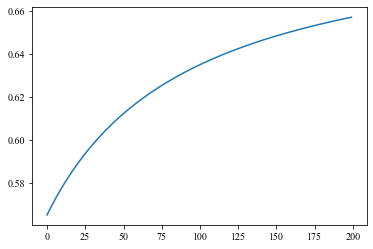

sigX: 0.002849027021518231
epsi: 93.57018676668275
x0  : 0.5651919581195811


/var/folders/f3/7npqvhls75s3wz_ddb_zvd7w0000gr/T/ipykernel_40615/2191482842.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


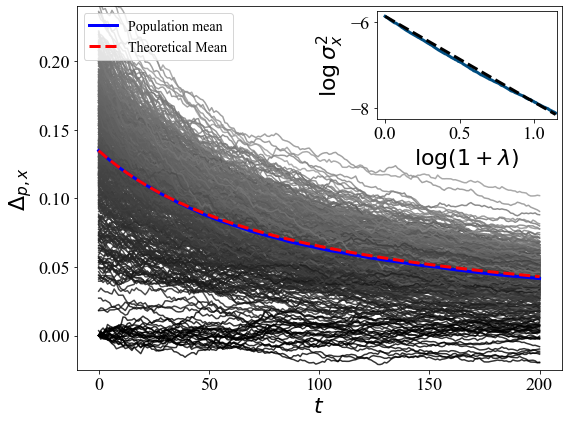

In [69]:
ltype="const"
#Constant learning
_=computeGrowthRates(N,steps,resources250Reg,agents,o,PMFs,p_success,signal_probs,switch_times,Gs250Reg,xs250Reg,DKLs250Reg,1)

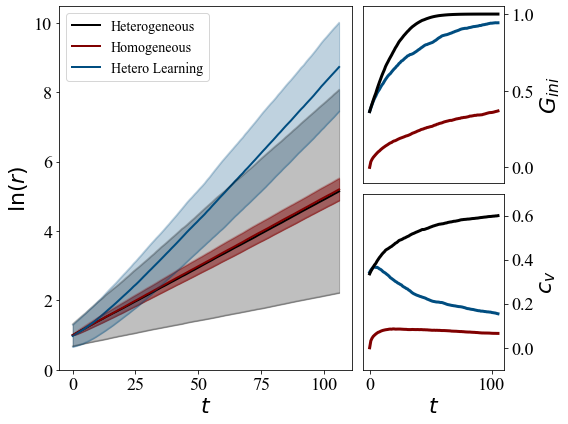

In [366]:
ltype="const"
#Constant learning
_=computeResTrajs(N,steps,resourcesLearn,resourcesNoLearn,resourcesHomo)

In [7]:
#This results show that gamma doesnt change the average Kelly growth rate
#Population
N=500


runtime=200
w=10
dt=1/w
steps=int(runtime)
timedom=np.linspace(0,runtime,steps)
switch_times=[int(steps/2)]

#Educational resources
XI=5*N
#K constant (Hyperprior magnitude)
K1=20
#Temporal density 
W=w+1
#Hyperprior magnitude noise
NOISE_MAG=0
p=.7
p_success=[p,p]


o=2


eta=.04
r0=1
sig_e=eta*.341*2
sig_r=.341*r0
# sig_e=.03*.341
# sig_r=.341*r0


typ="res"
corr=.7

learn=True
ltype="const"

Plotting the performance of the Kelly betting model compared to GBM expectation

Generates data for one slice of the $\rho$, $I_m$ spectrum

In [7]:
domainl=11
domain=np.linspace(-1,1,domainl)
def genSliceData(trials):
    resources=np.zeros((trials,domainl,N,steps),dtype=float)
    ags=np.zeros((trials,domainl,N,steps),dtype=float)
    for t in range(trials):
        for corr,i in zip(domain,range(domainl)):
            res,ag,_,_,_=simulateGamble(N,o,runtime,corr,W,p_success,typ,switch_times)
            print(corr)
            co,_,_=correlateResources(res)
            print(co)
            ag1=[a['p'] for a in ag.values()]
            resources[t][i][:]=res
            ags[t][i][:]=np.transpose(ag1,(3,2,0,1))[0,0]
    return resources,ags

def sliceData(args):
    reCorr=np.zeros((trials,domainl),dtype=float)
    var=np.zeros((trials,domainl),dtype=float)
    resources,ags_set=args[0],args[1]
    for t in range(trials):
        for res,ags,i in zip(resources[t],ags_set[t],range(len(resources[t]))):
            co,_,_=correlateResources(res)
            reCorr[t][i]=co
            gs=np.log(o)+p*np.log(ags)+(1-p)*np.log((np.divide(np.subtract(1,ags),o-1)))
            var[t][i]=np.var(gs,axis=0)[-1]
#             perc=np.divide(np.transpose(np.log(res))[0],np.log(np.amax(np.transpose(res)[0])))
#             clr=[(0,0,1-p) for p in perc]
#             for r,c in zip(res,clr):
#                 plt.plot(np.log(r),alpha=.75,color=c)
#             plt.show()
#             for g,c in zip((gs),clr):
#                 plt.plot(g,alpha=.75,color=c)
#             plt.show()
    return reCorr,var,resources

In [987]:
trials=2
ltype="const"
a=sliceData(genSliceData(trials))
reCorrStat,varStat,ResStat=a[0],a[1],a[2]

KeyboardInterrupt: 

In [ ]:
ltype="mean"
a=sliceData(genSliceData(trials))
reCorrDyn,varDyn,ResDyn=a[0],a[1],a[2]

In [8]:
MeanReCorrStat =np.mean(reCorrStat,axis=0)
VarReCorrStat  =np.std(reCorrStat,axis=0)
MeanReCorrDyn  =np.mean(reCorrDyn,axis=0)
VarReCorrDyn   =np.std(reCorrDyn,axis=0)

meanResDyn=np.transpose(np.sum(ResDyn,axis=2),(2,0,1))
gamma=1/runtime*np.log(np.divide(meanResDyn[-1],meanResDyn[0]))
meanMeanResDyn =np.mean(gamma,axis=0)
varMeanResDyn  =np.std(gamma,axis=0)

meanResStat=np.transpose(np.mean(ResStat,axis=2),(2,0,1))
gamma=1/runtime*np.log(np.divide(meanResStat[-1],meanResStat[0]))
meanMeanResStat=np.mean(gamma,axis=0)
varMeanResStat =np.std(gamma,axis=0)

MeanVarStat    =np.mean(np.divide(varStat,meanMeanResStat),axis=0)
VarVarStat     =np.std(np.divide(varStat,meanMeanResStat),axis=0)
MeanVarDyn     =np.mean(np.divide(varDyn,meanMeanResDyn),axis=0)
VarVarDyn      =np.std(np.divide(varDyn,meanMeanResDyn),axis=0)


cM="maroon"
cN='#004D80'


fig, (ax1,ax2,ax3) = plt.subplots(3,figsize=(6,6))

ax1.set_ylim(top=1.3,bottom=-.01)
ax1.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) # 
ax1.set_ylabel(r'$I_m$',fontsize=24)

mIS=np.subtract(1,MeanReCorrStat);mDS=np.subtract(1,MeanReCorrDyn)
ax1.errorbar(domain, mIS, yerr=VarReCorrStat/2,label="Static",  linewidth=2,elinewidth=2,color=cM)
ax1.fill_between(domain, mIS-VarReCorrStat/2, mIS+VarReCorrStat/2,alpha=.25,color=cM)
ax1.errorbar(domain, mDS,  yerr=VarReCorrDyn/2,  label="Dynamic",linewidth=2,elinewidth=2,color=cN)
ax1.fill_between(domain, mDS-VarReCorrDyn/2, mDS+VarReCorrDyn/2,alpha=.25,color=cN)
ax1.grid()
# ax2 = plt.axes([0,0,1,1])
# iplistx=[0.47,0.55,0.5,0.4]
# ip = InsetPosition(ax1, iplistx)
# ax2.set_axes_locator(ip)
# ax2.set_xlabel(r'$\rho$',fontsize=14)
ax2.set_ylabel(r'$\sigma_\gamma/\gamma$',fontsize=22)

ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax2.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) # 
ax2.grid()
plt.tick_params(labelsize=10)

ax2.errorbar(domain, MeanVarStat, yerr=VarVarStat/2,label="Static",  linewidth=2,elinewidth=2,color=cM)
ax2.fill_between(domain, MeanVarStat-VarVarStat/2, MeanVarStat+VarVarStat/2,alpha=.25,color=cM)
ax2.errorbar(domain, MeanVarDyn,  yerr=VarVarDyn/2,  label="Dynamic",linewidth=2,elinewidth=2,color=cN)
ax2.fill_between(domain, MeanVarDyn-VarVarDyn/2, MeanVarDyn+VarVarDyn/2,alpha=.25,color=cN)

ax3.errorbar(domain,meanMeanResStat,yerr=varMeanResStat/2, label="Static",linewidth=2,color=cM,elinewidth=2.5)
ax3.fill_between(domain, meanMeanResStat-varMeanResStat/2, meanMeanResStat+varMeanResStat/2,alpha=.25,color=cM)
ax3.errorbar(domain,meanMeanResDyn,yerr=varMeanResDyn/2, label="Dynamic",linewidth=2,color=cN,elinewidth=2.5)
ax3.fill_between(domain, meanMeanResDyn-varMeanResDyn/2, meanMeanResDyn+varMeanResDyn/2,alpha=.25,color=cN)

ax2.set_ylim(bottom=-.0001,top=.001)

ax3.set_ylim(bottom=.06,top=.079)
ax1.legend(prop={'size': 14})
ax3.set_xlabel(r'$\rho$',fontsize=24)
ax3.set_ylabel(r'$\gamma$',fontsize=24)
ax3.tick_params(labelsize=14)

plt.tight_layout()
plt.grid()
plt.savefig("Slices2.pdf")


NameError: name 'reCorrStat' is not defined

sigX: 0.002849027021518231
epsi: 93.57018676668275
x0  : 0.5651919581195811
Thry volatility contribut:  0.0007432019035453556
Thry population volatility contribut:  2.972807614181422e-06
Thry contribution of population var:  0.019938593798813506
Thry Mean Growth: 0.05960212724522449

Expr Mean Growth: 0.0808661833290659


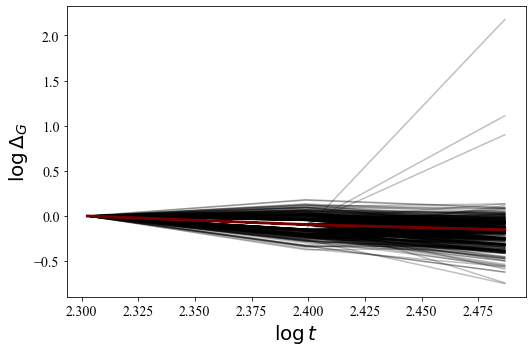

0.039660560638796805 0.038553907805703835


/var/folders/f3/7npqvhls75s3wz_ddb_zvd7w0000gr/T/ipykernel_40615/3567715754.py:200: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


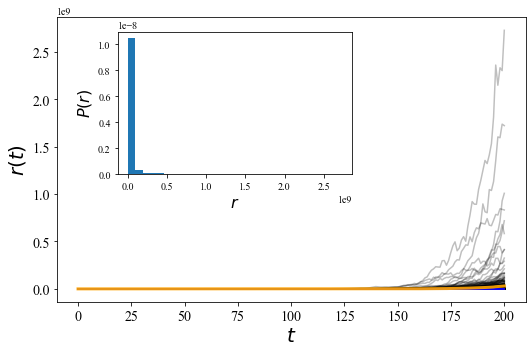

In [9]:
learn=True
ltype="const"
resources250Reg,agents,PMFs,signal_probs,Gs=simulateGamble(N,o,steps,corr,W,p_success,typ,switch_times)
Gs250Reg,xs250Reg,DKLs250Reg=procData(N,steps,resources250Reg,agents,o,PMFs,p_success,signal_probs,switch_times)
iplistR=[0.13,0.45,0.5,0.5]
_=computeGrowthRates(N,steps,resources250Reg,agents,o,PMFs,p_success,signal_probs,switch_times,Gs250Reg,xs250Reg,DKLs250Reg,0)

sigX: 0.0
epsi: 21.82364572012204
x0  : 0.5417814178141781
Thry volatility contribut:  0.00011785919645284033
Thry population volatility contribut:  9.428735716227227e-07
Thry contribution of population var:  0.0
Thry Mean Growth: 0.030118443183509872

Expr Mean Growth: 0.06860203190921028


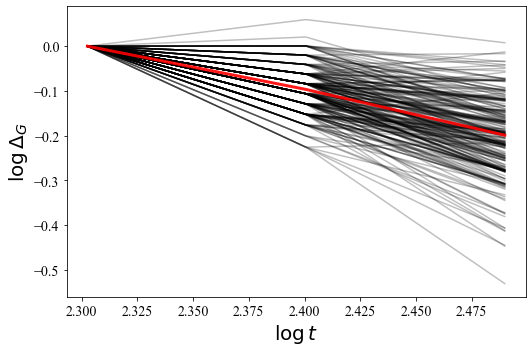

[ 0.          1.01265823  2.02531646  3.03797468  4.05063291  5.06329114
  6.07594937  7.08860759  8.10126582  9.11392405 10.12658228 11.13924051
 12.15189873 13.16455696 14.17721519 15.18987342 16.20253165 17.21518987
 18.2278481  19.24050633 20.25316456 21.26582278 22.27848101 23.29113924
 24.30379747 25.3164557  26.32911392 27.34177215 28.35443038 29.36708861
 30.37974684 31.39240506 32.40506329 33.41772152 34.43037975 35.44303797
 36.4556962  37.46835443 38.48101266 39.49367089 40.50632911 41.51898734
 42.53164557 43.5443038  44.55696203 45.56962025 46.58227848 47.59493671
 48.60759494 49.62025316 50.63291139 51.64556962 52.65822785 53.67088608
 54.6835443  55.69620253 56.70886076 57.72151899 58.73417722 59.74683544
 60.75949367 61.7721519  62.78481013 63.79746835 64.81012658 65.82278481
 66.83544304 67.84810127 68.86075949 69.87341772 70.88607595 71.89873418
 72.91139241 73.92405063 74.93670886 75.94936709 76.96202532 77.97468354
 78.98734177 80.        ]
0.03011750030993825 0.015

/var/folders/f3/7npqvhls75s3wz_ddb_zvd7w0000gr/T/ipykernel_92990/1777358357.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


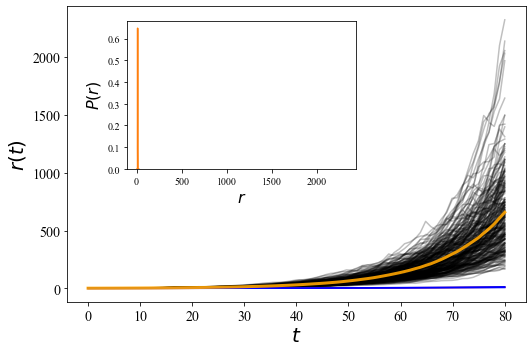

In [407]:
iplistR=[0.13,0.45,0.5,0.5]
_=computeGrowthRates(N,steps,resources250Reg,agents,o,PMFs,p_success,signal_probs,switch_times,Gs250Reg,xs250Reg,DKLs250Reg,0)

NameError: name 'resources250Reg' is not defined

sigX: 0.0002449072027152275
epsi: 87.35737265276555
x0  : 0.5415691716917168


ValueError: x and y must have same first dimension, but have shapes (200,) and (80,)

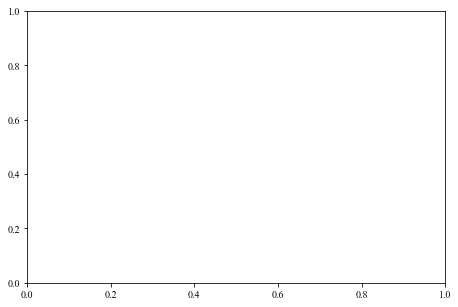

In [714]:
#Non co\nstant learning
iplistx=[0.47,0.48,0.5,0.5]
iplistG=[0.47,0.14,0.5,0.5]
_=computeGrowthRates(N,steps,resources250Reg,agents,o,PMFs,p_success,signal_probs,switch_times,Gs250Reg,xs250Reg,DKLs250Reg,1)

In [715]:
runtime=350
g_init=10
dt=1/g_init
steps=int(runtime)
timedom=np.linspace(0,steps-1,steps)
switch_times=[int(steps/2)]
K=g_init+1

corr=.7
stest=200
K1=10
N=500
eta=.04
sig_e=.016
p_success=[.7,.7]
o=2
resources250Reg,agents,PMFs,signal_probs,Gs=simulateGamble(N,o,steps,corr,K,p_success,typ,switch_times)
Gs250Reg,xs250Reg,DKLs250Reg=procData(N,steps,resources250Reg,agents,o,PMFs,p_success,signal_probs,switch_times)

sigX: 1.342296134040128e-29
epsi: 321.57328085204904
x0  : 0.6890288902889065


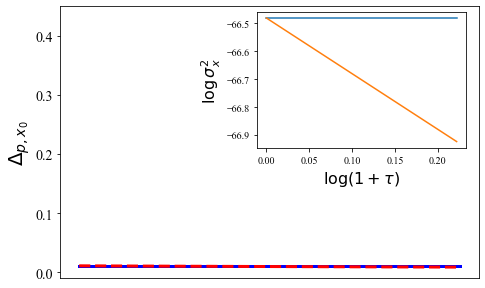

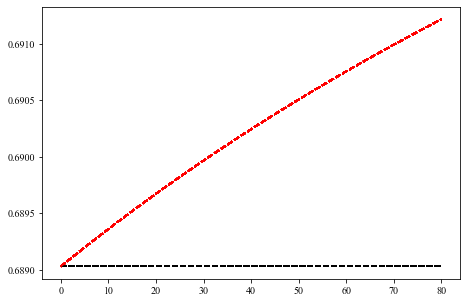

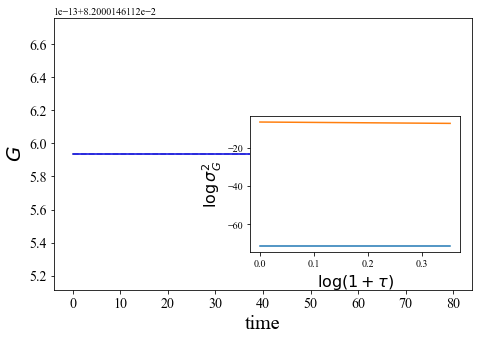

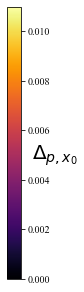

In [869]:
#Non constant learning
iplistx=[0.47,0.48,0.5,0.5]
iplistG=[0.47,0.14,0.5,0.5]
_=computeGrowthRates(N,steps,resources250Reg,agents,o,PMFs,p_success,signal_probs,switch_times,Gs250Reg,xs250Reg,DKLs250Reg,1)

sigX: 0.0009673774211734161
epsi: 45.80716999111337
x0  : 0.5609829712297123


/var/folders/f3/7npqvhls75s3wz_ddb_zvd7w0000gr/T/ipykernel_65770/1374437545.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


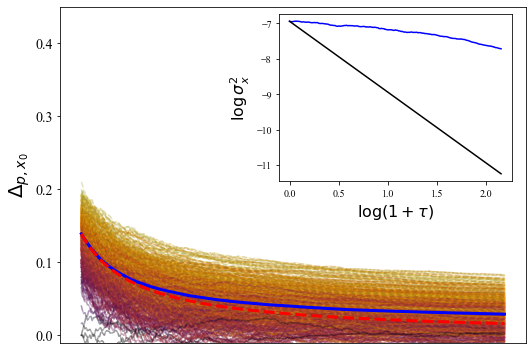

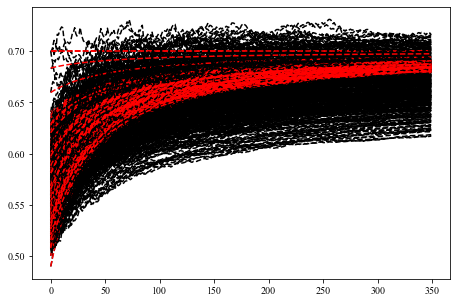

/var/folders/f3/7npqvhls75s3wz_ddb_zvd7w0000gr/T/ipykernel_65770/1374437545.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


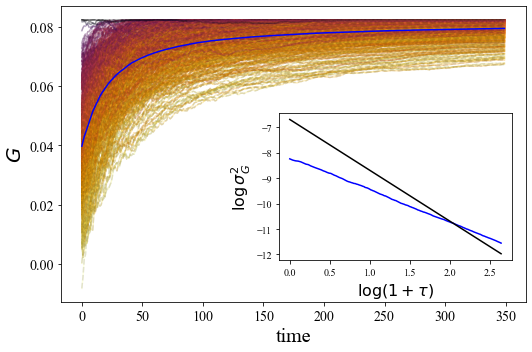

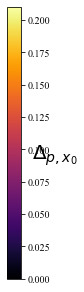

In [67]:
def plotHeatMap(x,y,data,xlabel,ylabel,legendlabel,title,zmin=None,zmax=None):
    fig = plt.gcf()
    fig.set_size_inches(6,5)
#     plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(axis='y',which='both',left=False,right=False,labelbottom=False,labelleft=False) # labels along the bottom edge are off

    plt.xlabel(xlabel,fontsize=20)
#     plt.ylabel(ylabel,fontsize=20)
    plt.tick_params(labelsize=14)
    x,y=np.meshgrid(cols,rows)
    cp=plt.contourf(x,y,data,9,cmap="viridis")
    cmap=plt.get_cmap("viridis")
    scalmap = plt.cm.ScalarMappable(cmap=cmap)
    plt.vlines(x=20,ymin=-1,ymax=1,color="white",linewidth=2)
    if zmax:
        plt.clim(zmin,zmax) 
        scalmap.set_array([zmin,zmax])
    else:
        scalmap.set_array([np.amin(data),np.amax(data)])
#     cbax = fig.add_axes(rect=[.8, 0, 0.18, 1]) 
#     cbax.set_axis_off()
#     cbar = fig.colorbar(scalmap,ax=cbax,shrink=5)
       
#     cbar.ax.set_title(legendlabel,fontsize=18)
#     cbar.ax.tick_params(labelsize=14) 
    cb=fig.colorbar(cp) # Add a colorbar to a plot
    cb.ax.set_title(legendlabel,fontsize=14)
    plt.text(25,.75, r'$k=k^\star$',fontsize=18,color='w')
    plt.text(60,-.85, r'Dynamical $\tau$',fontsize=18,color='k')


    fig.savefig(title,bbox_inches='tight')
    
    plt.show()
    
def growthMean(res_CorrVariance):
    growthMean=[]
    for resRow in np.sum(res_CorrVariance,axis=2):
        growthMean.append([])
        for pop in resRow:
            growthMean[-1].append(1/timedom[-1]*np.log(pop[-1]/pop[0]))
    return growthMean

In [14]:
N=1000
corr_p2000=[]
corr_r2000=[]
eta=.04
sig_e=.015
for K_1 in np.linspace(1,100,25):
    corr_p.append([])
    corr_r.append([])
    for s_e in np.linspace(.002,.05,25):
        global K1
        K1=K_1
        global sig_e
        sig_e=s_e
        global corr
        
        #Progressive spectrumm
        corr=-.7
        res,ag,pmf,sig=simulateGamble(N,o,steps,corr,K,p_success,typ,switch_times)
        co,i,f=correlateResources(res)
        corr_p[-1].append(co)
        
        #Regressive spectrum
        corr=.7
        res,ag,pmf,sig=simulateGamble(N,o,steps,corr,K,p_success,typ,switch_times)
        co,i,f=correlateResources(res)
        corr_r[-1].append(co)

NameError: name 'K_1' is not defined

Correlation Data for progressive (p) and regressive (r) societies: K0 row major, sigma_gamma column major 
N=500
t=200
dt=.333
eta=.03
r0=2
sig_r=.341*r0

ση=.03
Ι think we are looking at too wide of a growth rate variance range. At this high of a variance, big part of population starts out with very negative growth rates, which is a bit unrealistic. 

First, I will try reducing the growth rate variance, raising the average growth rate slightly (ση=.04). To show the desired effect, I should also run this simulation for ρ,K0 to show that as learning is introduced, we see a trend towards higher mobility and higher average growth rates. 

# this clearly didn't work, so now i will scan values of K0 to see if a parameter value exists

In [479]:
N=1000
corr_CorrVariance=[]
res_CorrVariance=[]
eta=.03
sig_e=.015
r0=2
sig_r=.341*r0
runtime=200
g_init=5
dt=1/g_init
steps=int(runtime)
timedom=np.linspace(0,runtime,steps)
switch_times=[int(steps/2)]
K=g_init+1

resolution=50

for corr_i,k in zip(np.linspace(-1,1,resolution),range(resolution)):
    corr_CorrVariance.append([])
    res_CorrVariance.append([])
    for K_1,j in zip(np.linspace(1,100,resolution),range(resolution)):
        sys.stdout.write('\r')
        sys.stdout.write(str((k*resolution+j)/resolution**2))
        sys.stdout.flush()
        global K1
        K1=K_1
        global corr
        corr=corr_i

        res,ag,pmf,sig,g0=simulateGamble(N,o,steps,corr,K,p_success,typ,switch_times)
        co,i,f=correlateResources(res)
        corr_CorrVariance[-1].append(co)
        res_CorrVariance[-1].append(res)

0.9996

In [9]:
resolution=50

In [480]:
gMean=growthMean(res_CorrVariance)

It seems that the progressive population is only both mobile and has competitive growth rate if inference rate is pretty high (K_0 is low). With a higher learning rate, the progessive society becomes more socially mobile. For intermediate K_0 values, a progressive society is both more mobile and economically competitive. As learning rate goes to zero, we mimic a society where growth rates are fixed, and we expect the diference in aggregate growth rates to resemble that from the first paper. 

I took a lot of data before now, but the code had bugs so it was no good


CONSTANT LEARNING RATE

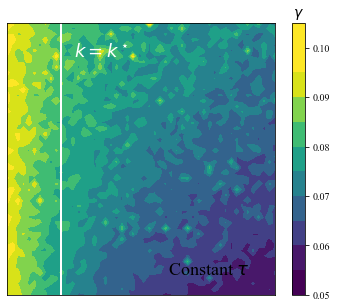

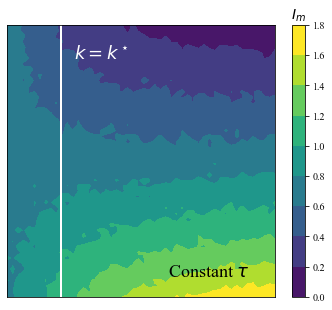

In [65]:
N=1000
eta=.03
sig_e=.015
r0=2
sig_r=.341*r0
runtime=200
g_init=5
resolution=50
growth_CorrVariance1000_inset=[[0.09483110300966578, 0.09158503085104128, 0.0896938664410582, 0.08588543384184454, 0.08525269616047045, 0.08086182023129675, 0.07740247489346379, 0.07869461826794162, 0.0750855350174973, 0.07391847600198402, 0.07220673970965147, 0.07014271661152668, 0.06872564481331705, 0.06805836072240064, 0.06804515149435279, 0.06692692913155104, 0.06617646130030852, 0.06534981240270789, 0.06373297565552519, 0.06272515844253397, 0.0637462903995789, 0.06284121842648502, 0.06219782042807844, 0.06105944396308608, 0.060636359830096395, 0.059418152537178325, 0.05935731539555067, 0.05979583086749564, 0.05736877657803763, 0.060753622521937965, 0.05928698677212018, 0.05847249212505281, 0.058452057324549125, 0.05729089820664184, 0.05779724789251333, 0.05557423012170614, 0.05666650654541074, 0.06207123050786707, 0.05551835491264717, 0.055683057634082864, 0.057285853990178846, 0.053697855750757216, 0.05552727900827053, 0.0552123845548736, 0.05392655449520478, 0.05387706471305097, 0.052317680723518833, 0.06074366629583411, 0.05471766871729897, 0.05237433579900148], [0.0936172193937837, 0.09354808147015028, 0.08931038434656287, 0.0847112494989082, 0.08303561467520307, 0.07896030519189848, 0.07795660771685685, 0.07851238146313728, 0.07669106955231009, 0.07500190719115747, 0.07255905324512414, 0.07443733120869941, 0.07145932297027165, 0.06787888892813902, 0.07070462331114465, 0.06771966499919924, 0.0659654612643348, 0.06576712008412655, 0.06570173656099534, 0.06454419486035644, 0.06270847181084055, 0.06169346186886254, 0.0643174955932016, 0.061028702511830374, 0.062252615051762064, 0.06018409595457192, 0.05987965669187463, 0.05873569025903037, 0.059129880354072226, 0.05991313466042658, 0.05870937954061975, 0.058102909256148416, 0.05860901226960019, 0.05739865220109727, 0.06028254803676394, 0.06086045030760137, 0.05572230714500125, 0.05719381373470845, 0.05658387553208894, 0.05818394328100217, 0.05570095515084592, 0.055392335108844386, 0.0552175523934768, 0.05422814941312514, 0.054103978317474495, 0.05588584262640519, 0.055455464953900746, 0.05397891368037487, 0.05343041320716807, 0.05436905135327483], [0.09494075231326107, 0.08981378073751255, 0.08866898817122969, 0.08579515398798955, 0.08292492118596063, 0.08361264029250713, 0.0802243542242178, 0.07800055863061284, 0.07696145703492314, 0.07311770519739053, 0.07248350377934762, 0.07236792189406872, 0.07179842120308863, 0.06928780258341537, 0.06886199417252793, 0.0666105214587662, 0.0662812281583625, 0.06485731202764526, 0.0650275809900599, 0.06541970270932185, 0.0643869891409588, 0.06296350822032512, 0.06351915589145318, 0.06166961542099943, 0.06087538171153988, 0.06385972895657326, 0.061864629966850375, 0.061856388342810376, 0.059559227005110335, 0.05905419041878457, 0.05836928168900938, 0.06030958211520957, 0.05658307061204817, 0.058166097646481604, 0.05664582650412519, 0.058159278178925744, 0.05902965514662153, 0.05755479723531854, 0.06156905336467221, 0.05715843200055707, 0.05790700380037287, 0.05728003069553083, 0.05497803092475427, 0.054281630631699065, 0.05356154256216744, 0.055105736104893555, 0.05605122173084839, 0.05560293918058117, 0.05462894570252289, 0.05596987441427534], [0.10180572966249518, 0.09299796673499197, 0.08909374394777592, 0.08547854819227711, 0.08305007861490576, 0.0817910926404014, 0.0819243231912558, 0.07839044301074727, 0.07637946750247462, 0.07435647037992665, 0.07309375136897645, 0.07364938469974049, 0.07232790770268606, 0.06941904896389076, 0.06810611693736596, 0.07026547567144237, 0.0658749890897501, 0.06489751049776041, 0.06488640057599712, 0.06384289536029314, 0.06277147269258576, 0.062327568803756124, 0.06143415009620684, 0.06277298470408829, 0.06256227756785734, 0.061558607301267186, 0.05885247871047744, 0.06799907926958876, 0.05962743491935402, 0.059954189949539764, 0.05810294291478983, 0.06013138530099624, 0.05845783904448287, 0.05661445483820104, 0.05575383903079653, 0.06027773795891348, 0.05749021625961904, 0.056697707235817046, 0.05625761948825649, 0.054798081147023024, 0.05875407595167513, 0.05947004957837897, 0.05537517286141106, 0.055678239031774414, 0.056081062414623864, 0.05596023467926654, 0.05465360328718688, 0.05436383056654228, 0.05346192981038425, 0.05386708012307543], [0.09473533959053416, 0.0894725905830018, 0.08903241300515502, 0.08563675993532213, 0.08363994050194754, 0.0825606467262782, 0.07963829575185917, 0.07738491546399016, 0.07647111208795819, 0.07439099838959191, 0.07371288821955482, 0.07127946758221994, 0.07021821420192492, 0.07137311085581571, 0.0677634062899944, 0.07038520187131332, 0.06739045737716896, 0.0653640446471289, 0.06497209003025195, 0.06601123761551062, 0.06392751534977695, 0.06368836780867977, 0.06234499728072047, 0.06608138048973329, 0.061032456429818, 0.060633368703678275, 0.06146692490203801, 0.059181003885286146, 0.059418236717098206, 0.061538202636087655, 0.05876481504152744, 0.05830928284461539, 0.05787153954818697, 0.06066795023862895, 0.05711165686100095, 0.057947755270828884, 0.0610559158772473, 0.06024632848193871, 0.05498334205291852, 0.05589778651200894, 0.05664284506432394, 0.056299248822003045, 0.0633289047212044, 0.06061398328082151, 0.05550260131336644, 0.05567226404033004, 0.055869120993345234, 0.05412518945420835, 0.05341702511637384, 0.05689574149509507], [0.09493329405240061, 0.09014478402616216, 0.08873134255420909, 0.08617813013388653, 0.08343766174798578, 0.08043564202261154, 0.08090414089824194, 0.07991842292682996, 0.07565647115464189, 0.07545988196983318, 0.07247947136765347, 0.07346348401961114, 0.07082583265667754, 0.06924477677239024, 0.06861739913220966, 0.06707715669379255, 0.06942825024227295, 0.06548220453302203, 0.06710192660956059, 0.06493339900110943, 0.0655198296778482, 0.06262635949887443, 0.06299339622197263, 0.06816980839302801, 0.06296648027597233, 0.06324262416083848, 0.06142281955547448, 0.05950912819523427, 0.0671221360554468, 0.05886415944234038, 0.05894656200040465, 0.0595509235550378, 0.05994588372452122, 0.05827537961347613, 0.05702555455100752, 0.0562580910436569, 0.05802643324301852, 0.05789308185106963, 0.05636915924155344, 0.05748083430899501, 0.05527895708633779, 0.05847433166854013, 0.054437727547930005, 0.056507336541379766, 0.05617161902979385, 0.05539588083057439, 0.057185470935417315, 0.055288838116844985, 0.057466115988734356, 0.05437112249036884], [0.09499062795982624, 0.09624498629031511, 0.08978354526028959, 0.08869620084641891, 0.08173527222941354, 0.08189554814214446, 0.07900752541502105, 0.07993663076865165, 0.07557827909952412, 0.07636230533382805, 0.07426885907876596, 0.07030493366024232, 0.0725365920445854, 0.06837969187182012, 0.06847932435505447, 0.06780603463595697, 0.07208137173714954, 0.06676457354402873, 0.07150716330770637, 0.06419780984497322, 0.06506276248941503, 0.06249186826694819, 0.06194439804183748, 0.06510419629445229, 0.06046288664971941, 0.059764110957518345, 0.0604401604857698, 0.061275708141560435, 0.06156008705388139, 0.06023538189221264, 0.06060843551062842, 0.05882880702627616, 0.05956102682838471, 0.05900888187740219, 0.057810164294429, 0.058712322693740555, 0.05634727677279673, 0.05579272398740571, 0.05653495782130604, 0.0570300862605882, 0.05479586434153228, 0.05587296290901415, 0.056670541811260494, 0.056122392126043516, 0.05601913733287854, 0.05417771578723476, 0.055592246894462426, 0.05582006219862633, 0.056673656294949554, 0.05878854205759323], [0.09339688658141344, 0.09316493364058173, 0.08923614017978793, 0.08749596100501185, 0.08512306786098595, 0.08054896317464341, 0.0773646942463809, 0.07671793061868834, 0.07658660094128426, 0.07482848091735611, 0.0734855873353694, 0.07213658407688438, 0.0705415129139529, 0.0703225341821778, 0.06731630046288195, 0.06736253730844383, 0.0672066947087784, 0.06764634383749937, 0.06571568581476675, 0.06424295456692934, 0.06563149220650642, 0.06389986262718701, 0.06293422946202443, 0.062081721553073094, 0.061449383405454125, 0.060184812626984475, 0.061132302773930204, 0.06118348228918935, 0.05959866240049468, 0.05851460588621423, 0.058817681706912706, 0.059685119718565466, 0.058998326912426194, 0.05737693902766752, 0.062240203254187505, 0.060726943543843816, 0.05851456851657148, 0.057300439644016155, 0.057312715220625976, 0.058045229078393254, 0.05714414618073417, 0.057727451430227956, 0.06287172797990011, 0.056451585867480246, 0.056552105855460166, 0.05681580029185944, 0.05704809851269345, 0.055344805752614815, 0.0570361789234493, 0.0727750455979078], [0.10132093074120338, 0.09205784058376734, 0.09182227341833349, 0.08524149863707109, 0.08432012389719576, 0.07978331708856787, 0.08103305741229684, 0.07840385825978329, 0.07637523958169651, 0.07535206610416577, 0.0731301559575921, 0.07239970002886674, 0.07027219302154193, 0.07656957625569658, 0.07252451620337096, 0.06849559882540451, 0.06613120758803874, 0.0643223623796316, 0.06543368558261042, 0.06388627618137332, 0.06417542548206394, 0.07452441761747053, 0.06368610296772319, 0.06485954748481733, 0.06066996829281471, 0.06184577057450765, 0.059888588693917645, 0.060675232024029385, 0.05967895760632054, 0.06260057126606064, 0.06232975903758359, 0.0585158096010114, 0.06362041553500179, 0.061254351575971845, 0.05748581964906135, 0.05840211602658506, 0.05763028396697284, 0.05726182063385169, 0.05855917300234457, 0.05674168414153925, 0.05593407496124849, 0.05647942845515151, 0.0559575062875296, 0.05757486975570877, 0.05550800383338064, 0.06266241240491159, 0.05592981846229192, 0.055695404353509836, 0.05873508725882507, 0.055466076130125413], [0.09536706193292752, 0.09309554166108436, 0.08798169883588589, 0.08453402502653794, 0.08215578430505273, 0.08636728359873773, 0.07993126074862408, 0.07707647989796777, 0.07588415970635153, 0.07373571093932933, 0.07413927353141272, 0.07400089599980433, 0.07140750364441799, 0.06981644895202888, 0.07040849890609294, 0.06825138210849749, 0.06658519134554518, 0.07010023857362238, 0.06398865686283191, 0.07150512315867723, 0.06704489001241785, 0.06446705807317471, 0.06456547766595708, 0.06338785090331425, 0.06349687242657594, 0.06102241071036169, 0.061098497672479296, 0.06537430559801732, 0.06517716638794516, 0.06143825648138048, 0.06118985149314086, 0.0596030999148617, 0.05910044703054848, 0.05724990159490529, 0.05874394735669863, 0.05795205695970841, 0.06075631608655731, 0.062370220797799324, 0.06021249990936197, 0.058149305180051146, 0.056749674838036016, 0.058165965449711976, 0.05769931565008838, 0.056534935365772185, 0.05765128477918672, 0.058201166355135635, 0.05775938568737674, 0.05607363011292177, 0.060349421409377685, 0.05630564451960738], [0.09665781770889707, 0.09301617828014956, 0.08856182093859159, 0.08640894044298661, 0.08281637986253766, 0.08277123072716534, 0.0802156499251917, 0.0787436749694001, 0.07688828584460305, 0.07378637979470913, 0.0742347686625381, 0.07192956524918549, 0.07143404642420584, 0.07014010184958734, 0.07029897364217745, 0.06860751959249975, 0.06710255092219607, 0.06817387676945359, 0.06683210722847022, 0.06564219045182801, 0.06462493909091566, 0.06574449749575258, 0.06276422862340529, 0.06394996732925019, 0.06424499752471809, 0.06399676720293054, 0.06211252704124563, 0.06020512517830357, 0.06161950286252287, 0.06095214938855233, 0.059513188995813655, 0.0608333806620901, 0.06204681216067221, 0.059633925982461713, 0.058211088101082366, 0.05784736516867208, 0.058017096872572636, 0.059768691267096684, 0.065714215782331, 0.058171342283821065, 0.05883046290329102, 0.05687212185394401, 0.05777994388165391, 0.05676015302683956, 0.05749353811377244, 0.057784015426431905, 0.05812814007026943, 0.05703908620813974, 0.054371409001977455, 0.05414529725451765], [0.09347101977076601, 0.0915497525648331, 0.08756701168049533, 0.08732323547860249, 0.08388007343649095, 0.08176608562087352, 0.0797064602145232, 0.07758543922096203, 0.075674625070157, 0.07742007274964169, 0.07473217966899613, 0.07231861870714824, 0.07185099381610595, 0.07041489426682557, 0.07084461350575272, 0.06920834251663056, 0.06620204867597422, 0.06860365939619548, 0.06660415989120134, 0.06773867044501844, 0.06509189278237314, 0.06447971851385977, 0.06486591005921309, 0.06592850024625932, 0.06257853577256636, 0.06620713102578782, 0.06246005084878494, 0.05989084361182214, 0.06274480132814088, 0.06318728110119914, 0.061144299687923724, 0.059010317928001, 0.061443204862829476, 0.05934192793344903, 0.057359800933468846, 0.059081977598093714, 0.05929490970473637, 0.05761079863683676, 0.06010680704292682, 0.05661847102339909, 0.056512340381974155, 0.059870230103457905, 0.05797054257385492, 0.057421130690902614, 0.057973765777930016, 0.057500935826944766, 0.05651739164949841, 0.058680792100788075, 0.0603106388152825, 0.055240445739778286], [0.09479995793295576, 0.09423491461620677, 0.08842923760432822, 0.0856177373652824, 0.08282379631722601, 0.08170020003463872, 0.08482559167253005, 0.07980541004174707, 0.07670477828515694, 0.07433226477673324, 0.07559492027584101, 0.0729133825241035, 0.0712016007733613, 0.06931704449945815, 0.07021525309839632, 0.06836004300364214, 0.06780572329182809, 0.07061345440675579, 0.06692942036372648, 0.06455200633114425, 0.06432297621495024, 0.06298006601834771, 0.06391622769238223, 0.06258271541545889, 0.06225671923593198, 0.06466003918342468, 0.06131300994146936, 0.060002580803919535, 0.0672888207254771, 0.06390250250156926, 0.06112108236969152, 0.06289543693223026, 0.06389409169782467, 0.06119790779720404, 0.060233591726709224, 0.0580916298393812, 0.06445279945491762, 0.05820731545138287, 0.06782003838501717, 0.06781552651682034, 0.058373608729467355, 0.05658042056787473, 0.056966587785953066, 0.058020145436537794, 0.06071356931916348, 0.054917521130177185, 0.05725844930980415, 0.05928919095414527, 0.05882505329167256, 0.05662757185730832], [0.09324288128052526, 0.09181605978445494, 0.08857399270323268, 0.08605690664302972, 0.08424688483254066, 0.08177952092695766, 0.07973967013495681, 0.07826159494025037, 0.07890553281613139, 0.07684948714704516, 0.07390513912945264, 0.07530029958668126, 0.07125018483854204, 0.06811365627914016, 0.07000068432474091, 0.06889327174842037, 0.06643230280127183, 0.06577552282476416, 0.06604566123488594, 0.06620734341296224, 0.06841934190709463, 0.0634634712568405, 0.06418323831004624, 0.06243448732311021, 0.06444923595939936, 0.06314978960577884, 0.06391035147580651, 0.06504140145806278, 0.06366812678539044, 0.06424354989271779, 0.06077083570030463, 0.06041335991635182, 0.06092314997270532, 0.06064542104326843, 0.05872283399175005, 0.060458123401827865, 0.05993617924258902, 0.05871734321399763, 0.06012621110372055, 0.06278411289729596, 0.05919273763360011, 0.058207484430825004, 0.06799932485545222, 0.06511776245508523, 0.0632522438849559, 0.05700432745688297, 0.05762869821983213, 0.062250947932115414, 0.05515240315752457, 0.05919063598935585], [0.0960282006138361, 0.0926979449671359, 0.09074872922347284, 0.08600977884539633, 0.0828583902908685, 0.0827526766483386, 0.07957487944321151, 0.07947970292289683, 0.07655363641853587, 0.0766803743521636, 0.07491292234798032, 0.07303408837183621, 0.07602939398627515, 0.07076347484705564, 0.0743902945274522, 0.06901441186197892, 0.06811654876263322, 0.06755262925611726, 0.06656933986059645, 0.0664620151000523, 0.06639779326977185, 0.06676372961645127, 0.06325927365432545, 0.06359425485776879, 0.06282083700425037, 0.06206872054947788, 0.06322366193190543, 0.06233986737887926, 0.06372884253427291, 0.06034195941009589, 0.06198698731770958, 0.06946096120889317, 0.05987705874458892, 0.06182717551601725, 0.06573056560283816, 0.06025378722816615, 0.05934747175667757, 0.05753335698440038, 0.05974785164905888, 0.06137182777821845, 0.06225322177682705, 0.057620775945504576, 0.060160645452804515, 0.056897055494015164, 0.05858577012699702, 0.058604141175517654, 0.05915552459658675, 0.05735112999575092, 0.0597661615892426, 0.0566083058337007], [0.09422912604351372, 0.08993979638670568, 0.08876569222779405, 0.0877597864537547, 0.08306487906689024, 0.08181724918816256, 0.07960469359422968, 0.07907581677906896, 0.07601980001168, 0.07471222446043677, 0.07402677549848599, 0.0727462146946106, 0.07400753280278961, 0.07584930970881716, 0.07282281235037251, 0.07132047085071118, 0.06946607751047883, 0.06993923163937925, 0.06725622183154434, 0.06535644255599828, 0.06473420981784718, 0.065436125325502, 0.06387360663456378, 0.0665764768909197, 0.06329424737864789, 0.06447829679073927, 0.06332555110301816, 0.06842111622679851, 0.061177633059206454, 0.06370721876562462, 0.06350778068069793, 0.06174583014331192, 0.06315732093981513, 0.061997276253197495, 0.0603105883646277, 0.060710120900610995, 0.06207326409140259, 0.06369110415302746, 0.05849735496165986, 0.05787377003272241, 0.058144913426055336, 0.05845716796448487, 0.06026215641885704, 0.06188036784072834, 0.06178537468156033, 0.0685400843560363, 0.056234105538625886, 0.054919944363630034, 0.05906920215164305, 0.05621477656439254], [0.0957086259403153, 0.09352275160055903, 0.09225484603891128, 0.08803021492396104, 0.08481506584034941, 0.08020426811462525, 0.08259004639259572, 0.07855575352417928, 0.07694471511630992, 0.07862618589833603, 0.07475848898363797, 0.07240821912517535, 0.0712053811486855, 0.0690896927583273, 0.06976437917609093, 0.07035516225899743, 0.06800290737208747, 0.06764211412625978, 0.06706809253468986, 0.06953684103277016, 0.06723026756331842, 0.06360072242080465, 0.06516452107560004, 0.06604827931668387, 0.06431319018210402, 0.06283219581408017, 0.06497435343628309, 0.065697005309627, 0.06267387734890072, 0.0655674110259815, 0.05987374430122858, 0.061441297817310454, 0.06109818107206489, 0.06275338583446069, 0.06210507010657621, 0.05900562004807145, 0.062423218349112915, 0.06053049292677321, 0.0594869694470465, 0.0639888240837352, 0.06239978583529135, 0.05919518729277597, 0.05902411449750913, 0.05913011585507853, 0.06279610827144237, 0.06009615220626881, 0.05689411831034542, 0.05886496897504217, 0.06061989991971084, 0.05877639747203719], [0.09440584805301719, 0.1009688120977903, 0.08966903281231951, 0.08672695269374399, 0.08409848504475961, 0.08212193977456433, 0.0823118277817434, 0.07920407895390877, 0.0774626058176101, 0.07728468567569353, 0.07406449653961145, 0.07378801613834657, 0.07760969855636944, 0.07157952832645995, 0.06856796553938949, 0.06941946748157035, 0.07065558032114976, 0.06968890068325168, 0.07027421111406967, 0.06661432448695968, 0.06668367848180873, 0.0684793322618539, 0.06388268864395577, 0.06702065048449898, 0.06344257601401788, 0.07307800622941364, 0.06419637343338164, 0.06335666691418744, 0.06216719985437579, 0.06285347922337041, 0.06707123588038999, 0.06164460960879822, 0.06583937053584751, 0.05905597160479493, 0.06033869782628254, 0.061285564039774476, 0.05938658968735283, 0.062277210260630024, 0.06154721692981218, 0.05804577043882759, 0.059002279886198106, 0.06020438735773615, 0.05781159733744273, 0.061157239602196656, 0.05752553669978251, 0.058472608187489214, 0.06076879099837607, 0.058863494643774744, 0.06341960784413951, 0.06071906455644042], [0.10818483793700345, 0.0946118489019921, 0.08735440423224762, 0.08700272508674636, 0.08706589276619463, 0.08238912016039622, 0.0802423251228427, 0.07748808804217443, 0.07661004343971801, 0.07442208869141824, 0.07556189423977991, 0.07596547809043563, 0.07146160594647626, 0.07170174608006062, 0.0696583046536016, 0.06887078236065086, 0.06838151167229506, 0.06761269757573533, 0.07891304832642686, 0.069398071173955, 0.06843619028969916, 0.06809766394480302, 0.07110528639297826, 0.06725363008964517, 0.06529687041515148, 0.0654261998555042, 0.06290564890898331, 0.06366121462670594, 0.06439466008672719, 0.060520485482641634, 0.06593622551850657, 0.0644882951859308, 0.07313662133209445, 0.06103451083395676, 0.06115689782814476, 0.062384727124200456, 0.06218530519165167, 0.06207393196200958, 0.05876694015774505, 0.06035119847662108, 0.058776125830047425, 0.0621579817941906, 0.0605967564172244, 0.05963498856785825, 0.06220032658151795, 0.05910861723704958, 0.054927667875951165, 0.056457870538247114, 0.06108182083996128, 0.057693087881816506], [0.09322065136357577, 0.09392881277081738, 0.08896223127321251, 0.08775406509070562, 0.08312424721995795, 0.08088458801373971, 0.07992830836208349, 0.07701869130493186, 0.07661672414300134, 0.07472577074361818, 0.0776997415821346, 0.07498987535645743, 0.07933569351169784, 0.07220660127240264, 0.07711236975971489, 0.07130828642916995, 0.07107355136576762, 0.06900636421497086, 0.06887823470303368, 0.06729632280657258, 0.06551440038482695, 0.06689852988568978, 0.06959948823982036, 0.06359537318149737, 0.0657569885429767, 0.06454828027118131, 0.06519132957336128, 0.06256224892473196, 0.06206065725822044, 0.06424485491861189, 0.06428976781823431, 0.060865499599907065, 0.06438292257941466, 0.06043597039361697, 0.06234023250740009, 0.06624558549628498, 0.06731010241151644, 0.06178172419063789, 0.059795552345927455, 0.060351689513036315, 0.06319251620216206, 0.060818171476527925, 0.05698275115214447, 0.05905322761925533, 0.06045627183003582, 0.060507337092027796, 0.060835475379573234, 0.059259184308625125, 0.06334786524146123, 0.06325977216289365], [0.09348832458107578, 0.09251636350847002, 0.08787645647561614, 0.08631937889044626, 0.08238245788250263, 0.0826134402461535, 0.08102611369110516, 0.07815015412901373, 0.07855275777534548, 0.07725939961293363, 0.07496157289722175, 0.0735302422000839, 0.07358052940709178, 0.07091821867585142, 0.07084174825759355, 0.07702905977688781, 0.06952288656125677, 0.06746905373903599, 0.06798313169512876, 0.0709124152323115, 0.06674600423670833, 0.06865480487666675, 0.06725857313797218, 0.06594676932726286, 0.06437550840634772, 0.07186639674629429, 0.06438551400616477, 0.06420098316873833, 0.062306710773600796, 0.06268214393742981, 0.06731427215277432, 0.06272637066805291, 0.062504838287567, 0.06020990512673165, 0.06331523003874441, 0.06017325627479581, 0.06078655174216189, 0.060767684170710705, 0.06106680597420093, 0.06147018789730908, 0.06193400010981552, 0.05944842481448461, 0.05993913500245073, 0.05686695800928988, 0.06237754525837619, 0.058050043821814744, 0.06002167128870104, 0.05826485600899349, 0.05991228143194501, 0.05826089479282043], [0.0914784830056411, 0.09478554069053977, 0.08665533329970733, 0.0839398285645654, 0.0882135064275814, 0.08226113028213738, 0.08262496567791086, 0.07819332137488441, 0.07676363276091251, 0.07882924552753312, 0.07567187233089952, 0.0732178043271889, 0.07196606478336012, 0.09273809006275263, 0.071062454503164, 0.06929215071278153, 0.06947459395066391, 0.06986389680698835, 0.06773128099139077, 0.06562913082420728, 0.06680933141963893, 0.0711729405917627, 0.06627352730555104, 0.0663275679365457, 0.06277627344009955, 0.06483832119173996, 0.06551307768242776, 0.06448153373977379, 0.06274196621449732, 0.06468348982631981, 0.062349925889577426, 0.06479343973896082, 0.0609022670885107, 0.066975354382014, 0.060222462527037425, 0.06405103165032981, 0.05933463139646903, 0.060110263649711414, 0.06614989439133341, 0.059898787929440006, 0.05967127633147661, 0.060284407714055764, 0.06047638712931247, 0.061926472253154244, 0.059254520035935794, 0.05856742806385372, 0.05976617854914357, 0.06001154437992479, 0.06332655537341186, 0.05786143170767428], [0.09458887957932753, 0.08973184074211181, 0.09097822720055974, 0.08690931393270564, 0.08418845022402778, 0.08193219947707318, 0.07914565793330854, 0.08027433798578719, 0.08025346484088142, 0.07718573882827887, 0.07405860939693752, 0.07386491418897966, 0.0759166782500293, 0.07408886153531538, 0.07206011174182471, 0.07322292760878626, 0.07476378849430075, 0.07131326437378144, 0.0692902206326081, 0.06850489032009524, 0.06643317659285686, 0.06760659549586079, 0.0683467340756595, 0.06791473887776804, 0.06488827446671032, 0.06536815394247443, 0.06441756308828395, 0.06561110563085347, 0.06294968388407254, 0.07183168496688382, 0.06436401864978651, 0.06383118175844257, 0.0646637786118181, 0.06453243394895115, 0.06374085973304515, 0.06363101218187855, 0.0633159628303268, 0.0610954282581595, 0.06543969563248055, 0.05979586701727129, 0.06030834156905158, 0.06468762152636717, 0.058455336780332406, 0.05974599476411605, 0.06138727203371775, 0.05965418552006829, 0.05986782585116047, 0.05952081056780635, 0.0593621054283094, 0.059182757119922144], [0.09081174064817421, 0.09083250217591397, 0.08873298259881832, 0.09192945656089775, 0.08420628827754255, 0.0847549193922621, 0.08197232986051926, 0.07969104022664605, 0.07728469028523315, 0.07730927144513529, 0.07656713042223925, 0.0728922690252634, 0.07405050159577896, 0.07174069910847393, 0.07012088065482579, 0.06975900103778983, 0.07189995379499067, 0.06848674434417223, 0.06949455425200401, 0.07044511747079982, 0.0669587275458982, 0.0660282061198145, 0.06576949198764963, 0.06524600814873815, 0.0683655888306715, 0.06585551715159998, 0.06469964820269454, 0.06320935952354251, 0.06560356957596895, 0.0662051902801488, 0.08090069082600611, 0.06545867247623167, 0.06258068071507447, 0.05986989106969436, 0.06601705638110832, 0.06542788066420684, 0.05959203550385264, 0.06021031102875504, 0.05968860625959676, 0.05993382006905411, 0.06110186754711948, 0.06018473466993252, 0.06315623338252963, 0.05899887926121097, 0.06309920699946332, 0.057649346580818314, 0.06011715343289954, 0.058888517572121345, 0.06007196956925344, 0.06241426248500605], [0.09336000838676924, 0.09090126780358113, 0.0897074085981802, 0.08522679961755976, 0.0821367859376058, 0.08458954369587515, 0.08031831935863865, 0.08131417888973758, 0.0814768812653389, 0.07761666144672216, 0.07571957444944669, 0.07413803256246804, 0.07386317621689328, 0.07270648074177583, 0.07018294616961558, 0.0700843343936363, 0.07010957013530457, 0.06912859675859735, 0.06701407448878856, 0.06856042374215608, 0.06985480005339346, 0.06627192223984749, 0.06998045664479087, 0.06622074417010258, 0.06675012845194475, 0.07024680325426565, 0.06346384818988249, 0.0667457838055482, 0.06625186767570333, 0.07128320334054296, 0.06342565343713667, 0.06756581141869643, 0.06605501772844945, 0.06534978546211982, 0.06131151430763054, 0.062125345295884524, 0.06416151501102609, 0.06184687749379322, 0.06381136134133154, 0.06194251148839044, 0.06245699254169994, 0.06346935689219803, 0.05985812413407342, 0.05983412520963647, 0.06043065647260427, 0.06053038634360897, 0.062470059983280375, 0.06027900272751798, 0.07083817278508182, 0.0644652414667495], [0.09289138280674582, 0.09260192473443395, 0.09038195965473385, 0.08763046601073086, 0.08856799367067553, 0.08340785058458165, 0.08576799147934663, 0.08060508076243837, 0.08215956218016762, 0.07693789358731326, 0.07521748180250336, 0.07212175421796746, 0.07544988456517127, 0.07471775781019183, 0.07202947544508419, 0.07218407583217927, 0.07330326545631084, 0.0733829811390478, 0.07043508440444092, 0.06893161904737691, 0.06747188981641082, 0.06663753760853504, 0.06709137804721231, 0.07365399133551143, 0.06687735950243572, 0.06318773069214405, 0.06612834524536824, 0.06445594010939075, 0.06724597093869848, 0.06987150255034333, 0.06732708817647272, 0.06519454934681773, 0.06423791865784652, 0.06577020016759723, 0.0654038743213181, 0.0636319066597531, 0.06341966435583579, 0.06278908564990367, 0.062045475307887024, 0.06152321894608737, 0.06194304410879088, 0.06196759774974688, 0.064288713709556, 0.06463125167679032, 0.07583735645315384, 0.06609271164376125, 0.06257643912864676, 0.0651766702280389, 0.05777410003098547, 0.06080458392937312], [0.094818751307642, 0.09460748113185533, 0.08996739413174762, 0.08610706765158732, 0.08199615560825092, 0.0839545024406043, 0.08134906952349834, 0.08155468563066258, 0.07805081969915793, 0.07807789905257542, 0.07671364816808433, 0.07446555909162714, 0.07501653657020967, 0.07433356850810331, 0.07072857676941025, 0.07287594108826931, 0.06983602410483918, 0.07187169096756028, 0.07133585860638259, 0.06934385989713902, 0.0672580004744683, 0.0697401822061098, 0.06941171348669818, 0.06875898399656301, 0.06546387018341675, 0.0660040046842487, 0.06644542052747912, 0.06480860454299861, 0.06404069910903515, 0.0663296059465439, 0.06845300302138224, 0.06481581237189019, 0.06214628700188254, 0.06543926244116682, 0.06299975748141735, 0.060855014851575524, 0.06488174160607259, 0.06308726685406214, 0.06085696315232003, 0.060952749346256115, 0.06316481127759815, 0.06018717849133599, 0.0658093799626906, 0.06252140984468813, 0.06210958520193031, 0.06162966382944108, 0.06049870436871909, 0.06669686854815418, 0.06082005458087203, 0.06458869513038146], [0.10938579053411746, 0.09105444786789754, 0.09095048946021317, 0.09046367811386247, 0.08452341594448198, 0.08422055768626746, 0.08000280540602434, 0.07775925054380661, 0.07824536601042996, 0.07758654944702296, 0.07652224434164538, 0.07436032603701935, 0.07442918980984294, 0.07369706809305242, 0.07253068927227334, 0.07185290204221433, 0.07935877244898047, 0.07058613091042433, 0.07293096664687881, 0.0689852923472636, 0.07220203160490232, 0.07470894832937278, 0.06550540087976421, 0.07248777594596298, 0.06476376803507704, 0.06702730721029002, 0.06383215488373803, 0.0642880599181804, 0.07232868813286729, 0.06725458176415557, 0.06763354583444266, 0.06416432389843672, 0.06546695321952853, 0.06419222674407724, 0.06638687685465791, 0.06633122140201224, 0.06179500978260168, 0.06326356890081584, 0.06255146569005161, 0.06238006872880056, 0.058655262901070905, 0.06384914285641535, 0.06003184726401857, 0.062187670184909116, 0.060203386891587156, 0.06000092073614148, 0.061353298849963774, 0.07069187060594742, 0.05906005931709705, 0.06059163222309807], [0.09403920532233141, 0.09070955255991885, 0.0888114406401128, 0.08686183485920591, 0.09030266913522854, 0.08288294886736843, 0.08121378265229874, 0.08025720294011418, 0.07808751076613205, 0.07649577094487718, 0.07710192432431785, 0.07402181953096901, 0.07376620068420695, 0.07424063312963222, 0.07530790950019568, 0.07174630127354267, 0.0719914232548114, 0.07689515868945623, 0.0685753873281443, 0.06935014962947415, 0.07069639457286594, 0.0656747105994289, 0.06676830055623786, 0.06780410529961714, 0.06516403550921449, 0.07016592371160545, 0.06332470440498883, 0.07195210443597966, 0.06744157747438574, 0.06399920074900028, 0.0657705237411644, 0.06987288687939307, 0.06462750284018952, 0.06238046759622913, 0.06115222271164789, 0.06470582000763266, 0.06351127546551473, 0.0650976946815947, 0.062464352221222826, 0.061896696518363305, 0.06482497413715323, 0.06320195104440185, 0.06361673590608875, 0.0669391563073426, 0.06810182228476894, 0.06238182585481175, 0.06157550168629296, 0.06152020687542998, 0.06088845816973464, 0.060304068707522314], [0.09432996171393758, 0.09085706517641949, 0.08833927006632164, 0.08578778276643394, 0.08201833361912891, 0.08253289891081553, 0.0802451959378074, 0.07870052092234846, 0.08180162103673148, 0.07735000236958803, 0.0755961402448549, 0.07765925682175877, 0.07462253936747314, 0.0775410096146975, 0.07132016218696027, 0.07184289766719457, 0.07065061571348208, 0.07114985736292208, 0.06958198020743063, 0.07234784877345798, 0.06967102578043602, 0.06666179450626737, 0.06718305287677862, 0.06528024260931997, 0.06546330378431399, 0.06839616925299054, 0.06793753288682818, 0.06833069641421141, 0.06861289729454756, 0.06667416771572014, 0.06350057456031019, 0.06502009471323195, 0.0733893421581288, 0.06303640864268065, 0.06589401420441177, 0.0683112292288763, 0.06334917463958789, 0.06804176225707169, 0.06784007278293848, 0.05934464356224283, 0.06558952807072337, 0.06407776349053504, 0.061058899523652656, 0.0677257359179497, 0.06370968102467268, 0.061998573049157235, 0.06373661894885581, 0.06073558614855782, 0.06117332953935924, 0.06413740969200349], [0.09871181966140347, 0.09328169269661016, 0.09203451078121118, 0.08553927685149514, 0.08449487076931929, 0.08315274154398299, 0.08374540169183015, 0.07929126114836618, 0.07757091430205185, 0.07631234380682107, 0.07856266399950103, 0.07381403611598913, 0.07407818853583911, 0.07216165124076718, 0.07309628983850341, 0.07247706077346275, 0.07299214442035216, 0.07014224850225909, 0.06691310697288026, 0.07192316837970357, 0.07233079707157794, 0.0682988079742738, 0.06731037555478334, 0.0663289394667749, 0.07446148561669617, 0.0669471453460614, 0.06894120158766709, 0.06528687531134583, 0.06342903997396462, 0.06230194784243476, 0.06926253809717063, 0.06281118540347473, 0.08009342042364631, 0.06479168256986143, 0.0654719355808746, 0.06477077498876971, 0.06248991597040338, 0.06326045558090553, 0.06304300368039265, 0.06250555036267864, 0.061788355617869065, 0.0624320485354766, 0.061840030883046904, 0.0683011494806815, 0.0680984602717212, 0.06068477850513694, 0.06094822237036817, 0.06110802637659703, 0.0645543658828387, 0.06651288790749332], [0.09389642842435944, 0.09404048800672664, 0.09013409224608727, 0.08838140542214076, 0.08569375398295259, 0.08620398692271256, 0.08163967205203734, 0.0796163886048036, 0.07748911817338344, 0.07693328715708919, 0.08125041101703546, 0.07660425756566885, 0.07665577330901156, 0.0722335431826802, 0.07248878953499609, 0.07327819517246127, 0.07118080841971848, 0.07119974891173313, 0.07101487965738186, 0.0692280188205036, 0.06941896132534332, 0.0680244187232926, 0.06769475523067635, 0.0682362392666011, 0.06456594945640565, 0.06510934159371583, 0.06750827888629318, 0.07198077687645336, 0.06313213980564317, 0.06640615255749842, 0.06274406713225521, 0.06718430405651149, 0.0640491042535031, 0.0663101664415726, 0.06483727889609343, 0.06692872698157819, 0.06409104418802825, 0.06381286099504534, 0.061253499258940955, 0.0626431003224661, 0.06227412049701563, 0.06544127037704736, 0.06100797011842818, 0.06239171714491512, 0.06457442643599107, 0.06389783305548792, 0.06194479834740174, 0.0599420459298892, 0.06100196016749661, 0.05831847677984357], [0.09402106525395572, 0.09214229766280335, 0.08712519083128839, 0.08597939016441847, 0.08510792958848987, 0.0840703179429633, 0.07984971400711334, 0.07943429074841919, 0.07842311235694202, 0.07720296267481709, 0.07542209145476914, 0.07519850322694904, 0.07702267396626492, 0.07830356852965387, 0.0737228116608439, 0.07023618108629849, 0.07203140631152592, 0.07029899494379241, 0.07071496930555662, 0.07490418267124316, 0.06770300364137752, 0.07061677734725334, 0.06938856118562241, 0.06751646902730932, 0.0671646317228017, 0.06590535001008498, 0.0685876470464114, 0.06697474104883741, 0.06562410728280449, 0.06600060227852529, 0.06373183092592069, 0.06445924902254344, 0.06572592750335329, 0.06236122295031723, 0.06346116289793205, 0.06604687455942551, 0.06688288115952873, 0.06235721283758551, 0.0628172443893186, 0.06542401657385229, 0.0629339087753086, 0.06710396803743236, 0.0648463178793205, 0.06977552410321752, 0.06189254207884484, 0.06550573747606478, 0.06342025194963542, 0.0619161038962767, 0.06184248240276848, 0.06084248866296467], [0.09411103217489199, 0.09277203186039314, 0.09149414460081406, 0.08566465391700043, 0.08527871209620008, 0.08391582718470296, 0.08245834895140003, 0.08331263323669497, 0.07996959995665051, 0.07828173017353286, 0.08610155895918226, 0.07537068541904506, 0.07642632255942573, 0.07480166701452655, 0.07194044745890578, 0.07127389126085366, 0.07340918828330191, 0.07542146491995509, 0.07291430840694345, 0.07111688073998977, 0.07377999435127135, 0.06799821757855937, 0.06664673328521414, 0.067913280566024, 0.06803694324537377, 0.07003168328116485, 0.07319414613548578, 0.06328513671717645, 0.06433525519873927, 0.06826697182588712, 0.06301353467181448, 0.06397802528419458, 0.06729093384264458, 0.06859319177564903, 0.06564825815190425, 0.06616132236244623, 0.06724284759918306, 0.061404862369313196, 0.06789814756773875, 0.06618685194849634, 0.0657911629031539, 0.06735108732502795, 0.06253351137802084, 0.06505808944154753, 0.061034637226573325, 0.06549055783256187, 0.06528839105823946, 0.06552203945268, 0.06330492849509262, 0.062303501814318464], [0.09193282836605723, 0.09140157942497004, 0.0899589636508491, 0.09582568170857744, 0.08632250827908117, 0.08325061622550978, 0.0830239363419808, 0.08363481224563582, 0.08087831280726585, 0.0828234018376693, 0.0827633280295119, 0.07755201515337774, 0.07562217682016564, 0.07352493148962493, 0.07308895097235053, 0.07064378079921914, 0.07233204524997232, 0.07438992068002888, 0.07004102642368792, 0.07062358698057697, 0.07115531573567455, 0.0689933952264471, 0.07093666523485224, 0.0701019554428407, 0.06620614671683288, 0.06649132689003683, 0.06951746044776982, 0.06840433438728233, 0.06879909357310814, 0.0672472149708938, 0.06494336726584772, 0.06864997634370441, 0.0633666363218578, 0.06733193638068462, 0.08795118863640909, 0.06255712312574654, 0.06284921094494961, 0.0713178212757456, 0.07731832542494048, 0.06124553121244418, 0.06554151129251207, 0.06354012280956033, 0.06277979148074087, 0.06855963132814197, 0.06378760145898194, 0.06058901394536284, 0.06154622607761644, 0.06633142687767031, 0.06716977922659234, 0.061178614127629524], [0.10312316944979878, 0.09855116169242711, 0.08928258171619242, 0.08695169123053278, 0.08657620911181796, 0.0869404241382619, 0.08188015308552035, 0.08137866598490907, 0.08243969831904391, 0.07738847730137838, 0.07742213169829447, 0.07886068047973517, 0.07550549581681228, 0.0742410001635439, 0.07324387536095155, 0.07222022944598133, 0.07254237609036478, 0.0722137420621017, 0.07399141876323932, 0.0716671799828622, 0.07236748082006117, 0.06904128775480137, 0.07305292813365434, 0.06761134225708772, 0.06891841635571386, 0.06803100296093578, 0.07173607739181125, 0.06782232873069134, 0.0663910172381749, 0.06736517764199747, 0.06622641663873592, 0.07068289377447014, 0.0696175709607271, 0.06461048419295075, 0.06419567152671422, 0.06464855473681483, 0.06675575010807122, 0.06343098129293287, 0.06397409263784733, 0.06373724890957591, 0.06299114548606681, 0.06531876726196952, 0.06316881559449042, 0.06118634333874913, 0.06785042154093289, 0.061939899631982986, 0.0643956040412671, 0.0615548354425402, 0.06859006229716734, 0.06717072833264436], [0.0938007128113717, 0.08932278950816944, 0.0916033841755502, 0.08628992910621137, 0.08741171614859945, 0.08402730186367119, 0.08199385708395944, 0.08148815424848564, 0.07903894345712717, 0.07837180154521256, 0.08465041104839623, 0.07592756378624442, 0.0770539454146018, 0.07816380526067625, 0.0781454246014188, 0.07264542777653904, 0.07547871439496338, 0.06959063049054037, 0.07093565019131415, 0.06946205988329071, 0.06916941928653711, 0.06965412799044496, 0.06905801378501665, 0.07023730844426447, 0.06765451262741606, 0.0687101217540428, 0.06580329977636128, 0.06740432674491383, 0.06675649831871812, 0.07088087515722645, 0.06529051793089974, 0.07091880265266504, 0.06994508968320864, 0.06775531987290048, 0.06458619160777448, 0.0657655784922508, 0.06782358011706804, 0.06550172333797963, 0.06833530077915743, 0.061726752027895876, 0.06456550204741668, 0.06357793397131266, 0.06814138871365756, 0.06481905780213873, 0.0637429948681487, 0.06731001591813965, 0.0633642200303886, 0.06636995324573225, 0.06186536280302004, 0.06242281973773267], [0.09712854937575299, 0.09285705889809175, 0.08930402549490041, 0.0869113192167991, 0.0846511222028122, 0.0849915524932066, 0.08102778781557902, 0.08511693901728258, 0.07982804015130293, 0.0767710734750338, 0.07739857659545833, 0.0771602550535896, 0.07748401545218883, 0.07404265556108384, 0.07369606191240262, 0.07334223355483678, 0.07254681570245257, 0.06939076317237017, 0.07209314459143695, 0.07666881505304379, 0.08185709725199156, 0.06756782671086521, 0.07023270930787803, 0.06762190853373312, 0.0700371743373716, 0.06782058380982975, 0.06885786518012892, 0.06679725304269064, 0.06585481795581549, 0.06752219753950113, 0.0650025246579778, 0.07709305212335152, 0.06366901768022229, 0.0671756948188055, 0.06858217318395426, 0.06699622004523131, 0.06446411453432073, 0.061829864582675226, 0.06532279382501438, 0.06362953853959609, 0.06632561509242871, 0.06381260030705364, 0.06491264701754519, 0.0642704169328026, 0.060702641826228504, 0.06453989630186707, 0.06517329752569533, 0.06755122740142099, 0.06214244800373465, 0.06124904481550801], [0.09612368586939435, 0.09250632404747407, 0.092381345485383, 0.08829016835067625, 0.08676890219795015, 0.08452783330510341, 0.08098458827191865, 0.08005462688368034, 0.07863134856823903, 0.0815551859402533, 0.08172746664584818, 0.07638727028453544, 0.07537185539313822, 0.08374905380628908, 0.07238974436351807, 0.08339797960751177, 0.07356049534467428, 0.07179463938302968, 0.06943381087015217, 0.07226242128686082, 0.07131365099056444, 0.07013802867355007, 0.06929263610873507, 0.07308401896376125, 0.0704579415645362, 0.07109559908080872, 0.06757123748085131, 0.06840289048348179, 0.06676385327293953, 0.0683119780090252, 0.06776648590093799, 0.06831277390080678, 0.0644095004059913, 0.07409605058843295, 0.06476884981571927, 0.06296548818428421, 0.06971094406508888, 0.06525902982227945, 0.07143687933334567, 0.06709959657537867, 0.06380725694389679, 0.06543430195662427, 0.06279016027051573, 0.06345173657569382, 0.06318972427424428, 0.0634492941370767, 0.06393928091830378, 0.0651802100051204, 0.06662529575929722, 0.07486951128419853], [0.09230044503658143, 0.09044180758605073, 0.09704786789016596, 0.08642122059721166, 0.08576221461618813, 0.08301653058912238, 0.08800180837650508, 0.0806565177610121, 0.08040727105558756, 0.07749405513408196, 0.07679377924358889, 0.07597938691355265, 0.07547371029851273, 0.07556504883358248, 0.07160969033439071, 0.07210307535540912, 0.07090694759293294, 0.0712847012419639, 0.07285158790526908, 0.06986777739645238, 0.07474256239140498, 0.07031865397621377, 0.07096433710441577, 0.07211581785406321, 0.06914247644056024, 0.06645758946870277, 0.06770173471649693, 0.07235002277731387, 0.07299928711752028, 0.06340605586576203, 0.06449343513837988, 0.06724951716426229, 0.08246501222480018, 0.06396640743072074, 0.06984466725376436, 0.07225110663367774, 0.06646187583119365, 0.06444177473166673, 0.07011973819755178, 0.06558043235076086, 0.07396303362648095, 0.06625515804025209, 0.065103128991087, 0.063790078144457, 0.06283268694876801, 0.06864326867258147, 0.0744937586388622, 0.06680897573303315, 0.06984618194370489, 0.06234973909775648], [0.10179097178362419, 0.09092791583542247, 0.08982150911118626, 0.08889712894612789, 0.08679558063269037, 0.08161392786214382, 0.08706750943465684, 0.08247303271244784, 0.0792360011034776, 0.08173486207467404, 0.07972263554540977, 0.0781908802539831, 0.07828676806987561, 0.07757200113977619, 0.07837175876070276, 0.07421741870760677, 0.07591273883619266, 0.07150110215989396, 0.07222400411115969, 0.07305946635337565, 0.07050236228961258, 0.07090205803596301, 0.06965162515451685, 0.07376181734568396, 0.06833490708915126, 0.06694918253437117, 0.06867055259361743, 0.0669205598160888, 0.0705948478933797, 0.06536818671449557, 0.06594959108947482, 0.06603863563481645, 0.06595725451570845, 0.0664138383596585, 0.06768594101912269, 0.064846291934476, 0.06686893332058358, 0.06701078703619102, 0.06686538483492586, 0.062321326420106286, 0.06747199781991431, 0.06646523739118242, 0.06562891957760035, 0.06781061469676629, 0.06336257409941871, 0.06599345319352308, 0.07189186298665524, 0.062317728876582414, 0.06524620059330678, 0.07020526075144494], [0.09636993620436375, 0.09204805246113942, 0.09062549822157642, 0.09166471830795024, 0.08514830636881782, 0.0832617271690578, 0.08116721539719592, 0.08035439749732971, 0.07950266339133948, 0.07760459132293161, 0.08173447597271728, 0.07633059231924909, 0.07516839414963991, 0.07732419518968837, 0.07281491731699516, 0.07569869615902536, 0.07260359762864535, 0.07492055249918794, 0.07036563618814781, 0.07134884966150233, 0.07148834134615646, 0.0722430962145478, 0.07394561389136337, 0.0673937116271287, 0.06773458628995199, 0.06583851666052062, 0.06825515775966672, 0.06821991630796125, 0.06669011055862717, 0.07197730792849515, 0.06825090984960441, 0.07373426872122035, 0.07836698011532707, 0.0662371880344805, 0.06802458378671217, 0.06367953170775963, 0.06819930062370173, 0.07163942636120442, 0.06418015098976301, 0.06679676452564814, 0.06532292410010718, 0.06807400725314117, 0.06457702996731073, 0.07179714800675507, 0.06265350628200156, 0.06897523763222883, 0.06301428492189047, 0.064379525808255, 0.06419442515500905, 0.06830341938249099], [0.0980602743676351, 0.08924677766086654, 0.08954257023652647, 0.09009735231028324, 0.08651451352211817, 0.0865351152683191, 0.08158646871717096, 0.08257076897429626, 0.0833507394045879, 0.07857561751339728, 0.07799116601544932, 0.0794499139751934, 0.07494185390841002, 0.07536598245621666, 0.0795276148900862, 0.07189823534358043, 0.07256785855190502, 0.07226640527674405, 0.0731215598978536, 0.07411276213127982, 0.0701057436306077, 0.06980128481722214, 0.0731806696591794, 0.0677957279082788, 0.07107057217388045, 0.06877252882732184, 0.0662774303708152, 0.07306749443512862, 0.0730115175276305, 0.07006630155024753, 0.06998582769077412, 0.06558324292061697, 0.07173836038937095, 0.06695144459975584, 0.06876160745631979, 0.0640031168335004, 0.06605712418832843, 0.062393359552313385, 0.07272966283140758, 0.06266165785641686, 0.06355743671419119, 0.07171131016498865, 0.062165567334555, 0.06891271383242381, 0.06792597640994413, 0.0627978807578618, 0.06542912788210128, 0.0635024216231135, 0.06194476272216349, 0.06350098285767698], [0.10077019181985873, 0.09370559384919835, 0.09107962260998619, 0.08796048543420457, 0.08679739654076359, 0.08246591515051892, 0.0855794317930481, 0.08356684236999168, 0.07872172814961877, 0.0778669954106721, 0.07889251177840499, 0.07797972554383582, 0.07859463290000211, 0.07331306197401538, 0.0731084302055703, 0.07615021071293755, 0.07805863365858884, 0.07127749425153464, 0.07378700551624082, 0.07747903478749184, 0.08439604207383859, 0.0747596311705985, 0.07431117186920452, 0.0700578187236249, 0.06813225455097303, 0.07165327882369847, 0.07105190891886422, 0.0666956407298309, 0.07022359352166647, 0.07172731716208981, 0.06764878050044361, 0.06565263728844267, 0.06812085683814187, 0.06478048008469628, 0.06865707556799502, 0.06398978718800986, 0.06822216910280703, 0.06817006887939571, 0.06482706530935012, 0.06521577504398164, 0.0726790099803795, 0.0665279283986538, 0.07002746797056265, 0.06645767148953342, 0.06840558545399626, 0.06518015254502849, 0.06386498124777065, 0.06536581943808621, 0.0623966583047512, 0.07082843848708649], [0.09588299852309373, 0.0933061984135077, 0.09254776669041422, 0.08759883871960733, 0.08906806880187075, 0.08603012842574506, 0.08155730950880656, 0.08129165771951684, 0.0792277572890455, 0.07948112142167701, 0.07809452389397273, 0.07603963508601053, 0.07810773670811412, 0.07784350506117069, 0.08110721742612331, 0.0761656481823368, 0.07930712795203984, 0.07181001350801719, 0.07068036520666118, 0.07156233213718186, 0.07314959972393263, 0.07537610144258877, 0.07187315724616099, 0.07423709381461317, 0.07035480302053708, 0.06763009854699327, 0.0690970798417908, 0.07572176332701061, 0.06755410797805725, 0.07158351040787643, 0.07080859656325593, 0.06906921964102691, 0.06769673675081034, 0.07039241132661674, 0.06702322821302464, 0.06551491921571097, 0.07049331749120341, 0.06183528553807403, 0.07202382679501068, 0.06408193766850569, 0.06883100917011854, 0.06636426233357227, 0.06673775799335732, 0.06390164445681619, 0.06546018313231103, 0.06744991577301396, 0.06830864794693449, 0.06923648471103926, 0.06936834239002827, 0.06372546459104393], [0.10441696440252678, 0.09580084334338623, 0.09210638738921817, 0.08894916065394176, 0.08621948315202659, 0.08537656172299835, 0.08633663259199571, 0.08200541593692559, 0.08489017107779938, 0.08150389134717212, 0.0812892075635277, 0.07952067745930701, 0.07663484034748956, 0.08201256080427602, 0.07668861841541205, 0.07945159197832079, 0.07255664913452944, 0.07287389478028265, 0.08254755951572569, 0.0787180925398228, 0.07090826756883127, 0.07109102682842919, 0.07425232871144838, 0.06839270808168087, 0.07012656677942364, 0.06801582413500165, 0.08326510668498076, 0.07188067421451699, 0.07089918830314107, 0.06994642388116526, 0.06936040017214355, 0.06836987575196657, 0.06727021234131791, 0.06951918508179585, 0.0681924858287464, 0.0775582424595654, 0.06592424065333483, 0.06665798368932012, 0.06802673358502831, 0.06706001964794733, 0.06646237705434474, 0.07125101154897454, 0.07181583403685184, 0.08119345064406944, 0.06956267123148038, 0.06346922956583446, 0.06529592440140701, 0.06396773896246612, 0.06553343793607914, 0.06241168186344522], [0.09152381973127065, 0.09295778490009182, 0.08972841606287695, 0.08737290804215711, 0.08823875184885617, 0.08655025798743787, 0.08301625407492606, 0.08076217615021446, 0.08007115135340154, 0.0808041236787928, 0.07644847539578069, 0.07835923656655694, 0.08070750897715921, 0.07893020136908956, 0.07424101913805704, 0.07413794496166137, 0.07574470631547868, 0.07360760320874633, 0.07369467567348498, 0.07179654008827499, 0.07051954801951608, 0.0727484350233725, 0.0721054468532386, 0.08523929267134545, 0.06855515421111394, 0.06858630355886125, 0.07402968434567467, 0.06966727701770627, 0.07204455890740369, 0.06561273934304053, 0.07077154246511624, 0.06858690430743689, 0.07546934301262327, 0.07024142088878903, 0.07184031880929947, 0.0750108886668633, 0.06608105749540868, 0.0689482631295425, 0.06678847162922706, 0.06407176794965014, 0.064077308824333, 0.06640283590881349, 0.07168975443383949, 0.06619915327816889, 0.06454369106014123, 0.06991299211686325, 0.065761843642585, 0.07396446884893336, 0.06547292942806171, 0.06438074390473966], [0.09613944222876346, 0.09142147419293176, 0.08997122532676022, 0.09100288790817382, 0.08688599141961838, 0.08985144636308942, 0.09145350368748752, 0.0825904193587028, 0.08039385472761992, 0.08008807043575847, 0.09031918104647915, 0.07689598197564018, 0.07800049687894463, 0.08515617584871502, 0.07439664522208321, 0.0838492174891784, 0.07191626374704423, 0.07412564258068391, 0.07456548246414602, 0.08411624169617075, 0.06889118884220799, 0.07302806678066041, 0.07333355198364527, 0.07067658121836348, 0.0712290208876636, 0.07184153536624831, 0.07615436075759094, 0.06888508600711273, 0.06687366857467, 0.07186939895377774, 0.07562535333734849, 0.07682062793523359, 0.0653851975601871, 0.06592391589470133, 0.06568714784517649, 0.06959280381850676, 0.0714700273209903, 0.0682583462416871, 0.07378849371015368, 0.07396735894811919, 0.06842044087720975, 0.06602782735221725, 0.06594811390171677, 0.06922982753146577, 0.06423972146055132, 0.06478575736037177, 0.06968789031194636, 0.06487728345545554, 0.06671200455552742, 0.06898249239831604], [0.09955646582513426, 0.09337653350159018, 0.09228512314336554, 0.08732358121845728, 0.08459556694910886, 0.08394955732170517, 0.08502455140463026, 0.08191059316940331, 0.0871469330950154, 0.08813141055973404, 0.07932198980759432, 0.07823846575623929, 0.07687376978988746, 0.07658555375964582, 0.07940106975487214, 0.07385390121434425, 0.07571185986829565, 0.08469777263899914, 0.08280459126453443, 0.07471664835653372, 0.07366765974208772, 0.07186513941234825, 0.07752940773832219, 0.07541463516441037, 0.0707030199569256, 0.07527654567996545, 0.06762524037611932, 0.07485834155776795, 0.06950586716222498, 0.0686729232286074, 0.06974094115533266, 0.07051110572969435, 0.07048174800778637, 0.07587464201418807, 0.06800012842041352, 0.06570273830187212, 0.07228045452684909, 0.06657972842474759, 0.07449416302306368, 0.07224526239946191, 0.06842041670687803, 0.07181039213211986, 0.06877689676392314, 0.07042176563542454, 0.06438771460254772, 0.06446931224768679, 0.06433013521363781, 0.06990756116057735, 0.06521652640520452, 0.07214192719715679], [0.0976838923001432, 0.09304530522023217, 0.09447478846139658, 0.08860077945154268, 0.0852046234322516, 0.086447997709407, 0.08266112112724536, 0.083047463543382, 0.0800826578388363, 0.0822692428687158, 0.07943799984116585, 0.07656077818665963, 0.07759261452329078, 0.07540160412382822, 0.07914154492672248, 0.07735283537135282, 0.07557860342758572, 0.07383459284343875, 0.07152316441835166, 0.07279478105633073, 0.07497964775827286, 0.07208178367519376, 0.07198517719694927, 0.0697383862372452, 0.07396250488159634, 0.0684594447838057, 0.06854668641385286, 0.06846596649525793, 0.06938603874367058, 0.07115145000614263, 0.0717186885753556, 0.06799383485297741, 0.06698502923087718, 0.06759926306547696, 0.06893797162370566, 0.06995648383276104, 0.06614690927135604, 0.06371649535637128, 0.0660896189830907, 0.07035765175741573, 0.07213796149674971, 0.06649175942774088, 0.08718846544059361, 0.06775927228777812, 0.07085830736527494, 0.06611129800804245, 0.06587092892435113, 0.06819967864709402, 0.06851272011844006, 0.06551794163235873]]
rows=np.linspace(-1,1,resolution)
cols=np.linspace(0,100,resolution)
data=growth_CorrVariance1000
plotHeatMap(rows,cols,data,r'$K_0$',r'$\rho$',r'$\gamma$','MeanGrowthConstant.pdf',0.055,.095)

corr_CorrVariance1000=[[0.21817733017733018, 0.2287893247893248, 0.16499968499968498, 0.11469988269988265, 0.1260406980406981, 0.048968364968364965, 0.022102618102618113, 0.02066922866922866, -0.027041499041499058, -0.0415832455832456, -0.10351157551157553, -0.1417621417621417, -0.13077859077859083, -0.21418804618804627, -0.21932760332760332, -0.22912190512190506, -0.2626611586611587, -0.29004489804489797, -0.38855515655515654, -0.3793104553104554, -0.3827187827187825, -0.3981463221463221, -0.4299321939321942, -0.44277970677970685, -0.479095787095787, -0.4805306045306045, -0.47012145812145806, -0.5224580704580704, -0.5638592878592877, -0.5222322902322901, -0.5518168318168318, -0.6147601827601827, -0.5614132894132894, -0.6315731115731116, -0.6106509946509945, -0.6233703713703712, -0.647977475977476, -0.6278770718770718, -0.6824917304917304, -0.6912112392112394, -0.6717887997887997, -0.6569181089181088, -0.6834431034431033, -0.6938252138252137, -0.694128526128526, -0.7420154260154261, -0.7381957861957861, -0.7152952992952993, -0.7580274980274981, -0.7587505587505585], [0.2705207225207225, 0.20271969471969467, 0.17546471546471537, 0.13495968295968297, 0.17502964302964305, 0.04953256953256955, 0.005690489690489701, 0.03587819987819989, -0.044726492726492706, -0.07282851682851683, -0.0918043638043638, -0.1438355518355518, -0.10575744975744975, -0.1903049863049863, -0.22356863556863554, -0.18916605316605312, -0.25340805740805744, -0.28079920079920073, -0.3051285891285892, -0.32200645000645006, -0.3068900228900229, -0.3985324825324825, -0.34423637623637626, -0.42784374784374773, -0.4301851181851181, -0.4343826143826144, -0.49153076353076347, -0.4607947367947368, -0.5080570600570602, -0.5087798567798569, -0.5867795267795267, -0.5516978276978276, -0.530886914886915, -0.5710311910311909, -0.5497017097017096, -0.5549711429711431, -0.5632033072033072, -0.5901259461259465, -0.6142621822621822, -0.6251464451464451, -0.60796585996586, -0.6125587205587206, -0.637895485895486, -0.619899163899164, -0.6588390348390349, -0.6664878304878306, -0.6578542418542417, -0.6713494313494314, -0.6546315186315185, -0.6902907902907903], [0.2561242961242961, 0.21709527709527707, 0.16116746916746919, 0.11178002778002782, 0.13626694026694028, 0.047500499500499525, 0.0746128586128586, 0.008956604956604953, -0.025327885327885345, -0.04820788820788822, -0.013312405312405308, -0.11445709845709849, -0.12178491778491776, -0.13787614187614186, -0.18706318306318306, -0.18830543630543634, -0.27478753078753065, -0.26660000660000654, -0.31486106686106685, -0.3128125088125087, -0.3622362742362742, -0.30975764175764176, -0.32822450822450816, -0.3575685575685576, -0.3842729882729882, -0.410183126183126, -0.3556665676665676, -0.38760927960927966, -0.40667266667266655, -0.44838316038316045, -0.46696185496185505, -0.5116366756366756, -0.5328410928410929, -0.5149960669960671, -0.5467053667053666, -0.5153157593157593, -0.5209912009912009, -0.5714876714876715, -0.5352727992727995, -0.5386768306768308, -0.6021058941058942, -0.5648230928230928, -0.6033486873486874, -0.5525970245970248, -0.6238652878652879, -0.6173763893763895, -0.5606538566538565, -0.5961218601218601, -0.6207260967260967, -0.6126244206244207], [0.1922930642930643, 0.22489137289137293, 0.17504663504663506, 0.15584607584607582, 0.1075928755928756, 0.11479159879159881, 0.13505557505557503, -0.004530676530676508, 0.04584557784557784, 0.003020847020847011, -0.04775487575487575, -0.061542397542397535, -0.07489251889251886, -0.073001377001377, -0.14808648408648412, -0.1946676266676267, -0.20580248580248575, -0.23285968085968084, -0.29667503667503675, -0.19257555657555656, -0.3040194040194041, -0.24128277728277733, -0.3275957435957436, -0.36036448836448837, -0.3534195894195895, -0.38137785337785346, -0.35205750405750397, -0.4127965127965128, -0.4147899667899668, -0.3665840585840587, -0.43037840237840236, -0.4232279912279913, -0.4752198552198552, -0.46977039777039753, -0.46147136947136946, -0.4956981156981156, -0.4626698706698707, -0.4758888078888078, -0.4983404943404943, -0.48365341565341585, -0.537910857910858, -0.5231804351804352, -0.5105990825990827, -0.549973041973042, -0.5565438285438283, -0.5825936105936105, -0.5741280101280103, -0.5618111738111738, -0.5595211155211155, -0.5411757851757852], [0.2754207834207834, 0.203913275913276, 0.2063889623889624, 0.1699196179196179, 0.1568678768678768, 0.11364643764643768, 0.0373171933171933, 0.019163983163983146, 0.0565025125025125, -0.002174918174918184, -0.0585863745863746, -0.04252337452337454, -0.09394814194814192, -0.08494046494046494, -0.12483528483528482, -0.1705506145506146, -0.15774818574818572, -0.21631873231873233, -0.2527314127314127, -0.2322241962241962, -0.3012081492081492, -0.28058059658059664, -0.2527251727251728, -0.2570824250824251, -0.3304295824295824, -0.3217898377898378, -0.333973437973438, -0.340033156033156, -0.3005816765816766, -0.38275833475833465, -0.3723535203535204, -0.3880026760026759, -0.38979593379593375, -0.41283437283437285, -0.4197163677163678, -0.46425761625761625, -0.462909366909367, -0.4540832020832021, -0.4492683772683772, -0.48111968511968517, -0.522821922821923, -0.452033708033708, -0.47764558564558574, -0.5097385737385738, -0.44765659565659577, -0.5134356454356457, -0.49156983556983574, -0.4916143196143197, -0.49432127032127027, -0.5452998892998893], [0.23213886413886411, 0.18337260337260333, 0.23514883914883913, 0.21634176034176045, 0.1553786153786154, 0.11991377991377995, 0.07426017826017824, 0.07645003645003647, 0.014825630825630804, 0.025295833295833292, 0.017203529203529175, -0.0697092577092577, -0.07427586227586223, -0.10357489957489954, -0.12763606363606367, -0.09733074133074131, -0.16705237105237103, -0.16921374121374122, -0.1709318069318069, -0.22206305406305407, -0.26980192180192186, -0.22636667836667837, -0.20093046893046895, -0.2217350457350457, -0.2578747018747019, -0.2763827403827404, -0.2950946830946831, -0.2864308424308424, -0.29350022950022947, -0.27222963222963226, -0.3147631947631948, -0.3694748614748615, -0.32850212850212845, -0.34628588228588225, -0.3500568260568261, -0.3016821976821977, -0.34614233814233814, -0.4155441075441075, -0.355974187974188, -0.435153519153519, -0.43637719637719646, -0.4234788394788394, -0.38639348639348625, -0.3884061164061164, -0.43991567591567593, -0.4585801465801467, -0.46658594258594266, -0.43091252291252297, -0.4808663288663291, -0.4564214284214284], [0.25690086490086494, 0.21222981222981227, 0.2342924942924942, 0.18567901767901768, 0.18584791784791785, 0.11275003675003678, 0.10352915552915554, 0.07917229917229919, 0.0875135315135315, 0.07455803055803056, -0.01955839955839955, -0.04486341286341287, 0.0014879894879894777, -0.023965139965139964, -0.07573026373026372, -0.14141968541968541, -0.0918203238203238, -0.0861910581910582, -0.1645343965343965, -0.19754317754317752, -0.18588745788745786, -0.14951869751869756, -0.18411212811212807, -0.19669214869214868, -0.2739251139251139, -0.1947334227334227, -0.27540219540219546, -0.2373755613755614, -0.2633173073173073, -0.2805939645939646, -0.27698508098508107, -0.2863044823044823, -0.29256091656091654, -0.32017154017154015, -0.28699337899337896, -0.34178450978450986, -0.3813420693420693, -0.3510893310893311, -0.34401449601449596, -0.375017919017919, -0.3525974325974326, -0.41965097965097964, -0.3826550986550985, -0.41169062769062786, -0.37722130122130115, -0.3546952986952987, -0.38336948336948334, -0.42186571386571375, -0.3989878349878351, -0.38963299763299775], [0.17432839832839842, 0.21908436308436313, 0.1597747717747718, 0.18952842952842955, 0.19203970803970805, 0.18150993750993755, 0.1240981120981121, 0.08491687291687292, 0.017162201162201164, 0.05960530760530758, -0.001328977328977333, 0.02916476916476916, -0.01897800697800697, -0.013739821739821738, -0.04341093141093141, -0.046577938577938585, -0.04549674949674951, -0.09034811434811434, -0.078032586032586, -0.12313211113211107, -0.12857858057858057, -0.1814008454008454, -0.19894600294600293, -0.16581398181398185, -0.19075268275268278, -0.1995686955686955, -0.2171009651009651, -0.24691836691836694, -0.23297732897732903, -0.27852144252144245, -0.3087466167466168, -0.23485915885915876, -0.31695253695253695, -0.2574441294441295, -0.26624685824685823, -0.24915881715881724, -0.2736966936966937, -0.3209548289548289, -0.2957334077334078, -0.3718293838293837, -0.33757059757059765, -0.3166882606882607, -0.28159063759063757, -0.3223414423414424, -0.3785192225192225, -0.3520392040392041, -0.35138228738228733, -0.3693700893700894, -0.34274521874521874, -0.3300293460293461], [0.23654138054138055, 0.20991428991428995, 0.2283186003186003, 0.1693856893856894, 0.08332753132753137, 0.16384857184857188, 0.1307473187473187, 0.12739018339018338, 0.10994577794577796, 0.06962348162348161, -0.037507321507321514, -0.03580700380700378, 0.0155895035895036, -0.03278958878958878, -0.020561492561492572, -0.028476364476364473, -0.061970401970401975, -0.027972807972807965, -0.040874164874164884, -0.09492610692610692, -0.09855932655932655, -0.023138279138279136, -0.1412730092730093, -0.13696816096816097, -0.20695268695268695, -0.20036417636417633, -0.19131388731388732, -0.212995628995629, -0.19789756189756189, -0.22076092076092077, -0.19412166212166213, -0.21374199374199374, -0.2528158568158569, -0.24610864210864214, -0.23993567993567994, -0.26672040272040276, -0.27433965433965424, -0.2508583908583909, -0.2403542163542163, -0.29255512055512045, -0.30198625398625395, -0.2782113262113262, -0.341051645051645, -0.24998385398385395, -0.26899090099090095, -0.3558366198366198, -0.27346324546324546, -0.32858335658335647, -0.3587809307809309, -0.2992807552807552], [0.20462006462006468, 0.26623095823095827, 0.16670192270192274, 0.20436406836406834, 0.1888244728244728, 0.2164270924270925, 0.1484024204024204, 0.12395741195741194, 0.08556042156042155, 0.09237720837720836, 0.043664935664935664, 0.04326373926373928, 0.03496199896199895, -0.019253371253371274, -0.045264693264693276, -0.053583413583413585, -0.04887666087666087, -0.03292036492036491, -0.056570060570060574, -0.06004143604143606, -0.12428359628359628, -0.10250037050037052, -0.11339485739485737, -0.13402507402507402, -0.13726328926328923, -0.14515264915264914, -0.12194282594282597, -0.1297780777780778, -0.1661851061851062, -0.1934966174966175, -0.18374695574695576, -0.21255112455112457, -0.19950895950895958, -0.16051951651951646, -0.18195291795291796, -0.203012591012591, -0.1802848202848203, -0.2481188841188841, -0.22527364527364532, -0.21376298176298172, -0.20633523833523837, -0.2875938235938237, -0.27335463335463356, -0.24708225108225104, -0.2597647877647878, -0.26845288045288046, -0.21422530622530625, -0.22466634866634871, -0.3154417834417834, -0.1965760245760246], [0.23249208449208442, 0.19886463086463083, 0.22397112797112798, 0.19469187869187865, 0.2101885141885142, 0.183009783009783, 0.13232816432816433, 0.1298671538671539, 0.1359319239319239, 0.1362331122331122, 0.011516363516363516, 0.06127591327591326, 0.08684903084903085, 0.06253244653244654, 0.06715200715200709, 0.020797952797952792, 0.0015846015846015867, -0.017161517161517176, -0.015121623121623134, -0.007326067326067318, -0.03321688521688524, -0.02541973341973343, -0.054871554871554866, -0.11617576417576418, -0.09044550644550643, -0.09467122667122664, -0.15806763806763804, -0.12225612225612223, -0.11261372861372863, -0.14347834747834745, -0.10285385485385488, -0.18374165174165175, -0.1837422277422277, -0.14673865473865474, -0.1046006126006126, -0.20098680898680896, -0.2198820998820999, -0.23403191403191403, -0.18822660822660828, -0.17605463605463606, -0.1365490725490726, -0.2108460788460789, -0.19519587919587922, -0.2053384093384094, -0.20394209994209994, -0.22502696102696101, -0.2217991857991858, -0.20833847233847233, -0.19761445761445762, -0.2263481743481743], [0.26990347790347796, 0.2344179184179184, 0.24440363240363244, 0.2181913701913702, 0.19287238887238892, 0.18066531666531663, 0.18846828846828853, 0.10301442701442702, 0.0795016515016515, 0.04545430545430547, 0.10869532869532869, 0.14064976464976467, 0.0686730686730687, 0.06952000552000549, -0.02280837480837482, 0.04774174774174775, 0.06462184062184065, 0.027321459321459348, -0.05227622827622828, 0.017901341901341895, -0.03754272154272156, -0.01070333870333871, -0.04603185403185406, -0.05711804111804111, -0.04998366198366196, -0.07619213219213221, -0.04870023670023671, -0.095000087000087, -0.11011626211626209, -0.039278547278547286, -0.060446868446868446, -0.14929930129930133, -0.13263604863604864, -0.12508241308241314, -0.09853190653190656, -0.20153000153000158, -0.1397971517971518, -0.15209726009726016, -0.049199377199377205, -0.08151141351141353, -0.19578591978591972, -0.16710841110841113, -0.17400894600894606, -0.189089637089637, -0.1713156393156393, -0.17210929610929612, -0.1640525960525961, -0.19881187881187884, -0.21569186369186363, -0.16087150087150087], [0.28381338781338783, 0.23691700491700485, 0.16080991680991683, 0.21304499704499705, 0.14561539361539363, 0.18357662757662765, 0.1582980982980983, 0.16220730620730622, 0.11514601914601916, 0.17124599124599124, 0.13425432225432227, 0.11813578613578615, 0.06933788133788132, 0.0668886668886669, 0.02915586515586515, 0.01985410385410383, 0.008824148824148816, -0.00996039396039398, -0.02168900168900168, 0.04048979248979248, 0.028611580611580596, -0.06803219603219603, -0.037212073212073205, -0.025654105654105662, -0.02405910005910005, -0.07997279597279601, -0.018468954468954468, -0.12067298467298465, -0.05973649173649174, -0.07908367908367907, -0.0357811317811318, -0.07213869613869613, -0.10928564528564527, -0.03266853266853267, -0.11036365436365439, -0.0981834501834502, -0.1260946740946741, -0.017702333702333695, -0.15522865122865123, -0.10127867327867329, -0.15132543132543136, -0.11655232455232453, -0.17375676575676574, -0.11479687879687879, -0.1419330939330939, -0.1550717270717271, -0.07306495306495307, -0.16038666438666435, -0.1584414624414624, -0.1914132714132714], [0.24851114051114048, 0.21544411144411155, 0.24361628761628765, 0.23202348402348402, 0.22733090333090328, 0.22410713610713617, 0.14047472047472045, 0.18140979740979737, 0.1453019653019653, 0.12685047085047085, 0.19985585585585589, 0.1395770475770476, 0.14053060453060454, 0.10479974079974082, 0.08173953373953373, 0.05241433641433643, 0.038893046893046894, 0.020515388515388516, 0.08985401385401386, -0.026083706083706075, -0.0037347037347037434, 0.014547446547446555, 0.008946632946632942, 0.02658849858849858, 0.020893484893484904, -0.021284973284973304, -0.04632598632598634, -0.007030075030075041, -0.10357890757890759, -0.05973613173613172, -0.037711261711261705, -0.03593417993417993, -0.05654225654225653, -0.014662658662658656, -0.042233934233934234, -0.07609518409518409, -0.05037145437145437, -0.04970810570810569, -0.07714837714837716, -0.07277920877920876, -0.04229904629904632, -0.061933297933297944, -0.06425629625629625, -0.12414748014748017, -0.11271990471990471, -0.07174526374526374, -0.015796995796995804, -0.14098451698451694, -0.09319985719985718, -0.11209549609549609], [0.2311140751140751, 0.2885210285210286, 0.28045822045822055, 0.20758739158739162, 0.20545776145776148, 0.20914988914988916, 0.19112829512829513, 0.17225585225585222, 0.1421443301443301, 0.15324633324633327, 0.18598064998065003, 0.13543711543711542, 0.14887145287145287, 0.10848642048642047, 0.14458653658653658, 0.11957143157143157, 0.12538980538980538, 0.09669172869172867, 0.06508886908886907, 0.10809110409110406, 0.10289836289836285, 0.09806712206712205, 0.05870991470991475, 0.05646351246351247, 0.04626039426039426, 0.015451587451587449, 0.0026046746046746185, 0.012993336993337, -0.006199890199890204, -0.05054499854499854, 0.00465312465312465, 0.025323721323721318, -0.03761929361929363, 0.025779961779961776, -8.802008802008056e-05, -0.033999837999838, -0.01815334215334216, -0.038593166593166604, 0.002340662340662322, -0.0375200055200055, -0.015775935775935786, -0.07610453210453211, -0.1136925176925177, -0.015074571074571066, -0.07364484164484161, -0.059648615648615656, -0.07287129687129688, -0.08082830082830082, -0.08354959154959153, -0.11226031626031625], [0.2778924618924619, 0.23939319539319542, 0.2713394473394473, 0.26801344001343996, 0.25006933006933, 0.26634681834681834, 0.19839636639636635, 0.16888928488928492, 0.1503255663255663, 0.2021169941169941, 0.1543984063984064, 0.15733858933858938, 0.16757264357264356, 0.12656710256710255, 0.15107101907101908, 0.13056796656796657, 0.12380309180309179, 0.13028537828537828, 0.12501924501924505, 0.04435271635271636, 0.04776608376608379, 0.04176367776367778, 0.031336399336399326, 0.10042256842256843, 0.08967233367233367, 0.034282990282990276, 0.0024192384192384194, 0.05889991089991089, 0.05542660342660342, 0.07128261528261529, 0.010822102822102829, -0.0028776268776268734, 0.07253546453546451, -0.0639076839076839, -0.006076602076602074, 0.008752304752304768, 0.01282584082584082, -0.013225933225933222, -0.0027752547752547827, -0.018307758307758305, 0.009515109515109525, -0.0252114492114492, -0.0021678261678261574, -0.00010666810666809504, -0.011939411939411957, -0.011595083595083615, -0.03156149556149557, -0.010977994977994994, 0.012866964866964864, -0.02767263967263969], [0.24408017208017202, 0.23380673380673384, 0.2528763848763849, 0.22028270828270827, 0.22746860346860345, 0.21032387432387434, 0.20647286647286647, 0.22177612177612177, 0.20365147165147168, 0.22835361635361637, 0.17218963618963623, 0.1884660924660925, 0.1509116589116589, 0.16296213096213094, 0.16526340926340924, 0.1483588723588724, 0.0832891672891673, 0.14884129684129685, 0.08538049338049339, 0.17549694749694753, 0.11621038421038424, 0.08107972507972508, 0.006668934668934678, 0.10467972867972869, 0.12573317373317366, 0.12158191358191356, 0.06423058023058023, 0.038343458343458356, 0.07888978288978289, -0.0037541917541917525, 0.019942351942351933, 0.05608895608895609, -0.010090078090078095, 0.0547082347082347, 0.004484644484644495, 0.017202857202857202, 0.009999873999874016, 0.05224054024054023, 0.0006942366942366785, 0.037065049065049094, -0.03424895824895823, -0.016288204288204287, 0.022393246393246392, -0.030200550200550198, 0.02627360627360627, 0.00824582024582025, 0.000872172872172876, -0.05793633393633395, 0.016862992862992855, 0.006400458400458406], [0.2308277428277428, 0.3085455205455204, 0.2838615198615198, 0.24905264105264108, 0.3214686454686455, 0.18944424944424945, 0.25808653808653814, 0.19412365412365407, 0.2064823224823224, 0.1563696243696244, 0.1823975663975664, 0.2296654096654097, 0.17172528372528373, 0.13939789939789934, 0.18383751983751992, 0.14337998337998337, 0.1571805131805132, 0.15802481002481, 0.14575418575418578, 0.13837501837501837, 0.07744255744255744, 0.16407210807210812, 0.11671720471720472, 0.14925176925176925, 0.10573956973956979, 0.12909690909690907, 0.11471953871953873, 0.09134014334014334, 0.08259213459213458, 0.13393065793065795, 0.019994815994816006, 0.06038313638313638, 0.08280154680154678, 0.06297606297606297, 0.08960926160926161, 0.022688146688146678, 0.05392946992946993, 0.06465982065982066, 0.05534853134853134, 0.02507818907818907, 0.04770658770658771, -0.0036028476028476036, 0.03944694344694342, 0.050920046920046924, 0.0347953187953188, 0.030415074415074433, 0.04195823395823395, 0.06252975852975855, 0.025248445248445224, -0.00804324804324803], [0.2242013242013242, 0.2562767922767923, 0.22242705042705047, 0.2111701871701871, 0.2618332298332298, 0.23179854379854387, 0.21037563037563037, 0.20804099204099202, 0.22091647691647692, 0.21847106647106643, 0.1540819180819181, 0.1327169407169407, 0.2074747354747355, 0.1821279861279862, 0.20269409869409863, 0.18566417366417368, 0.17170401970401966, 0.16392334392334396, 0.16683602283602286, 0.11721309321309323, 0.17213419613419606, 0.13935462735462736, 0.11587633987633987, 0.19215597615597615, 0.2253749973749974, 0.1394996474996475, 0.2205381765381765, 0.1258867258867259, 0.15262932862932863, 0.15207023607023606, 0.15659826059826062, 0.08654192654192655, 0.1236631476631477, 0.13452858252858252, 0.06786882786882789, 0.10173162573162575, 0.10385789585789586, 0.06841690441690441, 0.05291869691869694, 0.07696350496350497, 0.1104201864201864, 0.11571785571785574, 0.03785118185118187, 0.10835556035556036, 0.06564398964398963, 0.12715985515985512, 0.1278203598203598, 0.0958300198300198, 0.08098076098076097, 0.052670524670524646], [0.24476005676005694, 0.30386451986451984, 0.25628854028854026, 0.2580768300768301, 0.24904046104046104, 0.23161436761436757, 0.20373146373146372, 0.28691281091281096, 0.2635269115269116, 0.20537864537864534, 0.22295196695196695, 0.23238230838230836, 0.21788066588066587, 0.200044652044652, 0.14814948414948415, 0.2177812097812098, 0.16351176751176752, 0.26808030408030414, 0.19001293001293001, 0.20425318825318828, 0.17913739113739113, 0.21408913008913008, 0.17826485826485822, 0.1748597708597708, 0.17317896517896514, 0.17270009270009268, 0.1677282477282477, 0.15589312789312793, 0.17024132624132624, 0.19182484782484782, 0.12783561183561185, 0.1765045285045285, 0.12627372627372627, 0.1221177861177861, 0.10820892020892021, 0.20857753657753647, 0.12672241872241874, 0.2056095376095376, 0.16314653514653513, 0.10191968991968992, 0.08410977610977616, 0.09677491277491279, 0.12508331308331308, 0.09842867042867046, 0.1097812577812578, 0.07834764634764636, 0.12163904563904565, 0.09756986556986554, 0.11625257625257626, 0.05597889197889199], [0.23733138933138934, 0.22092272892272893, 0.26558544158544156, 0.2546433266433266, 0.2705127665127665, 0.18645475845475842, 0.24650194250194243, 0.2504318384318384, 0.2880995520995521, 0.2202793482793483, 0.24256061056061054, 0.19871944271944272, 0.24719869919869908, 0.18979031779031777, 0.19189947589947592, 0.18144708144708144, 0.25166180366180363, 0.24404884004884006, 0.21487768687768685, 0.21474734274734278, 0.2570316650316649, 0.20224171024171028, 0.19463247863247868, 0.17066397866397867, 0.2041632601632601, 0.20424439224439228, 0.21659972459972454, 0.18852094452094453, 0.18619037419037424, 0.17224525624525625, 0.1636589116589116, 0.17275067275067277, 0.08824837624837624, 0.1816027456027456, 0.14940319740319744, 0.1934053334053334, 0.1655666735666735, 0.09480190680190682, 0.1608117648117648, 0.13237809637809644, 0.15197495597495594, 0.15443539043539042, 0.1342636822636823, 0.20995931395931391, 0.14324606324606323, 0.17407843807843806, 0.1633612753612754, 0.17782647382647385, 0.12474700074700076, 0.11699034899034899], [0.27191286791286795, 0.2061051981051981, 0.2257845937845939, 0.2768801288801289, 0.276054144054144, 0.2351098751098752, 0.29352074952074947, 0.3483188763188763, 0.2815241455241455, 0.22845445245445245, 0.24954362154362159, 0.23491861891861895, 0.22574630174630173, 0.2434726834726835, 0.23649237249237245, 0.29340694140694146, 0.19250005250005256, 0.2122102162102162, 0.22934312534312534, 0.2555014835014835, 0.18753367953367947, 0.223008127008127, 0.28766573966573966, 0.180990408990409, 0.2047552927552927, 0.18016658416658415, 0.19446566646566646, 0.2406233406233407, 0.23585884385884381, 0.22545374145374145, 0.23709195309195316, 0.17635194835194837, 0.20913226113226116, 0.19741078141078147, 0.20091622491622493, 0.17127637527637524, 0.18028184428184424, 0.24299341499341506, 0.2581364461364461, 0.18012211212211213, 0.1535187815187815, 0.1945983985983985, 0.15526283926283926, 0.17559486759486756, 0.15544550344550345, 0.18060033660033667, 0.16682845082845082, 0.16497814497814497, 0.1767922167922168, 0.15775034575034574], [0.23839979839979847, 0.2815279735279736, 0.2296971496971497, 0.24524074124074122, 0.2261180501180501, 0.2921920481920482, 0.22934284934284935, 0.26801635601635604, 0.2404824244824245, 0.24534197334197325, 0.2445655365655365, 0.2715981795981796, 0.2821584901584901, 0.28816177216177224, 0.23893304293304293, 0.23449177849177844, 0.26057013257013245, 0.25702937302937306, 0.3172245772245773, 0.2988214188214188, 0.2436176916176917, 0.2615338055338055, 0.22085544485544487, 0.29568250368250365, 0.3128368928368928, 0.2448611328611328, 0.21907575907575907, 0.25002200202200203, 0.25717595317595326, 0.24290125490125494, 0.20188596988596993, 0.24052248052248054, 0.21557615957615958, 0.266025974025974, 0.24417068817068815, 0.21743600543600544, 0.25940361140361146, 0.154990834990835, 0.25958418758418755, 0.22936336936336937, 0.23078516678516672, 0.22036482436482444, 0.24006582006581997, 0.16845619245619245, 0.21463726663726662, 0.21820043020043017, 0.18909765309765308, 0.15313112113112107, 0.1782487062487062, 0.1841212361212361], [0.2583899583899584, 0.29155339555339554, 0.26640859440859443, 0.30024915624915627, 0.2747684867684868, 0.3026301386301386, 0.30624388224388227, 0.23125033525033523, 0.2492693612693613, 0.25401461001461006, 0.2682077442077442, 0.25345545745545744, 0.2771113451113451, 0.2761922881922882, 0.30244869844869837, 0.23225070425070415, 0.2916998676998678, 0.27305825705825715, 0.2652376932376932, 0.2852125532125532, 0.2664509304509305, 0.3039681519681519, 0.29837258237258235, 0.272051192051192, 0.25480916680916676, 0.2832327072327072, 0.26694102294102284, 0.22309545109545106, 0.25651234051234056, 0.28713453513453513, 0.3118917118917119, 0.2088275088275088, 0.316013872013872, 0.21587032787032787, 0.31864469464469464, 0.2762307722307722, 0.2963118083118083, 0.27602887202887205, 0.2806964686964686, 0.2633978033978034, 0.25676038076038077, 0.32586963786963785, 0.21388438588438577, 0.23870470670470667, 0.2628980868980869, 0.2432897672897673, 0.24246001446001453, 0.2508938268938269, 0.22362609162609165, 0.25026706626706635], [0.25290186090186095, 0.27011172611172607, 0.25893213093213097, 0.32080049680049677, 0.2997030117030117, 0.3126271806271806, 0.29136080736080733, 0.23642610842610842, 0.2457083817083817, 0.33749444549444557, 0.30588674988674985, 0.31437896637896645, 0.3524505404505404, 0.25064365064365063, 0.2681538401538402, 0.2833384153384154, 0.32805060405060393, 0.2652665652665653, 0.2867720627720628, 0.3117377397377398, 0.3394711714711714, 0.3425153225153225, 0.33190980790980784, 0.25215542415542413, 0.3198110718110717, 0.2828210348210348, 0.3107977067977069, 0.3181271341271341, 0.32260340260340253, 0.27388516588516587, 0.29142306342306334, 0.3287188007188008, 0.26974949374949375, 0.294108078108078, 0.27483591483591485, 0.2942806022806022, 0.2911056511056512, 0.23998849198849206, 0.1897429657429657, 0.27417455817455816, 0.2930732570732571, 0.3156942996942997, 0.24341930741930742, 0.28673123873123874, 0.3454260334260334, 0.24281995481995486, 0.2801288441288441, 0.2884071484071483, 0.2445547965547966, 0.30794392394392395], [0.1978994218994219, 0.3042993402993403, 0.2712481992481993, 0.29976658776658777, 0.34485677685677674, 0.31274518874518875, 0.29722696522696523, 0.3159188919188919, 0.3215215535215535, 0.2861147981147981, 0.3276220356220356, 0.3307959187959188, 0.2914430674430674, 0.2940915540915541, 0.32045682845682844, 0.27654040854040857, 0.3671640551640551, 0.3357245637245637, 0.388028092028092, 0.2815770415770416, 0.3144918624918625, 0.26936634536634535, 0.3174351894351895, 0.28626887826887826, 0.3534998094998095, 0.3276932076932077, 0.3412546012546014, 0.34304713904713907, 0.28817523617523616, 0.30201959001959006, 0.31136494736494735, 0.3203240603240602, 0.26311767511767514, 0.329117417117417, 0.34367943167943166, 0.3612036372036372, 0.3100852900852901, 0.3544729024729026, 0.2946272346272346, 0.2963921363921364, 0.30087429687429695, 0.2855494415494415, 0.2902403662403663, 0.3118025998025998, 0.3071605151605152, 0.3104521424521424, 0.3032067992067991, 0.30787266787266787, 0.3914265554265554, 0.2573259053259054], [0.22324991524991517, 0.3328065808065807, 0.3088290328290329, 0.3095112215112215, 0.26706272706272705, 0.29451030651030646, 0.34651791451791447, 0.3043073083073083, 0.38301182301182296, 0.32228299028299034, 0.30700813900813906, 0.364936576936577, 0.33957998757998753, 0.3326241686241686, 0.30166935766935765, 0.36122970122970127, 0.31849762249762253, 0.32923544923544934, 0.3372949212949213, 0.34886419286419285, 0.3502794382794383, 0.29565633165633165, 0.35799946599946597, 0.3437216597216598, 0.3333637893637894, 0.29393111393111393, 0.36917440517440525, 0.2768042048042048, 0.33386907386907383, 0.33526378726378725, 0.3261520341520342, 0.3311864231864232, 0.36930036930036947, 0.37303792903792904, 0.3232941712941714, 0.27005421005421004, 0.36287459087459084, 0.3113189873189874, 0.3074040434040434, 0.3147593427593428, 0.33512449112449105, 0.3927486327486327, 0.35705757305757296, 0.3462357102357102, 0.35892848292848295, 0.35421654621654625, 0.30603861003861005, 0.3479733239733239, 0.2865866265866267, 0.36220557820557825], [0.2254938934938936, 0.2838428238428238, 0.23835088635088644, 0.3181199701199702, 0.2972215772215772, 0.29065031065031066, 0.3061179181179182, 0.3189275109275109, 0.33100403500403497, 0.3571720531720531, 0.3207816927816927, 0.3413779613779614, 0.37921468321468316, 0.3488082608082608, 0.32819621219621214, 0.3555153795153795, 0.36085358485358476, 0.3893364893364893, 0.3335968295968295, 0.34700201900201894, 0.3974412494412495, 0.3438945918945919, 0.3798721878721877, 0.38126164526164524, 0.35217239217239216, 0.34800882000881994, 0.338048834048834, 0.4072938712938713, 0.3684171564171564, 0.38600883800883806, 0.3611851091851092, 0.39919523119523115, 0.37751582951582946, 0.35266786066786077, 0.40401669201669205, 0.3814307254307254, 0.3432894072894072, 0.41727647727647726, 0.37746906546906556, 0.362070554070554, 0.3937190497190498, 0.39196032796032804, 0.3762545682545684, 0.3629464829464831, 0.38999360999361, 0.3133344253344254, 0.3404637404637405, 0.3423020823020823, 0.30372200772200775, 0.36225968625968613], [0.38352299952299956, 0.26479039279039274, 0.2937167817167817, 0.3280896520896522, 0.3234737034737034, 0.33585494385494397, 0.3170040170040171, 0.37918848718848724, 0.3767873687873689, 0.33798133398133395, 0.33227770427770426, 0.3342449382449381, 0.377148041148041, 0.40790135990136, 0.35545919545919547, 0.36923128523128523, 0.3379590259590259, 0.3464345864345864, 0.3868693108693108, 0.38606943806943805, 0.40035335235335234, 0.37422846222846223, 0.4189859629859631, 0.393907317907318, 0.3594892554892555, 0.45096763896763903, 0.42047492447492457, 0.38641811041811036, 0.3956641556641555, 0.3808776688776689, 0.4325028725028726, 0.4033907113907115, 0.33648030048030053, 0.35472522672522677, 0.37294598494598497, 0.4131198411198412, 0.36649423849423846, 0.4262489822489822, 0.3711799551799552, 0.38268285468285473, 0.40205739005739005, 0.41618457218457217, 0.4167361287361287, 0.3880873000873, 0.4036918396918398, 0.3413401373401373, 0.3839129999129999, 0.3877023997023997, 0.38573208173208173, 0.39302159702159706], [0.2428175668175669, 0.31857747057747055, 0.3060205500205501, 0.3184905544905545, 0.31621733221733217, 0.2888271488271488, 0.31440242640242644, 0.3336980136980137, 0.381108405108405, 0.3684539724539725, 0.40732855132855134, 0.29881207081207073, 0.3890377970377971, 0.38039195639195633, 0.3573836013836014, 0.3317655917655917, 0.39511288711288717, 0.3973689013689014, 0.42993263793263803, 0.43676956076956086, 0.3910946350946352, 0.39954435954435963, 0.38920624120624125, 0.36372270372270366, 0.4081347961347961, 0.403976731976732, 0.4336200856200856, 0.4322328962328962, 0.38990360990360995, 0.45615256815256827, 0.44518491718491715, 0.42381206781206787, 0.3976081336081336, 0.3987648867648868, 0.46371852771852784, 0.43768686568686566, 0.4035360795360795, 0.38860474060474054, 0.40044691644691643, 0.3969735849735849, 0.4471412071412071, 0.4277020637020638, 0.390139338139338, 0.4165364725364725, 0.41209654009654006, 0.40837874437874444, 0.4585948585948587, 0.4383850743850744, 0.3835290235290237, 0.39142705942705946], [0.22935085335085337, 0.2947055347055347, 0.28889860889860886, 0.29657199257199257, 0.3536414576414576, 0.30448481248481246, 0.3422352902352902, 0.39065105465105454, 0.36215552615552626, 0.37252064452064465, 0.40505056505056514, 0.3943056703056702, 0.3995078915078914, 0.385034521034521, 0.38815049215049213, 0.4594900954900955, 0.4167295767295768, 0.4069084189084189, 0.3333999213999215, 0.3688878688878689, 0.40959822159822157, 0.427076779076779, 0.4255875775875775, 0.4666092826092825, 0.4577578457578456, 0.44347768747768745, 0.4131862611862611, 0.41995495195495186, 0.4646927846927846, 0.4457476697476698, 0.43744805344805354, 0.48734122334122343, 0.3998299238299239, 0.4537675057675057, 0.43523936723936724, 0.44204849804849816, 0.44817298017298013, 0.43991470391470394, 0.46377757977757966, 0.4595403635403635, 0.38385601185601187, 0.4396936996936997, 0.3947450267450268, 0.4183204303204303, 0.42854669654669647, 0.45405908205908213, 0.4263203343203342, 0.403987027987028, 0.459219783219783, 0.43469090669090665], [0.323044439044439, 0.26653244653244657, 0.29275862875862874, 0.2975763935763936, 0.3496083256083257, 0.2901909621909621, 0.3478620358620359, 0.4033604113604114, 0.36667485067485067, 0.35029878229878225, 0.4244485004485004, 0.38807082407082405, 0.47242326442326427, 0.3834379434379435, 0.4330082410082411, 0.4478384558384558, 0.44716106716106707, 0.4257685497685499, 0.4821976821976822, 0.3867753267753268, 0.43718122118122116, 0.4348843228843229, 0.3982390342390342, 0.4450916050916053, 0.4300065460065461, 0.469082521082521, 0.4598607518607518, 0.4325281205281207, 0.4578991578991579, 0.4255045735045735, 0.4382032382032382, 0.49556454356454355, 0.4563002163002162, 0.4997677637677638, 0.4695713655713656, 0.45589586389586395, 0.5364155484155483, 0.4707606507606507, 0.4641644361644361, 0.45404011004011, 0.5240075720075722, 0.4495332055332055, 0.4423848463848464, 0.4473197193197193, 0.49215037215037183, 0.46759849159849165, 0.4380472620472621, 0.4753736593736593, 0.47892765492765504, 0.4434341634341635], [0.27121810321810325, 0.2782151182151182, 0.325146829146829, 0.2699276819276819, 0.3095170775170775, 0.38263781863781865, 0.2969879969879971, 0.37515302715302706, 0.39994898794898803, 0.3882487842487843, 0.42103425703425706, 0.4166990846990847, 0.4356458676458676, 0.4036892356892357, 0.43695296895296903, 0.42630641430641436, 0.4517167757167759, 0.4840220560220561, 0.49623737223737235, 0.4529438249438248, 0.41886281886281884, 0.4962778842778844, 0.5216163896163895, 0.4772787452787451, 0.48039332439332444, 0.44830176430176427, 0.49903558303558304, 0.4932039132039135, 0.4773704973704972, 0.5103945783945784, 0.46589777789777786, 0.44432414432414435, 0.4504886704886706, 0.5173995613995614, 0.49204748404748405, 0.47062239862239863, 0.5546524706524708, 0.48942639342639355, 0.4840751800751802, 0.5156348756348756, 0.5358878118878119, 0.4901638061638061, 0.510974274974275, 0.48699931899931903, 0.48128779328779325, 0.481041349041349, 0.47250946050946047, 0.4986115626115626, 0.4858452658452659, 0.46483276483276476], [0.22715792315792319, 0.2735133935133935, 0.3108230988230989, 0.3195549915549915, 0.3636337356337356, 0.3545513705513705, 0.37008488208488205, 0.37301208101208094, 0.3874029274029274, 0.4656097176097176, 0.42125530925530913, 0.45132024732024734, 0.4656361896361896, 0.47192454392454386, 0.49109965109965104, 0.4782468822468824, 0.5149613509613511, 0.4683997323997325, 0.4896617736617737, 0.5195697395697395, 0.45315915315915317, 0.47593467193467204, 0.5087070887070887, 0.5182365622365621, 0.4934119214119215, 0.44836337236337237, 0.5294609894609895, 0.45714978114978116, 0.4668657108657109, 0.5026440226440226, 0.5526517086517088, 0.5272039312039313, 0.4360977400977402, 0.5487210807210808, 0.5306760986760987, 0.534937698937699, 0.5086772446772446, 0.5460702300702301, 0.48982247782247784, 0.4728244608244611, 0.49841320241320247, 0.4794512514512513, 0.5183061383061381, 0.5214989694989697, 0.49315767715767717, 0.5426165786165784, 0.5475806595806597, 0.5344476664476664, 0.52985824985825, 0.5336632016632017], [0.2877141837141838, 0.31670527670527665, 0.35203043203043205, 0.34747635547635547, 0.39617229617229616, 0.4075015555015555, 0.3845411645411645, 0.4004188484188484, 0.45759980559980545, 0.4227294627294629, 0.4253459693459694, 0.4692738612738614, 0.4696788616788615, 0.432817056817057, 0.44222414222414214, 0.47577142377142395, 0.4531677931677932, 0.5206004326004325, 0.5320978720978721, 0.47962192762192785, 0.522091734091734, 0.5232873432873435, 0.5172230532230534, 0.5542749862749863, 0.4627905547905547, 0.5382437622437622, 0.4890734490734491, 0.5418113538113536, 0.5409672729672731, 0.5364273324273324, 0.5513328353328353, 0.538977046977047, 0.523871191871192, 0.5746891906891907, 0.5482717162717163, 0.534043038043038, 0.5722488082488084, 0.5247034767034766, 0.5982957102957104, 0.5436483516483517, 0.5067687627687627, 0.5551400791400791, 0.4870782670782671, 0.5575417255417255, 0.5522811122811122, 0.53001251001251, 0.5586618666618667, 0.5123841323841324, 0.5305677025677025, 0.5541440781440782], [0.2952353592353592, 0.2990909030909031, 0.2987575187575187, 0.304014412014412, 0.38662652662652663, 0.3566143286143286, 0.4586258906258906, 0.4451674811674813, 0.4397376917376918, 0.3923415563415563, 0.4723718443718443, 0.45260888060888077, 0.4573282693282693, 0.5389373029373029, 0.4832220032220033, 0.5218118098118099, 0.530990030990031, 0.49609427209427226, 0.5173462573462573, 0.5228675708675709, 0.5243851523851525, 0.5043809883809882, 0.48645719445719443, 0.5336105576105576, 0.4988975588975589, 0.5088504168504168, 0.5917534237534237, 0.5726508566508568, 0.5763105963105964, 0.565117105117105, 0.5737381297381298, 0.5942840942840942, 0.5388518148518149, 0.585026277026277, 0.6021998301998303, 0.5444591204591206, 0.5556029316029317, 0.5263241143241144, 0.5821103941103941, 0.5836145476145475, 0.5565740805740808, 0.6050798570798569, 0.5781113301113303, 0.5730667050667052, 0.5911609951609951, 0.6114726474726476, 0.5810431610431611, 0.6014541014541014, 0.5781267261267262, 0.5846495006495007], [0.2485163485163485, 0.2954338874338875, 0.36796747996747997, 0.35293366093366096, 0.37852698652698646, 0.3361603921603922, 0.42173343773343774, 0.4056333816333816, 0.4596904956904957, 0.4516574836574836, 0.45829569829569833, 0.47636667236667246, 0.5046192246192246, 0.5101191301191301, 0.4698865458865458, 0.529155169155169, 0.5230722310722311, 0.5072872592872593, 0.5383540903540903, 0.5682218442218441, 0.5415171975171975, 0.5036563196563196, 0.547964707964708, 0.5818159018159019, 0.5715117675117676, 0.6025426945426946, 0.5344293904293905, 0.5925572565572566, 0.6012676812676813, 0.5500204660204661, 0.605184017184017, 0.5808751008751011, 0.6152368712368711, 0.5837298077298076, 0.6097608577608578, 0.5574391974391972, 0.5607137607137609, 0.610027786027786, 0.5998405918405918, 0.5794107994107993, 0.5913146913146914, 0.6049846729846731, 0.6256149256149256, 0.6065382425382425, 0.5660525420525422, 0.6035206595206596, 0.5919651039651039, 0.5860746940746939, 0.6000633120633121, 0.5828269748269748], [0.24803472803472806, 0.2977035817035817, 0.3364496044496044, 0.3433636633636633, 0.41005669405669404, 0.40047162447162443, 0.4251886971886973, 0.4411355971355971, 0.46069495669495664, 0.47638584838584835, 0.47318094518094533, 0.49538928338928334, 0.5128823608823608, 0.5162970962970963, 0.531812691812692, 0.5245730845730846, 0.5266095466095467, 0.5385096945096945, 0.5437824277824278, 0.5692548292548291, 0.5946018306018305, 0.6035247755247756, 0.5498356538356539, 0.6049497889497888, 0.5884236604236602, 0.5629898989898989, 0.5866241626241625, 0.5773695733695732, 0.5748599388599389, 0.5757027957027958, 0.6105229185229185, 0.6057304137304137, 0.5807850167850167, 0.6240556200556201, 0.6122652842652843, 0.6313132393132392, 0.6210682170682169, 0.6342525702525702, 0.599925311925312, 0.6181658941658944, 0.6333750093750092, 0.5987944187944186, 0.6145096105096104, 0.5931331611331611, 0.613868533868534, 0.6157032517032517, 0.5653775533775534, 0.6477891117891118, 0.6105207945207946, 0.6339107499107498], [0.22315519915519916, 0.33421588621588627, 0.3701510141510142, 0.3698245778245779, 0.3982741822741824, 0.4158124398124398, 0.45351573351573354, 0.4745117105117104, 0.4933742773742775, 0.4944807024807026, 0.4864654024654024, 0.4915344595344595, 0.5386756906756905, 0.5581727221727221, 0.4813848493848493, 0.5565953325953327, 0.6063206103206104, 0.5732080652080653, 0.5466184386184386, 0.5986517506517506, 0.5800525240525238, 0.6116950556950557, 0.6246044766044766, 0.6281554481554482, 0.6353786273786274, 0.633148365148365, 0.6273549873549873, 0.5890974250974251, 0.6457527697527699, 0.5952434352434354, 0.6333854853854853, 0.6666231906231906, 0.6291584811584812, 0.6331111291111294, 0.6310218070218071, 0.6517966477966478, 0.661102321102321, 0.6604747444747446, 0.6706947826947829, 0.6386368346368347, 0.6533125733125733, 0.6411963651963652, 0.6534479214479216, 0.6424411744411744, 0.6578830778830778, 0.6362774882774884, 0.6894015534015535, 0.6793112593112592, 0.6459079899079899, 0.6335307095307094], [0.26842511242511247, 0.3133054213054213, 0.3333604413604414, 0.417984813984814, 0.3484195564195564, 0.41369687369687375, 0.40872793272793284, 0.4574206094206095, 0.49717861717861705, 0.48159398559398564, 0.5392633552633553, 0.5197886197886197, 0.5536371496371497, 0.5501633021633023, 0.544100908100908, 0.5847551007551006, 0.5316791916791918, 0.6343361743361744, 0.6402596082596084, 0.6014236454236455, 0.6287547647547651, 0.6071736071736072, 0.624884244884245, 0.647889203889204, 0.635143367143367, 0.5655860295860294, 0.6017067137067138, 0.6184759384759382, 0.6104613584613584, 0.6600679440679439, 0.5966655206655206, 0.637970725970726, 0.6480385920385923, 0.6639762999763001, 0.6597809277809278, 0.6281175041175042, 0.6602118002118001, 0.6654485214485216, 0.6623638463638463, 0.6571786051786052, 0.6781324981324981, 0.6746009426009425, 0.6678337998337998, 0.6774191094191095, 0.6927282567282567, 0.6751656031656034, 0.6502618462618464, 0.6784951024951024, 0.6853799893799897, 0.6447697407697408], [0.32149979749979746, 0.34199621399621405, 0.2841121401121401, 0.39005963405963406, 0.3993841593841595, 0.44374420774420764, 0.3807470487470488, 0.4604948924948925, 0.5331614091614092, 0.4810284730284731, 0.5677223797223797, 0.5414795654795654, 0.549013797013797, 0.5985712545712545, 0.5700015540015542, 0.572974244974245, 0.6026954786954788, 0.5711703311703311, 0.6210426930426929, 0.6345896025896026, 0.6044678204678204, 0.6276813876813876, 0.6233210753210753, 0.6217735777735777, 0.6328353688353688, 0.6222398382398382, 0.6830883470883472, 0.6515500595500596, 0.6262227262227263, 0.6889842289842287, 0.6576737136737137, 0.6532229572229575, 0.6805027405027404, 0.6486312486312484, 0.7235640875640875, 0.6658301818301819, 0.6925766005766008, 0.6845775965775964, 0.6801523881523881, 0.6808809928809927, 0.6850623730623732, 0.6875476595476595, 0.7115982875982876, 0.698100314100314, 0.7086759846759846, 0.6850857730857731, 0.7241044961044959, 0.6944290064290066, 0.6838440358440357, 0.6703792663792665], [0.282013014013014, 0.3359900039900039, 0.36276621876621884, 0.3686434286434286, 0.382932874932875, 0.40858609258609263, 0.4982466782466782, 0.47724100524100516, 0.5032555552555552, 0.5197325797325798, 0.5245894165894166, 0.590981114981115, 0.5746888906888907, 0.5984811584811585, 0.6197675837675838, 0.5828689988689988, 0.6127665607665607, 0.6337531417531418, 0.6186647586647585, 0.6138529338529339, 0.6495931575931577, 0.6615442815442817, 0.6416677616677617, 0.671172131172131, 0.642914346914347, 0.6489923529923531, 0.6779437019437019, 0.6693267693267694, 0.6517654477654476, 0.7226159426159426, 0.7068875628875629, 0.6835517515517517, 0.662957642957643, 0.667050019050019, 0.6864620784620783, 0.6931973251973251, 0.7311263391263392, 0.6967613047613049, 0.7304657624657624, 0.6886683766683767, 0.7143952863952865, 0.7016657096657097, 0.7185315825315827, 0.753003693003693, 0.7121893361893361, 0.7442176202176202, 0.7242055002055003, 0.7489373209373209, 0.7203418323418324, 0.6966197766197767], [0.2847575487575488, 0.30791382791382793, 0.3752157512157512, 0.42354498354498343, 0.41087340287340285, 0.44641075441075423, 0.46548082548082553, 0.4636193356193355, 0.534043674043674, 0.5279899439899439, 0.5686648486648485, 0.5446231006231006, 0.5651029091029092, 0.6062345582345583, 0.6056846096846097, 0.6462286902286903, 0.6614842454842454, 0.6549141669141672, 0.6543826383826385, 0.6665171825171827, 0.6657154377154377, 0.6703078423078422, 0.6577806697806698, 0.6951488391488393, 0.7254657414657413, 0.6888641808641808, 0.7036574836574837, 0.7136178776178775, 0.7106165666165666, 0.7217983217983218, 0.7303341343341343, 0.6895896295896297, 0.7413844893844894, 0.7271708351708351, 0.7465475305475303, 0.7019216099216099, 0.7203620043620043, 0.7490473730473729, 0.7545958425958426, 0.7283489363489363, 0.728850740850741, 0.7499880779880782, 0.7377695217695218, 0.7509572229572231, 0.7495836535836536, 0.738043974043974, 0.7567511887511886, 0.7518667278667279, 0.7324845244845247, 0.7384513144513143], [0.22573268173268174, 0.31629745629745615, 0.3400363120363122, 0.3387909627909628, 0.4088072528072528, 0.47814952614952616, 0.4696244896244896, 0.5446796446796446, 0.5374678774678775, 0.5018145818145816, 0.6082819042819042, 0.5813662133662134, 0.5704356304356305, 0.5935927615927615, 0.6382162822162825, 0.6419038739038737, 0.6438649518649519, 0.6472918792918793, 0.6711274671274672, 0.6404912924912924, 0.6682986442986443, 0.6915563715563715, 0.6975806775806774, 0.6855643815643816, 0.7231691791691792, 0.7004477084477084, 0.7114364674364673, 0.7293306213306214, 0.7184260784260783, 0.7354425274425272, 0.7341523941523941, 0.7436431796431797, 0.7580669300669299, 0.7370658410658413, 0.7387593427593426, 0.7438942798942799, 0.7526852006852007, 0.752694380694381, 0.7525323325323326, 0.7533283773283773, 0.7665063105063105, 0.765979401979402, 0.7608400248400251, 0.7581369981369982, 0.7748482148482148, 0.7731660171660173, 0.7583741903741904, 0.8002064602064604, 0.7965798885798886, 0.7743721023721025], [0.20980087780087778, 0.3574614934614935, 0.3646764766764767, 0.37728485328485334, 0.4889844689844689, 0.4497629457629458, 0.41304268104268105, 0.5124816804816804, 0.5247338247338248, 0.5504691584691584, 0.575101163101163, 0.5709097509097508, 0.5952151512151512, 0.6085899085899085, 0.6280879000879004, 0.6511114231114232, 0.6758160158160159, 0.6752678912678912, 0.6884708924708928, 0.6879529359529359, 0.6938535698535698, 0.7225688785688786, 0.7167935847935848, 0.7716112836112836, 0.7358454758454757, 0.7282971562971563, 0.7190890670890673, 0.7661187101187102, 0.7650646770646772, 0.7608113808113811, 0.744884124884125, 0.774953214953215, 0.7896310896310897, 0.7618469338469338, 0.7574614334614335, 0.7695768255768254, 0.7903122583122584, 0.7790167790167791, 0.7929109329109332, 0.7765074205074205, 0.7753352713352711, 0.7939283779283779, 0.784893112893113, 0.7841751521751522, 0.7871712191712192, 0.7878330078330079, 0.7946946866946867, 0.8047445767445766, 0.815088659088659, 0.790806322806323], [0.2286450966450967, 0.3115362595362595, 0.3161785121785123, 0.3722144282144282, 0.4752664392664393, 0.43666795666795666, 0.46468726468726457, 0.507912171912172, 0.5102596142596142, 0.5433280233280233, 0.6340956220956222, 0.6228636708636708, 0.606946650946651, 0.6979295779295779, 0.6429680589680589, 0.6797848997849001, 0.7003616323616323, 0.6880322800322802, 0.6780893580893581, 0.686904494904495, 0.7248955248955248, 0.7426450786450789, 0.7292930972930972, 0.727905883905884, 0.729121821121821, 0.7717279357279355, 0.7829162309162309, 0.752157068157068, 0.7753815313815318, 0.787013287013287, 0.7840430680430682, 0.7553824433824431, 0.8122542682542684, 0.7804494724494725, 0.7938500418500419, 0.8083897003897003, 0.7854755694755695, 0.8073396753396751, 0.810113862113862, 0.793078849078849, 0.7922700122700121, 0.7957175797175796, 0.7884901884901886, 0.8130222690222693, 0.8076238476238474, 0.8117868197868197, 0.8151915351915352, 0.8012156852156852, 0.8102986502986504, 0.8055337935337934], [0.2894115734115734, 0.32633738633738635, 0.35062269862269857, 0.42628175428175435, 0.4394932154932155, 0.5171322491322492, 0.5455237735237735, 0.5025427545427545, 0.5497331497331498, 0.5844261804261804, 0.5922137442137442, 0.6479849879849878, 0.6613874173874174, 0.6459356139356138, 0.6797394317394316, 0.687021795021795, 0.6784658464658466, 0.7421346821346821, 0.7197641997641998, 0.7139542859542858, 0.7422656742656741, 0.7466459666459666, 0.748776388776389, 0.7734338574338576, 0.7561526881526883, 0.7858775698775701, 0.7819426459426461, 0.7785034665034665, 0.796915408915409, 0.7711315831315829, 0.8025064665064663, 0.8081482841482841, 0.8132567732567728, 0.8245799605799605, 0.8317510237510239, 0.8384935784935785, 0.8138236658236659, 0.8187919107919107, 0.8095215055215057, 0.8111066831066831, 0.8258646938646937, 0.8201566361566363, 0.8327921207921208, 0.8456499176499175, 0.8417935577935577, 0.8233617673617675, 0.8483308283308281, 0.8365152685152687, 0.843195063195063, 0.8437657357657357], [0.2876936996936996, 0.29778803778803786, 0.3645841605841605, 0.37366534966534964, 0.4913798153798154, 0.5434609594609597, 0.525915117915118, 0.5464673704673705, 0.5692320412320413, 0.6132096732096732, 0.6370397050397052, 0.6315839235839237, 0.624726396726397, 0.6450528570528571, 0.6842532962532962, 0.6714692394692394, 0.7266949986949985, 0.7333733053733051, 0.7433789153789155, 0.767920931920932, 0.7407079767079767, 0.7862911502911502, 0.7655585015585014, 0.7993813033813034, 0.7799518559518559, 0.7931755451755452, 0.8117234957234957, 0.8126946926946926, 0.8104354264354265, 0.8011700251700252, 0.8241351201351201, 0.8316794796794795, 0.8165407325407326, 0.8302361902361902, 0.8458528738528741, 0.8462397782397784, 0.8477014037014037, 0.8411076131076132, 0.8624524544524543, 0.8344043464043462, 0.8728489408489412, 0.8627712587712589, 0.878925146925147, 0.8627070707070709, 0.8656788016788017, 0.8666524106524109, 0.8685901605901606, 0.8698755058755056, 0.877130185130185, 0.8720770520770518], [0.2864811464811464, 0.3387787467787467, 0.3833248673248673, 0.42833378033378033, 0.4420368700368699, 0.4853269373269373, 0.5273934953934954, 0.5620630660630662, 0.596043176043176, 0.5821855501855502, 0.6306953706953705, 0.688155784155784, 0.6670996030996029, 0.6752651072651072, 0.6923464523464524, 0.7389707109707109, 0.7301912981912984, 0.7636906876906876, 0.7754020634020633, 0.7815877935877937, 0.7709408549408551, 0.7714665274665276, 0.817313749313749, 0.7787329427329428, 0.8044432084432084, 0.8214564654564656, 0.815152403152403, 0.8175959775959776, 0.8473595233595234, 0.860877212877213, 0.8505816225816225, 0.8430398790398791, 0.8494233094233096, 0.8550513630513628, 0.8455661095661097, 0.8683986883986887, 0.8754802794802793, 0.8686397206397206, 0.8776897816897818, 0.888988908988909, 0.8695642255642256, 0.8806163566163566, 0.8953678753678753, 0.8929678009678012, 0.8728696288696287, 0.8763970083970085, 0.8894202734202736, 0.8968718848718847, 0.8914396954396954, 0.8973594933594929], [0.29719996519996517, 0.3160956640956641, 0.35136149136149125, 0.4342702702702703, 0.4722189642189642, 0.4808137688137689, 0.5150688470688469, 0.5744289944289943, 0.6050954450954452, 0.5945890025890028, 0.6612180612180611, 0.6747639147639147, 0.7130300930300931, 0.7076527436527437, 0.7359957999958002, 0.7238861198861201, 0.7390912510912508, 0.771808443808444, 0.7537034737034738, 0.8032238272238273, 0.771039951039951, 0.7995324915324915, 0.8142480342480342, 0.7883386643386644, 0.8236653556653555, 0.8266044466044465, 0.8214389814389813, 0.8466546066546067, 0.8374634494634494, 0.8562876762876762, 0.8672854832854835, 0.8759852639852641, 0.8596615876615875, 0.8745757305757303, 0.866698286698287, 0.8736558216558215, 0.8783466023466028, 0.8877327357327356, 0.891966663966664, 0.8949407229407227, 0.8943335343335346, 0.8939099819099819, 0.9075833475833476, 0.9098087498087498, 0.9068617868617869, 0.9185134985134986, 0.922878454878455, 0.9111707391707397, 0.9091462771462769, 0.91401857001857]]
mobInd1000=np.subtract(1,corr_CorrVariance1000)
cols=np.linspace(0,100,resolution )
data=mobInd1000
plotHeatMap(rows,cols,data,r'$K_0$','',r'$I_m$','MobilityIndexConstant.pdf',0,1.7)


VARIABLE LEARNING RATE (Mean Fixed)

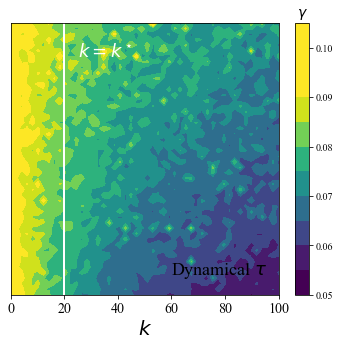

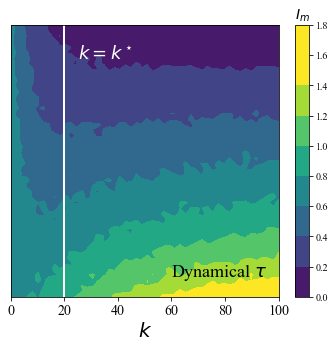

In [68]:
growth_CorrVariance1000=[[0.09541855506225286, 0.09136053947287445, 0.09187718827923451, 0.08862559523172106, 0.0857539214794071, 0.08211311850806549, 0.0812960175861371, 0.08098792926807061, 0.07673686370556652, 0.0749526858302492, 0.07702358332547495, 0.07543082345878183, 0.07367586295695186, 0.06927240722471545, 0.06934662556791613, 0.07135690613675107, 0.07051185029546847, 0.06737155510393246, 0.0685516160033806, 0.06694258397931777, 0.06698530123037795, 0.06415130551795153, 0.06651572844878274, 0.06289358779051211, 0.06340477597791186, 0.06349456572374738, 0.060633364723912696, 0.059595709594731754, 0.06037825532232604, 0.05892103756264251, 0.059681713059940175, 0.06227279144503509, 0.06315220505582493, 0.05951318060778121, 0.059906468548357926, 0.05746376969659209, 0.05998280328717993, 0.05920174386365667, 0.05663503276512159, 0.05923220317232209, 0.057938814674512375, 0.05552785426839301, 0.055806436935490866, 0.059663098938016884, 0.05447323763425129, 0.055379632628275284, 0.055351351799242804, 0.055690160607953065, 0.05454937110210647, 0.057178120070930566], [0.09190434117183098, 0.09120396109627185, 0.09251241027501327, 0.08578511607704535, 0.08588995005097692, 0.08452806624951816, 0.07999306374720071, 0.07974203674855707, 0.07730606739192071, 0.07906511635472345, 0.07773570830923453, 0.0781420215975977, 0.07407470565979388, 0.07129587752973096, 0.072147827998146, 0.06944926403960575, 0.07190265568915026, 0.06717789840217767, 0.06901376029191524, 0.06549161518150459, 0.06493216379665513, 0.07072797861765313, 0.06490926591881158, 0.06561431211568365, 0.06353389743586206, 0.06253253415986584, 0.06330475646557962, 0.06282312971573073, 0.061909053532829016, 0.0614067235359726, 0.062144099168076075, 0.06091875211239102, 0.060425617805447356, 0.06002672998951761, 0.05970939658613541, 0.05833889061010674, 0.05829392089928452, 0.057862250900727163, 0.06293879294817459, 0.05792474108461287, 0.056895840886381256, 0.058948258491010784, 0.05718135729062768, 0.056886572656427, 0.05709864991715743, 0.05638005717195425, 0.056984778076101944, 0.0555482787615532, 0.06012243168794213, 0.05421491736459753], [0.09385207161634984, 0.09202908594760269, 0.08932576281499681, 0.08810891729500901, 0.08389426161275053, 0.0861834016649069, 0.08151606740408232, 0.08063445921085752, 0.08033891361670852, 0.07754147567869234, 0.07746392854126198, 0.07386748466010115, 0.07621138468784967, 0.07182789618972099, 0.07148826566471664, 0.07071968451659606, 0.06989502898081844, 0.06779155781397497, 0.07027842243130514, 0.0674462567419675, 0.06660556571280553, 0.06641455592485435, 0.06619584644128232, 0.06612784891014174, 0.06246447694461755, 0.06427329843586767, 0.0627196468088393, 0.062038977236543266, 0.06121579703199755, 0.06139047295437357, 0.062496926302482755, 0.06118470276260717, 0.06331691531931001, 0.05922935818480421, 0.059160304122871425, 0.060646485204759064, 0.060664951466546865, 0.058610600492611846, 0.05783154097727098, 0.06165063712305949, 0.057158202526557934, 0.05767613720089473, 0.058870344735028085, 0.05769011107495756, 0.056447451994207504, 0.061097137207127776, 0.055569092521839815, 0.05557876079549734, 0.05692850949896543, 0.05912774990675659], [0.09074614625450517, 0.09271022725754349, 0.09299947997725153, 0.08669632006440356, 0.08473379631967339, 0.08392519624395087, 0.08022250816247067, 0.0781358891793159, 0.08068965497882546, 0.08154152784898325, 0.07612260792781497, 0.07451664296508517, 0.07248560495498123, 0.07147250416073485, 0.07174397208527837, 0.07181798700083752, 0.06845474174731905, 0.06809221165525148, 0.0709159021839164, 0.0670926799018162, 0.06739699523220306, 0.06662510666704918, 0.06534119881070796, 0.06533076957628024, 0.06331075572781011, 0.06719166268183913, 0.06282436476171273, 0.06147446033534666, 0.062425310824634296, 0.06162783519272511, 0.06368382336194708, 0.061626103342188605, 0.06008092168392767, 0.06331565267554567, 0.06353079748676414, 0.06033976263889893, 0.058351723168450755, 0.0721125583141018, 0.06020376356192594, 0.06032233463486067, 0.058799380430256135, 0.056320093839958264, 0.06111652612836736, 0.057316518453498375, 0.05723789127157199, 0.05661998817714734, 0.0583857246391929, 0.057554797058344154, 0.0558433357472072, 0.05843322919281784], [0.09306880705514602, 0.09016262166431807, 0.09094781791509175, 0.08693391703594644, 0.0854829717127124, 0.08371821313153394, 0.08947956890997434, 0.07991601442468454, 0.07949256834594368, 0.0748455102157688, 0.08330425064163904, 0.07319911048970103, 0.07273275307139439, 0.07679852787042073, 0.07473309188426056, 0.07357860728513502, 0.06988220489813528, 0.06929221127213357, 0.06729398805365781, 0.06802262059797956, 0.06658472628666463, 0.06672973308345205, 0.0664721766535451, 0.06456666557510951, 0.06643532961259992, 0.06507363871766132, 0.06590304066083999, 0.06635204825308995, 0.06556017989608504, 0.060774328863100247, 0.06265418687199188, 0.05975147555769314, 0.06415841950365883, 0.06638698519929496, 0.059825606764730845, 0.06260378157512407, 0.06037462702343463, 0.06267810631762318, 0.06212362047559012, 0.06008021072779633, 0.058960172782645336, 0.060252550205943625, 0.0637913213278818, 0.06033725518813821, 0.05798824061458171, 0.05757741139443707, 0.05857572740214167, 0.0583317260201987, 0.055466413119280925, 0.06070291631686792], [0.09540557912195105, 0.09063013086504816, 0.0890927488499961, 0.0890403365091804, 0.08501766213885655, 0.08739747310165914, 0.08176605247094085, 0.07820809198048836, 0.07773746910069165, 0.07812498164440647, 0.07704079407704288, 0.07591264294925462, 0.075389050624909, 0.07244200095704063, 0.07694210406568053, 0.07323737315394455, 0.07415363383560966, 0.06883793461961514, 0.06873230053237459, 0.06822847124853021, 0.069128185617875, 0.06891819240404094, 0.06537025793524172, 0.06713905634601991, 0.06612447928702157, 0.06737612443644383, 0.06651514607380962, 0.06394338266525881, 0.06649624165438411, 0.06380986107661205, 0.06133666869073579, 0.06295630876351573, 0.06390869829465129, 0.06126920790908285, 0.06281821631824334, 0.06087247054991037, 0.06318811712080245, 0.06315365539879292, 0.06100863040241587, 0.06111406871112261, 0.06180144140837362, 0.05906610466736093, 0.05861311765645093, 0.05919243028097082, 0.060732280347527916, 0.05704031402835473, 0.05771054828105432, 0.05492621416564819, 0.05713912176359753, 0.05598406217186412], [0.09489955055945061, 0.09435240610430314, 0.08849045858475912, 0.08440618517089593, 0.08629843128225426, 0.08637205779665338, 0.08189215334816499, 0.07892020114809803, 0.07892852999746258, 0.07749280913469676, 0.07728441339061673, 0.07817888686933314, 0.07474438844672114, 0.07359997714586529, 0.07645932995825694, 0.07204679022206889, 0.07481671594648097, 0.0696212747505659, 0.06902643582260831, 0.06809806639471688, 0.06864819997617476, 0.06678627356367658, 0.06674082830988015, 0.06744326043259043, 0.06562552454032894, 0.06533210711274035, 0.06541106808566474, 0.06557308180960902, 0.062499213268056804, 0.06139299906959049, 0.061466330513537344, 0.061976101819336396, 0.06293454835094492, 0.0803503411435146, 0.06249776058310281, 0.06439530262859339, 0.061014023819090185, 0.06123931035814538, 0.05874191998019888, 0.05984370310695135, 0.059283004294295026, 0.06055780984312008, 0.05714659498408738, 0.05826753632593944, 0.061135040490336544, 0.05921748943141261, 0.05783386966154651, 0.0584696212919951, 0.056500212465429404, 0.0582394503246319], [0.09735261501926534, 0.09228831165701952, 0.08950420636699341, 0.09085485933452805, 0.0858097845241001, 0.08426784707049542, 0.08101368867248908, 0.0818239316642248, 0.07883216502133397, 0.07959018968885129, 0.07652610296872717, 0.07723226008213614, 0.07618831611771533, 0.07217247019916585, 0.07258027065790075, 0.07171620119361896, 0.0723791043551771, 0.07367145911177495, 0.0706564827562342, 0.0677157785097526, 0.06689215749797882, 0.06686974258166244, 0.0679709541263337, 0.06880810666175237, 0.06799044239430065, 0.06547691182915484, 0.06916330436504305, 0.062206591202216506, 0.0635762939954897, 0.06666243338853807, 0.06605378913996603, 0.06317765740434589, 0.06220764401770103, 0.06537797240636169, 0.06278395988443557, 0.06372014616330698, 0.062218466019117305, 0.06019568175335955, 0.06148222209170916, 0.060711058439293926, 0.05919278248674125, 0.06199458874425918, 0.06122453195302869, 0.061555979419031466, 0.059660730218470834, 0.0594076152514717, 0.05636706167233654, 0.05974784827693601, 0.06150079966435935, 0.06010564248657966], [0.09594271366080102, 0.09602315827600358, 0.09215498168681405, 0.08926801404635254, 0.08522438240725917, 0.08472568977147098, 0.07985804472863936, 0.07955056626479076, 0.08106976781033742, 0.07928343211471196, 0.078490094484567, 0.07713287454506777, 0.07882446215252575, 0.0726256813716233, 0.07385681034392094, 0.07422282459515658, 0.07079594617790701, 0.06877210953219234, 0.06955114820736095, 0.0697338004032439, 0.06860215376787673, 0.06708995581535883, 0.06588988234091014, 0.06726983071865546, 0.06460790931065341, 0.06599493443278807, 0.07069072914225907, 0.06859446099910821, 0.06568287031609585, 0.06558971617581312, 0.06430477882647481, 0.06403254650535142, 0.06286135835274635, 0.06218833957925103, 0.061543166864394934, 0.0628535786091818, 0.061417002921984126, 0.061313504522498494, 0.06810087467825497, 0.06226128784075884, 0.061111335622915396, 0.059899121897816085, 0.060997135808661826, 0.05925796955670414, 0.05999894471202402, 0.06623321780371354, 0.05758567754086213, 0.059471338745424276, 0.05934588093579925, 0.060387534778558245], [0.09445945159526138, 0.09780573452742443, 0.0870609077712399, 0.08711543951397696, 0.08685937672421248, 0.0883538138563533, 0.0836679031644049, 0.08034282360720733, 0.07962572577770824, 0.0789782873407627, 0.07677313731645366, 0.07526980688035205, 0.07864693435131334, 0.07782203839407928, 0.07497614092158267, 0.07359633975305208, 0.07548354462854392, 0.07118718390256715, 0.06902805195289531, 0.06954049658768768, 0.07211736190256222, 0.06666872714837144, 0.0674655250555563, 0.06903175800479013, 0.0686477587617323, 0.06510066362919685, 0.065795821100592, 0.06769096721133117, 0.06529769870360783, 0.0662178873876551, 0.06780363242266328, 0.061189362721368594, 0.06568027672754251, 0.06670095072641238, 0.06757919532835374, 0.06373891822411734, 0.06207459542441601, 0.06033947309493632, 0.06247901069086687, 0.07231964789303703, 0.06262120518113652, 0.05910532321919423, 0.06211649926951944, 0.062458377545213696, 0.05783093949610918, 0.06125820978493505, 0.06206358600054768, 0.06066417595531382, 0.05742325748619779, 0.05996948791180113], [0.09545975805329768, 0.09024086628698261, 0.08986536097369745, 0.08661328339633279, 0.08342044557425565, 0.08583298709989726, 0.08315820225443254, 0.07927845552901185, 0.07657770158234165, 0.07818098029631465, 0.07600061292756483, 0.07785186243807218, 0.07492940926241358, 0.07455641506644932, 0.07559994210113784, 0.07300363789625994, 0.07644751227136413, 0.07302373919786781, 0.07397777040862027, 0.06994394948190663, 0.06898990494333207, 0.07843402046880485, 0.0676673925053244, 0.0642498969891262, 0.06707761180831198, 0.06443027705057977, 0.06373978619261537, 0.0643617583276993, 0.06415569044592885, 0.06432083060752455, 0.06532459502441193, 0.06336957929815125, 0.06610576453635442, 0.06432117674162843, 0.0657538429918165, 0.06305289680213465, 0.0626812891108621, 0.06345116588480111, 0.06142052799350027, 0.06195671077591677, 0.06712288798055935, 0.06060527434954066, 0.06283319758117506, 0.06049599612422637, 0.0621011713824868, 0.062256526289487926, 0.060281864916991675, 0.06042054242608178, 0.059560875843686766, 0.06077280729571382], [0.09418631969659487, 0.09411234538223343, 0.0886461761568164, 0.09042161696599489, 0.08555316737170993, 0.08545313481157323, 0.08559632634859106, 0.08196213203329937, 0.07835220358898855, 0.07945218926222818, 0.07593451865705522, 0.07779528981469006, 0.07792963756248508, 0.07804181957762749, 0.07444621817455838, 0.0716996240553976, 0.0742875712682801, 0.07475384739231117, 0.07034223574533059, 0.0733307549632496, 0.06837113515121114, 0.07040005146488802, 0.0671489226970802, 0.0760967399818038, 0.06673884616803302, 0.06666918196703202, 0.06710839319887238, 0.06443346404440414, 0.06387244218845325, 0.06513949151865292, 0.06650188393181908, 0.06529187756193401, 0.06594393730156393, 0.06484108633285264, 0.06352798641660803, 0.07153429506991979, 0.06496767150496548, 0.061368038774269044, 0.06248029933857554, 0.06303052622927968, 0.06736514804882869, 0.060301641661679034, 0.060692908857070876, 0.060541809066535286, 0.06247110198562478, 0.05925531745922674, 0.05984618554609023, 0.06282544261965498, 0.06276769656860504, 0.0606545394807873], [0.0949115715759246, 0.09127270704330233, 0.08802354176137592, 0.08762398511949039, 0.08408147899530338, 0.08368504322582988, 0.0825418077819781, 0.08231996803253147, 0.07740283404813533, 0.07784787781640247, 0.08430646843862503, 0.08107835957169474, 0.07725657002538797, 0.07502765859526452, 0.07624143857012404, 0.07521726791527328, 0.07413612651756511, 0.07346443312703087, 0.07102562642683727, 0.07006323069113252, 0.06885617611924931, 0.0821387937590997, 0.0697580141046364, 0.06924744936983859, 0.0705960282264234, 0.06862808205847647, 0.07645702729765154, 0.06608843938968764, 0.06767762525388715, 0.08261091680575136, 0.06684315176705256, 0.06495578284888466, 0.06434485597477994, 0.08189583329035718, 0.06555889102073692, 0.0623349112330303, 0.06260214088839106, 0.06345700618368284, 0.06431915482547765, 0.061834944150250516, 0.06524613853893244, 0.06192071930650047, 0.06049340971194034, 0.060583482982359785, 0.06356583602117262, 0.06491613618542529, 0.06194163466159945, 0.06360117751387559, 0.06208525685541764, 0.06014027242749224], [0.09663038606215764, 0.09167478975312898, 0.09014647186997085, 0.08771939069276251, 0.0884171784067774, 0.08696345298915949, 0.08516116590794705, 0.08433331165256627, 0.07866879780589214, 0.08040421682667473, 0.08051324918978671, 0.08119205575265481, 0.07814128235712098, 0.07400204645079797, 0.07142532063093189, 0.07749738009734461, 0.07377602077091554, 0.07166420042616568, 0.08305132370514988, 0.07021870736741034, 0.07200841699238908, 0.07385396902165234, 0.06873278232509326, 0.07188112213367497, 0.06896780461343843, 0.06845463505216867, 0.06818448697405419, 0.07100885028007482, 0.0646277499238959, 0.06708821803938442, 0.06680571470515285, 0.06816174454176888, 0.06240477929428926, 0.06305384291607156, 0.06978651515125166, 0.06373405643108489, 0.06851093603430747, 0.0642188027298156, 0.06270011406307624, 0.0657351334082065, 0.07013129360443272, 0.06505120469294223, 0.06114154200675077, 0.06384821302064632, 0.061726124215277206, 0.05995610422939209, 0.06211121610850799, 0.059158414216409105, 0.06714975680403866, 0.06356522024586875], [0.09877511535690772, 0.09385062683268412, 0.09123816211010712, 0.088359123667567, 0.08421011341216453, 0.08283362195542048, 0.0848407706092446, 0.08028887005902723, 0.08004444422986914, 0.07905996553403194, 0.07599738426548654, 0.07652836195673539, 0.07932005673701784, 0.07687259128319647, 0.07607628529927143, 0.07467398138374298, 0.07546615205657119, 0.07177586284697274, 0.07411824606936909, 0.07078017530862975, 0.06862542922456058, 0.07100675579678904, 0.07365611621084761, 0.07701650368972097, 0.07093287575660166, 0.0656526905611223, 0.06852334284248393, 0.06571809202626987, 0.06850181538433565, 0.06365811158870824, 0.06653465893785543, 0.06613743595628174, 0.06597417205435317, 0.06550880270586254, 0.06318579264630995, 0.06572606917888288, 0.06555092248630319, 0.06390763359741655, 0.0626500572104907, 0.06506799036852058, 0.061571164091938864, 0.0643780095301054, 0.0623495951534659, 0.06423847804020558, 0.06758575368712226, 0.06303581899518138, 0.0718661116091162, 0.06351723186662647, 0.0697985384802187, 0.06153351060194334], [0.09164108314248105, 0.09302472436381447, 0.0899157345072967, 0.08960629395794968, 0.08718373888421276, 0.08891221580992918, 0.08486647639977431, 0.08194181649570169, 0.08087848783346824, 0.08112306548295788, 0.07831112151134648, 0.07746735340919955, 0.07676339840542558, 0.07369925821015498, 0.07531801851821779, 0.07407806048489439, 0.07250248911115421, 0.07222826659904641, 0.07057235262913095, 0.07341162163961379, 0.0784697361829155, 0.07225598265518468, 0.06928172792330753, 0.06799643945749201, 0.06861536323171893, 0.06630089449747602, 0.06432642211803485, 0.06926766766845105, 0.07375334113770576, 0.06672876581938467, 0.06621452417383757, 0.0700372915389882, 0.06376626972706408, 0.06492478472347853, 0.07000421108653948, 0.06371857625685315, 0.06252170872419911, 0.06493148606259957, 0.06335426684517927, 0.060720031389566595, 0.06504929712788995, 0.0622712329003583, 0.067361869371729, 0.06142152363173403, 0.07114005306057983, 0.06579584214631906, 0.06601375711346626, 0.06018869062825069, 0.06616916159863409, 0.06292586937997245], [0.09335942632696634, 0.09210951262625351, 0.09374293216610012, 0.08758967795003422, 0.08937027061170141, 0.08255523517793611, 0.08323011404913747, 0.08488003127653623, 0.08031281019774243, 0.08403476202461674, 0.07736212768703193, 0.07702293311779318, 0.07393251658662074, 0.08068540907821456, 0.0790078115132372, 0.074338007896331, 0.07348850629454864, 0.07595816777485476, 0.0738761378283002, 0.07050170506141586, 0.07152534853656062, 0.07077070882080762, 0.0672854567250955, 0.07039594201815386, 0.06823941109541287, 0.06684886438654827, 0.06735564624763676, 0.06819030766008384, 0.0684848657198688, 0.06610246333498684, 0.06842372410832717, 0.06593536597711938, 0.06802486221892491, 0.06558667281588236, 0.06357687685348305, 0.06897238898560414, 0.06825463295891993, 0.06535451684933413, 0.06251587480661185, 0.06496319817747978, 0.06492128050439934, 0.06299183442116672, 0.06267430193284197, 0.06544687409574379, 0.062232071457483114, 0.06451395952449308, 0.06688449664110835, 0.061942508012971936, 0.06518122756215801, 0.06496846893959332], [0.09655664071671238, 0.09259985538814089, 0.09772904858516032, 0.08733357088722064, 0.08484435227559993, 0.0815217847128382, 0.0939699838941401, 0.08159529053848597, 0.08383880709433238, 0.0853430974980892, 0.07773885176114081, 0.0783685612610193, 0.07826353011730589, 0.0765906293048826, 0.0756156598054884, 0.0752743061606181, 0.07576734200311479, 0.07383180053852778, 0.07324124246065698, 0.07408298050637223, 0.07128072311703637, 0.06968678108566291, 0.07295513990287193, 0.07103126258539741, 0.06820945033508624, 0.06944552814293943, 0.07258078375372568, 0.07025991856820926, 0.07132336805211828, 0.06738637806214812, 0.06744400609078027, 0.06946119013467031, 0.06678393654381726, 0.06688432828773568, 0.06406004986689742, 0.07075684447093535, 0.06933544103465963, 0.0681069793006453, 0.064900015987237, 0.06499442246687714, 0.06532519722989172, 0.063627123556285, 0.061037387089571786, 0.06394698989296287, 0.06753678771276278, 0.06286808434436898, 0.06265308053441877, 0.05966901129316355, 0.06161258198438918, 0.06396752695882117], [0.09632641837282194, 0.09410380005845716, 0.08891011186380586, 0.08741003397739475, 0.08939766185291541, 0.08461729719545401, 0.08322672751461443, 0.08449434789377273, 0.08107672713797928, 0.07785629474266888, 0.07671941753189601, 0.07927494813079204, 0.07670854168541869, 0.07850075817006733, 0.0771417833481684, 0.0734032455014533, 0.07343089951182707, 0.07636293515315343, 0.07826294798386522, 0.0731123908621951, 0.07619986423201527, 0.0687100656458836, 0.07657980601626471, 0.06885851812198573, 0.0684510093596269, 0.06544535811432677, 0.07049050677458892, 0.07028211087454195, 0.06684651082345823, 0.06824491320342843, 0.06951377140544936, 0.0695651657574936, 0.06519095654647691, 0.06460505312816603, 0.06425095318784767, 0.06461285397851808, 0.06912317373755157, 0.06572655908357194, 0.06220172289632566, 0.06247956687279006, 0.07047345038284498, 0.06186225642659778, 0.0661994880041849, 0.0605958963668478, 0.06361677326953748, 0.06365329457087092, 0.06374774131882639, 0.06311088873584454, 0.06323791342125598, 0.06135069357519602], [0.09559859216655633, 0.09598618094979124, 0.09227086491178955, 0.08749289437797483, 0.09018259225083469, 0.08844017990013478, 0.0856715153771346, 0.08214954756931961, 0.08147715619818018, 0.07862147834526124, 0.08032405392326887, 0.07893066610637217, 0.08014917068570197, 0.07811969391632465, 0.07622651405872824, 0.07473009106656917, 0.07490400073004037, 0.07313870982561337, 0.07064772856154608, 0.07992471962442901, 0.0751155911179523, 0.0741923363053114, 0.07210538073427782, 0.07603108038219994, 0.07072896778462112, 0.06617603251940368, 0.06820832970086299, 0.06952465350588796, 0.0669096512316138, 0.06621138063814244, 0.07003260041022082, 0.06842905306928836, 0.0666510039165932, 0.07002993540341694, 0.06660458858564412, 0.06809374793289774, 0.06711676319563636, 0.06674347475706262, 0.07256693948653274, 0.06457045289911277, 0.065850347034589, 0.06322540323580404, 0.07763851368825904, 0.06872559790551223, 0.06033121331637994, 0.068186180076354, 0.06236629520967761, 0.0630833998322539, 0.0659563744827867, 0.06274739093119287], [0.09225727197332673, 0.09340650254155582, 0.08875404987409242, 0.09017568307182398, 0.08497303621289792, 0.09439888146200452, 0.07973463692179887, 0.08269052821807264, 0.07964371161733923, 0.08579225318003468, 0.08222313179126882, 0.08058267215398292, 0.08429547695060602, 0.07720273468578591, 0.07604350081003268, 0.07613133460140308, 0.07520150947703803, 0.07583368146450833, 0.07294034886342388, 0.07744577658959902, 0.07149988511923992, 0.06951392067940218, 0.07099700499791835, 0.07126636278502155, 0.0737911463215074, 0.07197694865479805, 0.07388338698079953, 0.06817359350693929, 0.06865703950861836, 0.07029428963811747, 0.06402226934087411, 0.06734901323216497, 0.0646756347529735, 0.06668401935272292, 0.06662483633948102, 0.06395337916797872, 0.06789712340593868, 0.06692494219497196, 0.06715150983056571, 0.07624153439155217, 0.06917479276058128, 0.06538157868104331, 0.0671434820930078, 0.0648998827851222, 0.06518979442353807, 0.06203121579007573, 0.06770166812264057, 0.06362279244598486, 0.07078754891902252, 0.0663129439269365], [0.09625724704792679, 0.09059328447748648, 0.08731417106527728, 0.08752221803221723, 0.08458124742353322, 0.08396228795083985, 0.08356471893409814, 0.08143399022757379, 0.08359078591895125, 0.0786680117845894, 0.0778597624868477, 0.07813347355832828, 0.08358469485812307, 0.08218183286565768, 0.07720838617952791, 0.07799747424113825, 0.07488541905695364, 0.07519953985121848, 0.07213410611872294, 0.07231995613395391, 0.07756235355695744, 0.07425526028238467, 0.07413725396189882, 0.07237825296952571, 0.07159174581954751, 0.0668406650858644, 0.0710361439356411, 0.0724570161290381, 0.06957252415713758, 0.06826854305144038, 0.0696302126029226, 0.06589711096740082, 0.07583091131787703, 0.0763703348047343, 0.06732526981258159, 0.06803014333992416, 0.06730291668975628, 0.06549957837552002, 0.06613939833123303, 0.06734763287897082, 0.06496964815441529, 0.06706772948307126, 0.06814899985367104, 0.0668105001876467, 0.06527372536994715, 0.06348041740459029, 0.06348670904513193, 0.06166278635146911, 0.061683054655875084, 0.06427445861137918], [0.09365224555850414, 0.09443456288172336, 0.08823140766358774, 0.09256334449370071, 0.08536134191883758, 0.08666589483007842, 0.0842927842082899, 0.08237468213121157, 0.08380604409877485, 0.07968345723519897, 0.08024030750605927, 0.07621758116334354, 0.07689790883105667, 0.07882356835756844, 0.07938625816232305, 0.07565185003224614, 0.0763495791946494, 0.07512499135411976, 0.07490793103600019, 0.07149840538832936, 0.07416346273522562, 0.07298846345381414, 0.07114580799676719, 0.07285190483294716, 0.07172105661778992, 0.07121809372402915, 0.07175403645539417, 0.07362232648671058, 0.07047412115638747, 0.06862719951647339, 0.07057849551727503, 0.06662064588487812, 0.06977816665444507, 0.06731314294820584, 0.0647406609077002, 0.0680684043571994, 0.0692857888908208, 0.07781051872147829, 0.06383836249438814, 0.06926983670128162, 0.07349022171848939, 0.06729630750369191, 0.061859676936142444, 0.06296254180963597, 0.06362400683443949, 0.06564675736925037, 0.06654321997737164, 0.06332096912887225, 0.06827287292807079, 0.06224928721364119], [0.09646607651986948, 0.09537542882745852, 0.09287575935273377, 0.0921575461559852, 0.08598550540011185, 0.08440276265943478, 0.08385706831271404, 0.08394500317385611, 0.08041873025793646, 0.07969517885476064, 0.07879870235822783, 0.07590725833230563, 0.0784734789864606, 0.07750763423076777, 0.07688466390470854, 0.07749935369190751, 0.07477864235395075, 0.07525199648960157, 0.07194473151516464, 0.07809902611451863, 0.07177327118620934, 0.06896830901854573, 0.0699761704905014, 0.07131974061086908, 0.07296745632621215, 0.0700646118555468, 0.07215263907853375, 0.06968313921383362, 0.06984330181959517, 0.07075750772904985, 0.06711229538548057, 0.06834299430328439, 0.06887333882329295, 0.06746434585896414, 0.06659127972068557, 0.06796780433710335, 0.06470631942930276, 0.08068678513451634, 0.06688311491062567, 0.0671293052061153, 0.06741042908555428, 0.06891066569214066, 0.07557870076343193, 0.06153441349345756, 0.06460630191375917, 0.06838269328211846, 0.06656387477370503, 0.06635281158937718, 0.06687390084654853, 0.06750868073870733], [0.09432047727528714, 0.09192836268125047, 0.09131403627516604, 0.08962823695223199, 0.08729822332203599, 0.0842941175553629, 0.08375357102414867, 0.08518496995906427, 0.07825186326252602, 0.08284324268711261, 0.081951177146959, 0.07898688816123675, 0.07955543153710867, 0.0770191463867727, 0.07822459957613366, 0.07620438364523144, 0.07474248674120147, 0.07627282816766173, 0.07723011635922827, 0.07203272980446694, 0.081026602478291, 0.07010560981031898, 0.07670359160375662, 0.07322207666408194, 0.0749813983906815, 0.0699785008872201, 0.07334567257404616, 0.06948992617826939, 0.07059503430715036, 0.0694247011524452, 0.07005025172605815, 0.07251639363358954, 0.07024001149219733, 0.06623056736722296, 0.06803697963025662, 0.06739691891811446, 0.07020482240475874, 0.06842795771243097, 0.0711613026743977, 0.06705868835864093, 0.06663715781192187, 0.0800573594325432, 0.06241118939953686, 0.06365103484179499, 0.06466889300941243, 0.06362709810376821, 0.062596769708841, 0.0633725723419451, 0.07125435325320303, 0.061707381953279905], [0.09412323592901775, 0.09153200416982153, 0.09024976415980605, 0.08793243448920907, 0.08895577245462773, 0.08828289066223667, 0.08635140158169946, 0.08819690467338587, 0.08250635477955602, 0.08031952973907215, 0.08039854479298683, 0.0804038580572422, 0.07861285819651108, 0.07932281536018498, 0.07447976922738116, 0.07765065147943127, 0.074362514199152, 0.0754234104792317, 0.07458123023815709, 0.07238205930775235, 0.07317550532570928, 0.07464790242396382, 0.07365725089072175, 0.06946025658665604, 0.07193284482741447, 0.07178945509308375, 0.07068441720700058, 0.06918020978206, 0.06691438689450109, 0.07068581711062794, 0.07090593377717545, 0.06680471280207785, 0.06942687754712809, 0.06603155857917674, 0.0683093267630372, 0.07509560407749497, 0.06599523913525207, 0.06703190297077337, 0.06592490201533895, 0.06765678528438637, 0.06776173327993745, 0.06609427097164348, 0.06504518663314149, 0.0672048212074045, 0.0686178618776417, 0.06573387786578921, 0.0642306773504823, 0.0632635406706809, 0.06707093504981573, 0.07011541569575375], [0.09957958446555296, 0.0955407557928757, 0.08853009428202208, 0.08792482819869908, 0.0832341153866704, 0.09299208282326334, 0.0827196996869531, 0.08292130518838965, 0.08316459130318382, 0.08560211825921865, 0.08177562121007194, 0.0819548302738674, 0.07770014841411663, 0.07968303516146878, 0.07892249524386195, 0.07912954018790833, 0.07425732526600856, 0.07442931228759894, 0.07834153983829732, 0.07302549284677522, 0.07733408332796601, 0.07531407061976811, 0.07073281914660888, 0.07425188379533584, 0.07243792160952987, 0.07113624817535467, 0.06727368341112995, 0.07149893500364697, 0.06735172494993098, 0.0704792777682578, 0.06644335620092631, 0.07531721031478288, 0.07030404207099455, 0.06910970116872953, 0.06982384093896812, 0.07155861879123757, 0.07219336272230056, 0.06602514874739919, 0.07268767745422959, 0.06890801750197519, 0.06559965663076357, 0.06581664941201497, 0.0706786453982375, 0.07044957568795444, 0.06631092464518998, 0.0701765415823141, 0.0730756110580031, 0.06603615549777601, 0.06650101615849546, 0.06335723134706095], [0.09168747061046173, 0.09135140206063219, 0.09078228638797593, 0.09070404734877294, 0.08813993704966612, 0.08628452262400328, 0.08657516434290427, 0.08372407343016748, 0.08345259672066468, 0.0832736346505323, 0.07851763615959696, 0.07572757056178711, 0.08048846801185523, 0.07780585839947421, 0.07751762244336181, 0.0795248388870457, 0.07677196611238893, 0.07743669555158646, 0.07261931956099638, 0.07518533553268253, 0.0731076307314015, 0.07214975205725781, 0.08457438168133109, 0.07108972755575196, 0.07000863472494107, 0.07219218740808582, 0.06988847345437871, 0.07465148235617361, 0.07064914882608654, 0.07202791085672548, 0.07428144303411785, 0.06930909774483164, 0.06710181050348826, 0.07196628276157117, 0.07052531629806523, 0.06912126100330261, 0.06590038294427746, 0.06613559217061901, 0.06662988488146251, 0.06882520137888484, 0.0644340853813139, 0.06726252166696342, 0.07028765352613835, 0.06651198506720946, 0.07010765176464602, 0.07049113168130688, 0.06912379938309006, 0.06553094673066111, 0.06550992466512306, 0.06449968371831087], [0.09452544773294325, 0.09021773486782099, 0.0958292045401687, 0.09230398716528214, 0.09372127982277638, 0.08557534033464126, 0.08446349355795524, 0.08447668048923111, 0.0829438956545862, 0.08017804296380492, 0.08330266986309495, 0.07910066924482755, 0.08035198365995846, 0.07943185045748734, 0.07844424816662655, 0.07594384882160016, 0.07436323543956232, 0.07591608315857236, 0.07465554155087337, 0.07393289638017496, 0.07258450725197013, 0.07407036672507734, 0.07382623918068944, 0.07894512256845558, 0.0741590663674939, 0.07421111906695972, 0.07118663378069764, 0.0702009819915334, 0.06870878642207058, 0.07174703333571589, 0.0715627464733166, 0.07524430646117293, 0.06913584697913246, 0.07260937213185661, 0.06768024688250286, 0.06731770182951606, 0.06820871639047825, 0.06802325546001856, 0.06625790736287249, 0.07152988309403582, 0.067579984765135, 0.0643573378829103, 0.07110914800154254, 0.06621616231823087, 0.0687937301441805, 0.06571536668643939, 0.06416955432751023, 0.06622329441561471, 0.06639944519544912, 0.06856490760795417], [0.09387826518410297, 0.09385423823039307, 0.09611611331353466, 0.09118210282636045, 0.0920119203617427, 0.09175625392808469, 0.08500458582962266, 0.09334453385254926, 0.08182918092780962, 0.0803135148118931, 0.0820399857512413, 0.07861278456261162, 0.079445697508889, 0.0778100863168891, 0.08183303568107735, 0.08141759541364024, 0.07807783291158185, 0.07729462078638537, 0.07533237526014512, 0.07849045914790133, 0.07588623002258209, 0.07483974668790297, 0.0738333871816803, 0.07551152831656766, 0.0738876638092618, 0.07108883735310997, 0.07232361623641975, 0.07547500482012719, 0.07197730696484844, 0.07178741988729198, 0.06789631600060812, 0.07040694900327683, 0.06797036548922222, 0.07354254228140594, 0.07490369170317679, 0.07429359841188386, 0.06619822587337874, 0.06966124670552656, 0.06795233234802094, 0.0698952387581351, 0.06853187497078012, 0.07004917883353604, 0.06548470520815099, 0.06828730987907541, 0.07065562675067576, 0.06739990435841195, 0.06585492112228558, 0.0657405542963716, 0.06547160173673872, 0.06853880033109742], [0.09476633024213918, 0.09395061203000837, 0.08679535735041624, 0.09098133802225718, 0.08610640343106685, 0.09107377838797673, 0.08588481848060747, 0.08296274420938204, 0.08502730905544581, 0.08651929942631821, 0.08159320760202109, 0.07910268420906902, 0.07623281946414975, 0.07629565018264566, 0.08059386861536445, 0.07818796851582648, 0.07922185632025254, 0.0829698981231794, 0.08146769163002224, 0.07512133883430559, 0.07739074484017588, 0.07345861397464383, 0.07592632523682558, 0.0722613638769008, 0.07414316498743052, 0.07296189971913107, 0.07246426746499263, 0.07441247222714387, 0.07060280960221076, 0.06935959314803729, 0.07362765584027596, 0.06716675073849404, 0.07656762565479443, 0.07264404789038757, 0.07111352310961837, 0.0687772077726234, 0.06740053353689106, 0.07007880295927064, 0.06811316365747395, 0.06754613862175528, 0.06469897907103335, 0.06920960407381455, 0.07151358763435549, 0.06905381242009803, 0.0645280324372725, 0.07045839291676967, 0.06751799791582296, 0.06385775507274798, 0.06683035768862725, 0.06835720492279194], [0.093721097581103, 0.09237697298307614, 0.09173801450045059, 0.08779632193135654, 0.09294457977521417, 0.085772072282785, 0.08364902284231979, 0.08403382036144481, 0.08581965974235596, 0.07953074488298426, 0.07940962649909182, 0.07902770102585964, 0.08387514739311301, 0.07678562564301085, 0.07540345943721474, 0.08388928850582787, 0.08214054875313004, 0.07489915909624525, 0.07318346845046711, 0.0740456521819747, 0.07378853926338806, 0.07223245344235057, 0.0749159217552706, 0.07372270850800076, 0.07876802569771987, 0.07691523334612983, 0.07320566529708314, 0.07377778439507258, 0.06975736510370935, 0.06891325734961609, 0.07477003152480521, 0.06878093080947932, 0.0742256142617352, 0.07394520565543855, 0.07562249659185596, 0.06964565144307266, 0.06734548976664038, 0.07071905097246908, 0.06915736286205375, 0.07249369559308896, 0.06913651486144537, 0.06660414202362457, 0.06672034315277033, 0.07114000104742663, 0.0675297491633229, 0.06767993821786795, 0.0645967940865434, 0.06639776724325222, 0.06333560246470878, 0.06388847544934435], [0.09126922284458022, 0.09336053606299953, 0.09185939309290433, 0.08654610109302159, 0.09098771465867926, 0.08659153079399545, 0.08874304641885766, 0.08541086186839439, 0.08194890374808585, 0.08256738024095096, 0.08061906394000566, 0.07751156509264057, 0.08078984602530596, 0.08163741036008311, 0.07919627061826855, 0.0834314666982513, 0.07790069160111482, 0.07670668378017766, 0.07784229976803107, 0.07526899030283843, 0.07334275296732211, 0.0739169861019289, 0.07551596303619466, 0.07356869200730778, 0.073939281122037, 0.07491160606299065, 0.07201303448228999, 0.0736693473192684, 0.07193885053637608, 0.07293909992027743, 0.07842661747158605, 0.06898255633775337, 0.07012136033194434, 0.07979929856988874, 0.06814824938827525, 0.06447664420620029, 0.07246389128588343, 0.06794706044653724, 0.06714947494874415, 0.06616875139550782, 0.07234052349600247, 0.06651782508021252, 0.0661393173557583, 0.07042554397785934, 0.06913205140131974, 0.0652270138125792, 0.0674251930039122, 0.06837433103769668, 0.07261372469849592, 0.06473541264494781], [0.09668825668139264, 0.09364890049017348, 0.09081717352714731, 0.09311493862907938, 0.0884497541235119, 0.08884908909364878, 0.08392242660172236, 0.08436135687411721, 0.08338761673254093, 0.08309374883615042, 0.08097529932774818, 0.08292467432840715, 0.07901847712768968, 0.08157009597419643, 0.07890092435142831, 0.07751213999141908, 0.07383952432686414, 0.07690734881729203, 0.07617007488175696, 0.0752563499043087, 0.073680704464266, 0.07200516314600815, 0.07350486127572126, 0.07231828796264715, 0.07134320339509213, 0.0739004978174035, 0.07336147264556157, 0.07034007507638983, 0.07151187864686709, 0.07244341317235899, 0.0740608073649683, 0.0735627953311799, 0.0802442828159285, 0.06960318879133713, 0.07250805232229678, 0.06902653560211965, 0.07685239448550835, 0.07002553832813621, 0.07123279179402722, 0.07047919263149884, 0.07075684317661621, 0.06908285493183534, 0.07037126808130871, 0.07550623086496941, 0.07143810717541936, 0.07450843361984708, 0.07209988511781905, 0.06856885455977985, 0.07238385465264047, 0.06794748722610304], [0.09457147570597055, 0.09315631455335918, 0.08930760855114203, 0.09438039835979706, 0.08761059879230144, 0.08610210255030036, 0.08685078485212636, 0.08187650129423028, 0.08143242607259898, 0.08355646555502545, 0.08393855423738032, 0.08078867693102143, 0.08014581192983337, 0.07695405969379525, 0.07780076399605801, 0.0761568320164718, 0.07562370198577609, 0.07728742813033054, 0.08127873017813379, 0.08409233334696653, 0.07943816251212435, 0.07806819226450462, 0.07515350312235582, 0.0754815337573718, 0.07675889919274437, 0.07315647170733819, 0.07521128959151589, 0.0726943530590881, 0.07422437546959919, 0.0726616854326122, 0.07499165741816778, 0.06937694120304788, 0.0717176090761204, 0.07215365117560966, 0.07481588275172683, 0.0704710208760466, 0.07297719689219496, 0.0696899649009077, 0.06958816966507529, 0.07050078012396697, 0.07034418102566696, 0.07054082013336044, 0.07605561089027331, 0.07207836977588604, 0.0696169719360727, 0.0684051020333414, 0.0701928261456303, 0.0673261858176968, 0.06490527520510889, 0.06492268973958269], [0.09798714541517517, 0.09143895126981635, 0.09088656412372352, 0.09035753636901772, 0.08711328793727725, 0.08735251614619488, 0.0874527115842841, 0.08234840295376199, 0.08396821180416332, 0.08987042987715806, 0.08120708480358678, 0.08264423051215826, 0.08005468013884869, 0.08200346086473456, 0.0819868813796937, 0.07928154442692453, 0.07834147897140505, 0.07676743138734657, 0.07292392378050755, 0.0745424478753825, 0.0780415844001813, 0.07746233237918944, 0.07813168447572162, 0.07401877434960566, 0.07420094715903605, 0.07800144229535069, 0.07313070594645332, 0.07331960079125106, 0.0857815780846403, 0.07179314670665746, 0.07209061235792436, 0.07310616227038785, 0.07283033919690449, 0.07080923753871454, 0.07301240948871812, 0.07435112382138863, 0.07652793404435478, 0.07108346860355248, 0.06970292483370095, 0.06821520232021606, 0.06856407943660457, 0.07032983053573905, 0.06841189605314064, 0.06874524594662104, 0.06642999943450908, 0.06770856095150996, 0.06729139711707939, 0.07600360660869272, 0.07003161248190654, 0.07595872943996407], [0.09760702374973698, 0.09128027273410198, 0.08914120936983878, 0.09254930086409498, 0.08679075855917827, 0.08380551171766153, 0.08466402471967246, 0.08754424130171519, 0.08449252096576931, 0.08259131013596487, 0.08005776084050373, 0.07802191232471388, 0.07926992377499388, 0.08245249592020393, 0.07811251920628291, 0.07986593336749698, 0.07641340848069601, 0.07800006114569413, 0.07506980928070253, 0.0761720962628143, 0.08261923511639294, 0.07432228137220075, 0.07215717169528757, 0.08421447306776095, 0.07632535414223393, 0.07576544787329656, 0.07455430436443483, 0.07293578513974049, 0.07074666305094936, 0.0713358784177286, 0.07962359075592297, 0.0714952287267863, 0.07415389144742417, 0.07681710782079967, 0.06854049189290343, 0.07312645313730838, 0.06905513841255531, 0.06616192736758465, 0.06939765237321303, 0.07034656704721087, 0.06923898281147947, 0.07543681213150753, 0.06917589801530168, 0.0673059680187922, 0.0710167770459673, 0.06947781038857222, 0.07027537345310692, 0.0662041724764028, 0.06858928200250029, 0.07339114833866923], [0.09405453563493564, 0.09168525866790002, 0.09357904449483627, 0.09798155053712031, 0.08819841951320939, 0.08660916635395294, 0.08979587372032627, 0.0819578557167617, 0.08804454644785788, 0.08164746157288252, 0.07950489640014967, 0.08439830645038306, 0.08209550912027812, 0.08391285586197948, 0.07888646437411391, 0.07568100801376337, 0.07925852165143932, 0.07751699642797276, 0.07452874973166809, 0.07806284159612341, 0.07199472913157193, 0.07409125198061654, 0.07537971133944384, 0.07426437348877159, 0.07264288338550279, 0.07429879781744744, 0.07435698245441005, 0.07316182230583272, 0.07279914690424683, 0.07687774669311685, 0.07044678687357482, 0.07747026793134454, 0.0695476875069716, 0.07897302424945496, 0.07578978908325701, 0.07250029310034223, 0.07505350709518786, 0.07175348728490569, 0.06955781046958646, 0.06841205731814429, 0.07096676650294133, 0.0687888795751347, 0.07082955745745885, 0.0680079668367639, 0.06608111151980148, 0.07106040113900068, 0.07134355072158542, 0.0700732666453727, 0.06924192108314983, 0.06730314587356315], [0.09598529672307635, 0.09682158078091858, 0.09523217825100921, 0.08937967110748522, 0.0879937952419678, 0.09137626388426082, 0.09111564420181392, 0.08496007712706506, 0.08268644056399435, 0.08015985128261478, 0.08578179026452794, 0.08190458265272497, 0.08083334952112063, 0.07709266285546285, 0.07971883055307517, 0.08471482415834695, 0.07681552540215, 0.07671735046386503, 0.0744782960530438, 0.07548766538981021, 0.07524163306327168, 0.08353446159807254, 0.07493759742736425, 0.07863247676816659, 0.07371539721079813, 0.07536674125663016, 0.07901459333973673, 0.07322609023129642, 0.0748361019958139, 0.07294914318766263, 0.0749549876753812, 0.07219927949471294, 0.07472577955889641, 0.07800800241149361, 0.07409079353616599, 0.07091102010554906, 0.0725528837259408, 0.07177270378969332, 0.07075905113878028, 0.07456327099805225, 0.0694245472276726, 0.07419178373284965, 0.06597649204498313, 0.06804376070895445, 0.06896445842053112, 0.07095514726695196, 0.0704532104935448, 0.06947876004160873, 0.06684827461631666, 0.06677480284878518], [0.09405378266805955, 0.09473257201292212, 0.09385111677181439, 0.08917175640938765, 0.08564086777421638, 0.08741291661223866, 0.08767731786229739, 0.08371763970701288, 0.09116352960673144, 0.0799492069241844, 0.08303868510203012, 0.07852656577034745, 0.07725158990041871, 0.08711979423025978, 0.07919063092902641, 0.0801540493385849, 0.07721716244233517, 0.07886672554662413, 0.07691221434527364, 0.07786223231439642, 0.07593182263839783, 0.0771226048951495, 0.07448631194429513, 0.07443355867112927, 0.07863427156778961, 0.07723117869571809, 0.07957090005041877, 0.0822308000750775, 0.07496246574516481, 0.07278741575226548, 0.07499790644674036, 0.07170447190874796, 0.07859467598618099, 0.07312673184787101, 0.07991087785064352, 0.0703658373422208, 0.0721243496956442, 0.07057601266469612, 0.07509228854666032, 0.06937534496373048, 0.07231724929735392, 0.06682505392128023, 0.0734918836181632, 0.06695632275124126, 0.06702208267465073, 0.0673993526565048, 0.0722663357143282, 0.06777233861792038, 0.06551165863113793, 0.07428427951200493], [0.09564032257322097, 0.0938470006180006, 0.09247218866388476, 0.09218569213865886, 0.08595871684384425, 0.09087051444701331, 0.08678072815144287, 0.09340058898172757, 0.08299873491565805, 0.08129879957583644, 0.07975107564504656, 0.08265816652668133, 0.07809685950983589, 0.08345187895960444, 0.0873989669168437, 0.07808483700029072, 0.08756994799906012, 0.078293144096145, 0.08120208945073211, 0.07479201681470167, 0.0757020288750976, 0.07673351326747539, 0.075009875324452, 0.07679037889582191, 0.06999014599368439, 0.0723008360271029, 0.07283485216799453, 0.07379765239702596, 0.07575505406321362, 0.07266075439741329, 0.07052289828180625, 0.07372705637631144, 0.07271946091477864, 0.07431303795715846, 0.07486154980663018, 0.07148492458129983, 0.06991086780825871, 0.07450731918335056, 0.06744777568942911, 0.07633864889525233, 0.07299868895548045, 0.0731162209266657, 0.07086366196127268, 0.06985557652991643, 0.07480309058437683, 0.06579273479039084, 0.06830248456019838, 0.06717797846348204, 0.06636724015327473, 0.07183471678871847], [0.09449337550527714, 0.09387825499793077, 0.09045969210828425, 0.09167995416739688, 0.08604803835541619, 0.08430891422797003, 0.0878181760752837, 0.08507611508072203, 0.08339923322341042, 0.09181198164585508, 0.08158344059662326, 0.08777994991897617, 0.08263569513149475, 0.07881431139749716, 0.0816106659116595, 0.07880126896552732, 0.07841964283896556, 0.08889260279232432, 0.07558929057304573, 0.07122250337835491, 0.08199928505924042, 0.07364702555624614, 0.07380125098238648, 0.07670393062569035, 0.0750433027614624, 0.07397561313456497, 0.0714784208207422, 0.0711085245879942, 0.07740728092747688, 0.07151247260431999, 0.0722242345558659, 0.07173474917928586, 0.06976184471709539, 0.07438709729631797, 0.0794775390848024, 0.07090558132009728, 0.07327012417331666, 0.07265188811126053, 0.07093817734781792, 0.07236831689066665, 0.08017281021007876, 0.06969191045968258, 0.071765651049145, 0.06894148128822426, 0.06852723432369172, 0.07209516758225681, 0.07028414060623374, 0.07024857290994097, 0.06953471579480297, 0.0683609966601916], [0.0941745607749336, 0.09256930956469436, 0.0898515625352264, 0.08975410867269823, 0.09066136484248988, 0.0888418899443465, 0.08735840691569756, 0.08742474252852266, 0.08217185801842426, 0.08674662844635313, 0.07959940585321051, 0.08796235491199424, 0.08665837541592429, 0.0819368244342821, 0.08441634410270277, 0.07752190554223408, 0.07998224455715014, 0.08337185557126789, 0.07874408912023274, 0.07427502017626135, 0.07808319428096142, 0.07730567753956355, 0.07432090649332543, 0.07551267639128194, 0.08006032469450901, 0.0809409420072602, 0.07596468423530629, 0.07641489196292739, 0.07363382499507046, 0.08191845333888581, 0.07221743026808991, 0.07809733639874075, 0.07007855941832554, 0.07473034691075667, 0.07513602411600606, 0.07838349491320984, 0.0800946399452857, 0.06960348322209828, 0.07183962449178935, 0.07303877280883186, 0.07488580799689715, 0.07066574212968925, 0.06846372567222077, 0.07042729803636365, 0.0674786350948865, 0.07432189757179951, 0.07360474108978926, 0.07031584513123933, 0.06640205035887675, 0.06924479654152607], [0.09492362076695826, 0.09055223512351752, 0.08924202669910768, 0.08899369311413872, 0.09357356935799387, 0.08490536407184462, 0.08679628890791123, 0.08564268090014414, 0.08556601024190716, 0.09839759807004655, 0.08022545455794516, 0.07911433538513415, 0.07999361477936252, 0.08498711048936503, 0.07714510554812395, 0.07652061078952556, 0.07879370808114261, 0.0902788019023137, 0.07889947714585004, 0.07796841935869175, 0.08291981628107546, 0.08080564306216119, 0.07524876473359429, 0.09574989294743672, 0.07295493723717346, 0.07539054050804951, 0.07208008968971365, 0.07441207222561387, 0.07253521095874288, 0.07314874048568756, 0.07625764828146918, 0.07271667441369244, 0.07395457756478538, 0.07717163144118529, 0.07857791803342265, 0.07453118916222184, 0.07353253546315658, 0.07264967369150409, 0.07337836496279691, 0.06795783317985918, 0.07892040191666616, 0.07220925792431838, 0.07262021802608387, 0.07102717457248668, 0.07082701139130541, 0.0690536033471227, 0.06778464800242429, 0.07933807063455223, 0.06694720159426566, 0.0780438826760151], [0.09967532548648957, 0.09111297946779329, 0.08820332706492989, 0.0902219981559507, 0.08748883143674056, 0.09093117918176102, 0.08844387286562416, 0.0869537522775569, 0.0861890436178213, 0.08680451280524615, 0.08198495983686613, 0.07950760428340707, 0.08325786863076845, 0.08297595499497494, 0.0785810096154403, 0.07878321426315843, 0.07818459193596404, 0.09195342613096726, 0.08855388558577808, 0.08381104477469893, 0.08101761711317705, 0.07198599661774821, 0.07682440345096611, 0.0756688238012209, 0.07596811081880957, 0.08077668130220352, 0.07358899946783555, 0.07978079421650039, 0.08274639068110698, 0.0788152215707307, 0.07209655893152699, 0.07272117600267351, 0.07755306302902473, 0.07192486971504086, 0.0731997574931129, 0.08003236657939997, 0.07581518703864154, 0.07123059691137433, 0.07127308277078914, 0.07313012966264189, 0.07313876037941208, 0.06937187211908073, 0.07208896679718055, 0.07013857110750027, 0.08699911393952063, 0.06651566124159822, 0.06986438272703734, 0.07624253943733325, 0.07225672961330226, 0.07276650637745782], [0.10179670922933567, 0.09394373815712476, 0.09164263787978368, 0.09158105502924258, 0.09152803833172357, 0.0872869548236055, 0.08304521654347978, 0.08849057866499747, 0.08247728388111357, 0.08211946706077455, 0.08124068195155257, 0.07723351389723002, 0.07909856177595186, 0.08412974597711464, 0.07795028036559536, 0.07725528963726637, 0.08029541923270339, 0.0783717649075094, 0.0785604601341794, 0.07797277826479423, 0.07921359359751667, 0.07929820425419512, 0.08335242559146343, 0.08011838622464558, 0.0755320691753152, 0.08377901979369824, 0.0742264010492252, 0.07688099775810142, 0.08102575526914761, 0.07520545658904722, 0.07574427869553901, 0.07406592620542807, 0.08115586033309655, 0.0709899099922173, 0.07221098371504088, 0.07375384406601794, 0.06835364809277587, 0.07890201869314585, 0.0714627592333963, 0.07717802676993091, 0.07702769185725447, 0.07059547365486918, 0.06993241101995942, 0.06783753995612564, 0.07296963566404358, 0.07077495749203316, 0.07278215569468287, 0.07724266481163804, 0.07283474512750965, 0.06830160627122175], [0.0966466235293135, 0.09959707038186323, 0.0920939834522294, 0.0940136097920912, 0.08967506486021573, 0.0865942310636308, 0.08619915767338891, 0.09336439331970434, 0.08364364446339655, 0.08442978436042556, 0.08995727210993568, 0.08632747789675697, 0.08325313578983497, 0.07955504875338872, 0.07696382930552098, 0.08115178860681528, 0.0816445261116462, 0.0771187904948842, 0.08036647080974767, 0.07558285656183626, 0.08117928802199886, 0.07623266265545253, 0.07886878220810668, 0.07434182859106155, 0.07854375916936172, 0.07690676790620592, 0.07532550723951205, 0.07973193142879308, 0.07032468307428104, 0.07304127792001594, 0.07176941196780579, 0.07862202826660655, 0.07376451899852617, 0.0711202675739353, 0.07619048245527894, 0.07497890852513908, 0.07333964400452822, 0.07157415286370708, 0.07969919665220426, 0.07092324872970981, 0.07519915512117253, 0.0722724620137326, 0.07346681934270839, 0.06950839431315935, 0.07296224623950365, 0.06848577420740559, 0.06961805361963609, 0.0721104815043045, 0.07185054216428287, 0.07398561945110112], [0.09463200340494007, 0.09489736550108832, 0.08877535573058434, 0.09005038656670906, 0.09112104444933004, 0.09011209432752752, 0.08863111516523371, 0.0863775619311995, 0.08979416578181214, 0.08482560428145243, 0.08406434978926658, 0.08576443541616305, 0.08464520760482264, 0.0832402002590843, 0.07994429342632835, 0.08056959257605086, 0.08020747658099929, 0.08071898562559207, 0.07941187143465109, 0.0927149394164744, 0.07521367046970542, 0.07668251699765191, 0.07680679443652379, 0.07286999323106141, 0.077552724720667, 0.07442878637384816, 0.07378634692754456, 0.07226058660673695, 0.07403757170084178, 0.07544278554303123, 0.07045306931695419, 0.07539935576801667, 0.07493242313589762, 0.06848890508363766, 0.072186155100376, 0.07240833860402383, 0.07185914612808225, 0.07538380836859182, 0.07515019618857532, 0.07808177852661188, 0.07501209805616425, 0.07668480752725508, 0.08277655218184285, 0.07043527648978797, 0.06850642575338908, 0.071501242349724, 0.06789168029389153, 0.06981871128205393, 0.07113540544412394, 0.07619886351476375], [0.09619180009726536, 0.09122626361501336, 0.0921316339044332, 0.09142705152325516, 0.09330911070142119, 0.08723484170005985, 0.08706361221447077, 0.08599052063986554, 0.08202596596708744, 0.08272753217747734, 0.07965622408396705, 0.08215909786052945, 0.07849199633674409, 0.0809414984311578, 0.08196980424975392, 0.07930622166230414, 0.08453384495269338, 0.07802241161296236, 0.07922717735246267, 0.07734749187015993, 0.07689779107750948, 0.08208208611749938, 0.08273313889421147, 0.07884276368433132, 0.0845363858138724, 0.07536441966397227, 0.07639386259545212, 0.07507986577975646, 0.07354251155995373, 0.07204447211684385, 0.08096485824073436, 0.07775290858081459, 0.08647545265277368, 0.07498544393065618, 0.07346788573221943, 0.07037178798565631, 0.07420310312040607, 0.07371770928256435, 0.077990547687317, 0.07345017328171276, 0.07569196938778613, 0.06973863994401616, 0.07123417170146958, 0.07586440762436408, 0.07689143103343372, 0.0711840681830337, 0.07351315097034593, 0.07105092053684427, 0.07913954952070885, 0.079402335713738], [0.0950020950824397, 0.09810338066847461, 0.09060905445713507, 0.09416161230262698, 0.08789980457300617, 0.08790772593772175, 0.08651598499045678, 0.09101344375520042, 0.08375464421731207, 0.08231598628526994, 0.08434049653841809, 0.08492038718425737, 0.08422236161423202, 0.08142646307999014, 0.08277930730980333, 0.08363409360832572, 0.08083141816417003, 0.07932811980238881, 0.0772205180566263, 0.07587943117735027, 0.07723749179713651, 0.07655992945264471, 0.07526881725900168, 0.0789203796223146, 0.07404839030008682, 0.07932407552655964, 0.10386347823761412, 0.07759092418515681, 0.07468182937942036, 0.07183258314869292, 0.07669971339897944, 0.07224028628877811, 0.07757874689031037, 0.0790519737387957, 0.06953134814480592, 0.07190821642092332, 0.07089412131450433, 0.0761282595608021, 0.07114301904071926, 0.07280340098624737, 0.071764860496896, 0.0727607806095989, 0.0762538130899407, 0.07669665964823105, 0.08227522778372516, 0.07628659064575248, 0.0827260166607627, 0.07114608672274797, 0.07296750197265243, 0.06882450029847229]]
cols=np.linspace(0,100,resolution)
data=growth_CorrVariance1000
plotHeatMap(rows,cols,data,r'$k$',r'$\rho$',r'$\gamma$','MeanGrowthMeanFixed.pdf',0.055,.09)

corr_CorrVariance1000=[[0.2624158784158784, 0.2348235428235428, 0.24783263583263582, 0.1912954792954793, 0.16255043455043455, 0.21493457893457898, 0.13633313233313227, 0.13494715494715495, 0.12861395661395664, 0.07396696996696997, 0.05808976608976609, 0.02116902916902918, -0.01081157881157879, -0.1023075303075303, -0.018468798468798463, -0.0830790230790231, -0.0940920820920821, -0.1695852615852616, -0.1231437391437391, -0.2572436452436453, -0.2565818685818685, -0.2592099672099672, -0.3283264483264484, -0.32576629376629374, -0.3094868254868256, -0.3308444708444709, -0.3392008592008593, -0.37690646890646895, -0.4400442440442441, -0.428959088959089, -0.4289726249726249, -0.4888378888378888, -0.4805308565308565, -0.5179390819390819, -0.48586610986610984, -0.5655688455688456, -0.551017871017871, -0.5793671913671914, -0.5666191586191586, -0.5931253131253132, -0.6184717384717385, -0.6151683031683032, -0.5702729222729224, -0.6267596307596308, -0.6392342432342435, -0.6661341181341182, -0.670027006027006, -0.684657276657277, -0.6903299343299343, -0.7238082158082157], [0.28358778758778763, 0.2564598524598524, 0.23504339504339505, 0.2604521724521725, 0.20249511449511445, 0.2535803055803056, 0.16035984435984432, 0.20570492570492566, 0.16881938481938483, 0.08752015552015555, 0.13767559767559762, 0.06879922479922479, 0.0648137928137928, 0.004400248400248389, -0.036210672210672215, -0.054831102831102846, -0.11896221496221498, -0.08974864174864174, -0.12360992760992763, -0.1420589860589861, -0.17058518658518654, -0.18431213231213234, -0.18348858348858355, -0.2513452913452913, -0.2740732540732541, -0.2667548307548307, -0.2944961464961465, -0.31870791070791077, -0.35670672870672876, -0.3709475509475509, -0.3697383697383696, -0.4264006504006503, -0.37883045483045485, -0.4191984951984953, -0.43428401028401026, -0.4738659898659899, -0.40424570024570033, -0.44895408495408495, -0.47357278157278154, -0.5078954318954317, -0.5434969354969355, -0.5773545373545373, -0.538878778878779, -0.5279735999735998, -0.579001407001407, -0.5387097707097707, -0.5889138009138007, -0.605868761868762, -0.5966557886557886, -0.5771343371343371], [0.22036920436920437, 0.34502550902550894, 0.3141484461484461, 0.2474486954486954, 0.2518353958353958, 0.22710146310146306, 0.20642175842175844, 0.147946647946648, 0.15286449286449288, 0.10771798771798774, 0.21197929997930004, 0.12217795417795413, 0.0195330195330195, -0.00015280815280816826, 0.011350943350943351, 0.01309432909432911, -0.08645394245394247, -0.02454870054870055, -0.06255507855507857, -0.12214407814407813, -0.09733896133896132, -0.13759660159660156, -0.19578587178587176, -0.20205033405033407, -0.21327456927456928, -0.19903257103257105, -0.21282110082110078, -0.23503467103467104, -0.23427504627504625, -0.32618881418881424, -0.34721858321858334, -0.3458831018831019, -0.35926341526341526, -0.32894068094068096, -0.37728605328605325, -0.3645154005154006, -0.4132015612015611, -0.4388365508365509, -0.4092918132918133, -0.40871278871278877, -0.4107484347484347, -0.44819381219381216, -0.45591148791148783, -0.46211494211494214, -0.4695048615048616, -0.45514786714786715, -0.4777282297282297, -0.4676222276222277, -0.5219251739251741, -0.48881666081666075], [0.2434745914745915, 0.2641612441612442, 0.24796371196371195, 0.23531003531003533, 0.22531635331635336, 0.179959655959656, 0.22243565443565447, 0.16569180969180974, 0.15138181938181938, 0.1682129642129642, 0.16752701952701954, 0.11255056055056054, 0.09393742593742593, 0.060722124722124717, 0.0872000672000672, 0.008125640125640132, 0.007242583242583234, -0.032183168183168166, -0.05120222720222719, -0.09235770835770837, -0.1181752661752662, -0.019843351843351842, -0.13880872280872286, -0.18295878295878293, -0.14967276567276563, -0.2006331446331447, -0.16152870552870555, -0.16424566424566422, -0.2387138387138388, -0.23398085398085405, -0.29182050382050384, -0.2572496452496452, -0.28116244116244116, -0.30229887829887825, -0.3278450438450438, -0.27715302115302104, -0.368984372984373, -0.3908687348687348, -0.34600241800241804, -0.3872650952650952, -0.3636978636978637, -0.31704209304209297, -0.44422471222471216, -0.3798110358110359, -0.39900198300198303, -0.4073801393801394, -0.432898680898681, -0.4079584079584078, -0.41894866694866695, -0.4209037689037689], [0.2925069885069886, 0.26389945189945185, 0.2792171072171072, 0.27859923859923863, 0.22828416028416035, 0.1725681645681646, 0.2807054687054687, 0.21511387111387106, 0.2133670533670534, 0.17933943533943536, 0.17256364056364054, 0.12184778584778587, 0.09915701115701113, 0.0981178581178581, 0.0154245154245154, -0.023745875745875743, 0.058519546519546495, 0.011451107451107457, -0.018422754422754407, -0.040887292887292884, -0.06521440121440122, -0.09126379926379925, -0.09163879963879966, -0.1593994713994713, -0.07594229194229195, -0.10424166824166825, -0.2005980805980806, -0.1833888513888514, -0.14961976161976162, -0.22685524685524677, -0.2554273234273234, -0.17992143592143595, -0.1984127944127944, -0.26347057147057157, -0.23875450675450668, -0.24741462741462747, -0.1989048309048309, -0.2641541521541521, -0.26609509409509413, -0.26402894402894406, -0.3118484158484159, -0.3348810228810229, -0.3045067005067005, -0.32755753555753564, -0.41673636873636877, -0.335079563079563, -0.3617654657654657, -0.305016509016509, -0.3845780765780766, -0.37263424863424865], [0.2492844452844453, 0.2989976269976271, 0.2445816525816525, 0.30707128307128306, 0.34201867801867814, 0.25833148233148223, 0.26181851781851784, 0.22023647223647222, 0.1881103641103641, 0.19704523704523705, 0.15488961488961486, 0.151051939051939, 0.13331719331719336, 0.1207690207690208, 0.10862826062826066, 0.1516988836988837, 0.08769127569127566, 0.11053973053973051, 0.0004074124074124054, 0.014013266013266018, -0.052027012027011994, -0.029330501330501312, -0.008323316323316331, -0.05617095217095218, -0.07182867582867582, -0.05058013458013459, -0.1292511572511572, -0.13986547986547995, -0.1682460242460242, -0.23120438720438719, -0.16360733560733562, -0.16510576510576516, -0.19254577254577251, -0.1845124965124965, -0.20878085278085273, -0.25502461502461504, -0.22687867087867084, -0.24977925377925378, -0.2088026208026208, -0.22091204891204894, -0.2107268107268107, -0.2630978870978871, -0.26170736170736175, -0.23700047700047702, -0.3272136272136272, -0.24035251235251232, -0.2466885186885187, -0.33157967557967555, -0.2894245454245455, -0.3995751875751875], [0.22129817329817333, 0.3063224583224583, 0.2715189795189795, 0.26003426003426, 0.24064059664059662, 0.27534206334206335, 0.3191069951069952, 0.2472610512610513, 0.20164047364047366, 0.25717830517830514, 0.20702135102135108, 0.22153978153978157, 0.12904307704307708, 0.13214011214011212, 0.19705248505248504, 0.022787362787362788, 0.07967093567093567, 0.12008092808092807, 0.0473977553977554, 0.06783300783300784, 0.010154458154458125, -0.05322562122562121, -0.043133047133047116, -0.03392073392073392, -0.051525651525651556, -0.055110451110451104, -0.1405871725871726, -0.07461360261360266, -0.11268493668493668, -0.10549972549972547, -0.16451684051684048, -0.10536722136722139, -0.09177846777846779, -0.17077182277182276, -0.2187306507306508, -0.16271701871701874, -0.18303552303552306, -0.20882914082914086, -0.22412606012606012, -0.2341440901440902, -0.22790731190731187, -0.1548203508203508, -0.20613320613320615, -0.29452936252936257, -0.2313728553728554, -0.26333459933459935, -0.25734773334773337, -0.2947424347424347, -0.24313416313416314, -0.32138469338469344], [0.24700583500583503, 0.2764391644391644, 0.2892636732636732, 0.2785684585684586, 0.32041806841806836, 0.27528415128415135, 0.28632802632802634, 0.2388366708366709, 0.26046347646347645, 0.21603514803514803, 0.21385448185448186, 0.17767187767187767, 0.1931495411495411, 0.10568931368931371, 0.1932012132012132, 0.1610723810723811, 0.06681359481359479, 0.09032008232008232, 0.058948486948486964, 0.0795127395127395, 0.04460036060036059, 0.015238503238503228, 0.05243867243867242, 0.0047605607605607815, 0.028304896304896274, -0.05830129030129027, 0.041534081534081536, -0.03358551358551357, -0.00019546819546819262, -0.03314594114594114, -0.06942172542172542, -0.13750319350319345, -0.04883397683397684, -0.10045592845592852, -0.08602543402543406, -0.10559150159150157, -0.14184960984960987, -0.10407380007380011, -0.1078010758010758, -0.08702004302004303, -0.12469381669381673, -0.17877613077613078, -0.19271775671775673, -0.18483316083316081, -0.19683625683625677, -0.14546102546102546, -0.21274149274149276, -0.20107674907674908, -0.17163339963339969, -0.229936861936862], [0.29013122613122616, 0.25850320250320247, 0.26482191682191686, 0.32253920253920265, 0.352014424014424, 0.3029101709101708, 0.2467344307344307, 0.30646131046131053, 0.2558466878466878, 0.24470768870768872, 0.24623964623964625, 0.17489481089481088, 0.19249603249603248, 0.20590064590064594, 0.1768810048810049, 0.15040531840531843, 0.12265272265272266, 0.08780190380190378, 0.05664065664065665, 0.1058932778932779, 0.07265994065994066, 0.029120141120141132, 0.017649941649941603, 0.06823602823602823, 0.05564325164325162, 0.05756956556956558, -0.009576501576501573, -0.10330039930039929, 0.011572187572187562, -0.07517721917721916, -0.016219348219348236, -0.028925872925872943, -0.06613841413841413, -0.06543953343953342, -0.10342938742938743, -0.03785498585498588, -0.06221485421485425, -0.13374566574566574, -0.1329402249402249, -0.11063708663708659, -0.11237164037164037, -0.1547121707121707, -0.09185617985617986, -0.10682559482559484, -0.09894896694896695, -0.07479199479199476, -0.12499674499674499, -0.12727697527697532, -0.16166394566394568, -0.20250581850581847], [0.27893973893973895, 0.21876303876303885, 0.2817528057528057, 0.2453052053052053, 0.3427165267165268, 0.3407908127908128, 0.28214532614532606, 0.22303608703608696, 0.29728059328059325, 0.32279473079473087, 0.2737068817068817, 0.2943523983523983, 0.26679465879465886, 0.2239164559164558, 0.22150601350601354, 0.11608125208125206, 0.15243509643509645, 0.18357656757656754, 0.09819139419139421, 0.1734978534978535, 0.10518306918306916, 0.06605722205722203, 0.10691823491823488, 0.09866079866079869, 0.05143069543069544, 0.02495131295131295, 0.03078849078849078, 0.03926838326838326, -0.006007446007445993, -0.020342648342648394, 0.0094018894018894, -0.017971685971685983, 0.017859629859629855, -0.031091815091815078, -0.05800309000309, -0.007715047715047736, -0.036717120717120716, -0.06143169743169743, -0.03774082974082976, -0.07193944793944795, -0.015169323169323158, -0.052353916353916355, -0.10122152922152923, -0.14652747852747852, -0.07009604209604207, -0.14834663234663234, -0.07688657288657287, -0.1089078129078129, -0.11837414237414239, -0.12221024621024622], [0.2870506070506071, 0.25063672663672665, 0.29695000495000495, 0.2847910647910648, 0.3459336939336939, 0.3404202644202644, 0.24236429036429039, 0.24560414960414956, 0.2885544965544966, 0.27791468591468593, 0.27788550188550193, 0.24064762864762865, 0.30333619533619544, 0.23054401454401455, 0.21353375753375745, 0.2194199674199674, 0.16448344448344454, 0.2045914085914086, 0.1841017481017481, 0.12052056052056051, 0.16314936714936717, 0.11351766551766553, 0.12288116688116692, 0.1240937080937081, 0.07391378591378592, 0.12787461187461188, 0.10670353070353071, 0.06683502683502682, 0.03681406881406881, 0.0528994128994129, 0.12450142050142048, 0.024905232905232912, 0.08381539181539181, 0.07036540636540638, 0.01374831774831776, -0.022924402924402933, 0.03192426792426791, 0.01586063186063185, -0.036139464139464145, -0.0863961263961264, -0.08472842472842476, -0.0648795768795769, -0.06080217680217678, -0.06334127134127134, 0.0026617946617946563, -0.09786003786003784, -0.07031061431061429, -0.054309846309846324, -0.05297045297045298, -0.10414565614565612], [0.2996696036696036, 0.29848293448293445, 0.35187813987814, 0.330188982188982, 0.34343851943851944, 0.3658929418929419, 0.32742521142521136, 0.35393593793593797, 0.31603102003102, 0.3018052938052939, 0.23152977952977952, 0.30360427560427566, 0.2552704592704592, 0.22514598914598916, 0.22928484128484133, 0.22460511260511262, 0.17546099546099544, 0.20044454044454052, 0.21817028617028625, 0.14690120690120692, 0.18196468996468998, 0.19761343761343766, 0.1912567072567073, 0.15208294408294407, 0.16722382722382725, 0.09001017001017, 0.0999022119022119, 0.1366157566157566, 0.13672590472590473, 0.05529913929913926, 0.10019414819414818, 0.03574919974919974, 0.10351198351198343, 0.014642090642090662, 0.001864081864081879, 0.06635523035523039, 0.039765879765879766, 0.031382755382755374, 0.05842081042081042, 0.0455050175050175, -0.009213717213717191, -0.030661770661770678, 0.007517695517695496, 0.03956972756972757, -0.05082457482457482, -0.021588717588717592, -0.050355890355890345, -0.03679400479400478, -0.02767977967977968, -0.025314469314469307], [0.25775333375333376, 0.3239575079575079, 0.3308273588273588, 0.27967544767544766, 0.32989460989460995, 0.3611876411876412, 0.3685720765720765, 0.3261884781884781, 0.35285910485910477, 0.3430943110943111, 0.3203342123342124, 0.2832110592110592, 0.29659984459984456, 0.3072851352851352, 0.28560359760359766, 0.21046913446913448, 0.2672385752385753, 0.23484969084969082, 0.19841947841947835, 0.1633458673458674, 0.15059116259116256, 0.19888887088887092, 0.2166407886407886, 0.15893460293460288, 0.1708043308043308, 0.134002742002742, 0.14503827703827707, 0.13814644214644214, 0.10806028806028803, 0.12271187071187076, 0.12115431715431715, 0.14446300846300852, 0.06894141294141293, 0.019084495084495078, 0.09926501126501126, 0.12327321927321928, 0.06984329784329786, 0.051513207513207517, 0.060370152370152357, 0.016886356886356865, 0.051499323499323506, 0.03637632037632037, 0.11461511461511459, 0.021360681360681363, 0.05104353904353906, 0.05470060270060269, 0.07785313785313784, -0.02891564891564894, -0.0286103686103686, -0.013166113166113156], [0.21266698466698464, 0.35281710481710477, 0.31218350418350416, 0.32578741378741377, 0.37357620157620164, 0.34925421725421724, 0.392975492975493, 0.3293186693186694, 0.33578284778284784, 0.33666214866214866, 0.31939267939267946, 0.34193056193056187, 0.3023149703149704, 0.28142226542226534, 0.2720095640095641, 0.26400400800400803, 0.30766192366192363, 0.2355652755652756, 0.23306382506382514, 0.21255273255273255, 0.24101092901092905, 0.1744300984300984, 0.17586519186519187, 0.12144039744039745, 0.20244733044733043, 0.1482458442458442, 0.15771792171792173, 0.16573640173640172, 0.1922253002253002, 0.12055912855912854, 0.14483157683157688, 0.12946035346035345, 0.059449763449763444, 0.11516833916833916, 0.11520445920445921, 0.14547996147996148, 0.1022480702480702, 0.08035263235263233, 0.10390895590895591, 0.08653704253704249, 0.09757558957558958, 0.05924187524187523, 0.05947982347982348, 0.09171863571863571, 0.040253392253392264, 0.06964306564306565, 0.05913985113985116, 0.030727830727830724, 0.03793045393045393, 0.028422748422748417], [0.3213650013650014, 0.3591365151365152, 0.37320064920064927, 0.3367124527124527, 0.3727328167328168, 0.3616027576027578, 0.3895784095784096, 0.34391297591297587, 0.42239453039453034, 0.3426115026115025, 0.3103246423246423, 0.35451201051201053, 0.32301145101145107, 0.3015664815664815, 0.2823877983877983, 0.2753264273264273, 0.24565848565848564, 0.22417809217809215, 0.27172917172917177, 0.2658234378234378, 0.29962997962997967, 0.22049676449676445, 0.2384901584901586, 0.2218951978951979, 0.24925340125340126, 0.25051678651678644, 0.21781375381375373, 0.2267567747567748, 0.2375365295365295, 0.15446438246438243, 0.15461696261696262, 0.19812630612630602, 0.19271402471402466, 0.13024435024435027, 0.09615282015282016, 0.11833657033657034, 0.09989891189891192, 0.10537064137064138, 0.1574389694389694, 0.12433122433122434, 0.08456241656241659, 0.07336986136986136, 0.09580547980547979, 0.05716125316125318, 0.0931064971064971, 0.10673660273660275, 0.058773466773466794, 0.1092942132942133, 0.012497136497136487, 0.08763985563985562], [0.25150563550563554, 0.3276145236145236, 0.3504424584424584, 0.3585793545793546, 0.3880639480639481, 0.4107290547290548, 0.40663456663456665, 0.38876425676425674, 0.3791546831546832, 0.364947208947209, 0.39548711948711945, 0.3571748011748012, 0.3243108123108123, 0.36189987789987793, 0.3008224928224928, 0.3269280989280989, 0.25523102723102725, 0.2524970884970886, 0.2959280719280719, 0.30433555633555626, 0.27703978903978893, 0.2545671985671985, 0.24128960528960527, 0.2360352560352561, 0.2822632022632023, 0.21874871074871075, 0.2206823086823087, 0.2416734736734737, 0.16274686274686273, 0.21062302262302265, 0.2412522972522973, 0.17851907851907853, 0.20083299283299283, 0.15456884256884257, 0.18699911499911495, 0.24973018573018566, 0.16329184329184326, 0.176992052992053, 0.21355628155628156, 0.15354021354021358, 0.18620933420933422, 0.13029622629622625, 0.1081261801261801, 0.09324864924864924, 0.12577483777483772, 0.1921063081063081, 0.1193941673941674, 0.09235312435312433, 0.12694397494397497, 0.10737551937551942], [0.2911776271776272, 0.31367389367389364, 0.3421651261651262, 0.36487992487992504, 0.35376607776607766, 0.4418927378927379, 0.3521148761148761, 0.4268994788994789, 0.4332209412209412, 0.37210113610113615, 0.4125572685572685, 0.3721720321720321, 0.34789088389088396, 0.3599201279201279, 0.27717234117234113, 0.3513590793590794, 0.3737052137052138, 0.3346428706428707, 0.25274589674589676, 0.26799685599685596, 0.2713105273105273, 0.28183451383451386, 0.22750325950325953, 0.2639917319917321, 0.2275738435738435, 0.2907135747135748, 0.2519711999712, 0.2906464946464946, 0.276988488988489, 0.2431725631725632, 0.22770947970947975, 0.2006483366483366, 0.23653254853254857, 0.19784654984654979, 0.19779306579306583, 0.2013493773493773, 0.17827336627336626, 0.2712445152445152, 0.07560906360906362, 0.20327041127041118, 0.2611392451392451, 0.18611023811023808, 0.139026511026511, 0.17234431634431624, 0.1351456951456952, 0.1670793350793351, 0.2138300018300018, 0.14385353985353985, 0.17283911283911288, 0.1634001794001794], [0.2761848241848242, 0.32687714687714686, 0.34896834096834106, 0.3884377484377484, 0.361051129051129, 0.4018226218226219, 0.384949800949801, 0.4264012024012024, 0.40859022059022043, 0.40810730410730417, 0.3837316197316197, 0.39833420633420624, 0.41647127647127646, 0.39124499524499523, 0.3578777138777137, 0.3957301557301557, 0.334981726981727, 0.3042724002724003, 0.3045022125022126, 0.37655858855858854, 0.31715214515214507, 0.2807034167034167, 0.32193873393873396, 0.31434531834531837, 0.30153346953346954, 0.27514642714642706, 0.3025637185637185, 0.31052150252150257, 0.29734066534066533, 0.2907772947772948, 0.27910500310500314, 0.18954428154428157, 0.19095465495465494, 0.21817848217848218, 0.2510747150747151, 0.24944019344019344, 0.23729384129384132, 0.22492545292545285, 0.23647832047832043, 0.21854742254742257, 0.20910709710709707, 0.19418924618924618, 0.1953314913314913, 0.18535698535698536, 0.2322630642630642, 0.201939033939034, 0.14521838521838526, 0.1876180516180516, 0.25442979842979846, 0.1635712635712636], [0.3004532164532165, 0.2828408468408468, 0.38262237462237475, 0.3544974184974185, 0.41458875058875055, 0.43597044397044393, 0.43727131727131735, 0.43916683916683924, 0.39778345378345376, 0.48137425337425327, 0.37284308484308476, 0.42603028203028204, 0.35273984873984876, 0.3545577185577185, 0.43894516294516295, 0.3648950808950808, 0.34340551940551944, 0.3791137751137751, 0.3487229167229166, 0.3642868122868123, 0.3289000729000729, 0.33866264666264656, 0.2921480561480561, 0.3306329586329586, 0.32092054492054495, 0.2598704238704238, 0.2418506538506539, 0.28919596919596924, 0.3455587295587295, 0.2774058734058734, 0.29582749982749984, 0.29337664137664143, 0.27586237186237184, 0.2531337611337611, 0.29206860406860413, 0.2530950010950011, 0.27160865560865566, 0.2944291864291865, 0.30804918804918807, 0.2374371934371934, 0.238987054987055, 0.2266777306777307, 0.2524422844422845, 0.238042606042606, 0.2581432381432381, 0.20855434055434058, 0.23276284076284073, 0.18531457731457737, 0.16685313485313494, 0.23083807483807484], [0.35432584232584236, 0.3571264411264411, 0.3736047976047974, 0.37236026436026426, 0.4078886158886159, 0.488963492963493, 0.42875656475656476, 0.4502784902784902, 0.4226498066498066, 0.43022920622920624, 0.4816291936291936, 0.40064110064110076, 0.42476782076782077, 0.3920372720372721, 0.4138287898287899, 0.39369320169320154, 0.4182251502251502, 0.2988920988920989, 0.3591427671427672, 0.40655344655344655, 0.318082938082938, 0.31760584160584165, 0.371032787032787, 0.3532020652020652, 0.35535046335046333, 0.37916842316842325, 0.36655780255780257, 0.30023655623655626, 0.3439133719133719, 0.2826255426255426, 0.27399432999433, 0.31122968322968314, 0.2931808371808372, 0.2883300483300484, 0.249948561948562, 0.29865560265560265, 0.30802431202431213, 0.282068766068766, 0.28612795012795017, 0.29848687048687045, 0.2739032499032499, 0.2795965835965836, 0.24315945915945925, 0.2568913968913969, 0.20276339876339874, 0.24617911817911808, 0.22069736869736872, 0.23742476142476146, 0.21550828750828757, 0.23466935466935462], [0.261013053013053, 0.31759213759213756, 0.35723410523410526, 0.42082507282507264, 0.4135196455196455, 0.4162032202032202, 0.41516729516729506, 0.4545448425448426, 0.4780946140946141, 0.4612367572367571, 0.4702200862200862, 0.4572179892179892, 0.44206825006825007, 0.45061737061737056, 0.42671941871941865, 0.3981352821352822, 0.3156222276222278, 0.3729495849495849, 0.47795655395655395, 0.41993551193551204, 0.3480888000888001, 0.3827351987351988, 0.3556285756285757, 0.3523515403515404, 0.3867402147402148, 0.38658510258510265, 0.3701091341091342, 0.31812275412275404, 0.3496812016812017, 0.33001240201240195, 0.2997410397410397, 0.34234950634950634, 0.276008808008808, 0.3229783789783789, 0.2888320928320928, 0.298864810864811, 0.3273629673629674, 0.31151228351228355, 0.35079697479697486, 0.2964515844515844, 0.308917076917077, 0.25831515031515034, 0.23728667728667724, 0.25664406464406464, 0.29349581349581333, 0.21003454203454208, 0.2636646476646477, 0.2624974904974905, 0.29500050700050695, 0.26422713622713623], [0.29844043044043045, 0.3381319461319462, 0.3812962892962892, 0.38585754185754184, 0.4239315039315041, 0.43580987180987174, 0.5182733902733903, 0.4043585243585244, 0.45531835131835124, 0.46393787593787594, 0.46039990039990053, 0.4627446187446187, 0.40393943593943593, 0.46487943287943273, 0.41215447615447603, 0.4399933279933281, 0.4282065442065442, 0.4082946962946962, 0.36653326253326235, 0.44291408291408285, 0.36020048420048423, 0.409911025911026, 0.4129445329445329, 0.3840570120570121, 0.3755098475098474, 0.3961339081339084, 0.41211628011628015, 0.35224475224475227, 0.3515677715677716, 0.37715718515718516, 0.3632418032418032, 0.3330516450516451, 0.312966192966193, 0.38194089394089403, 0.33293120093120093, 0.33683922083922085, 0.33938703938703946, 0.3155003195003195, 0.31721329721329716, 0.3133204333204333, 0.3466785826785826, 0.29732903732903737, 0.2840310800310801, 0.2933489693489693, 0.2957618477618478, 0.30115071715071723, 0.24342487542487545, 0.3847142767142765, 0.2965025725025726, 0.32210769410769413], [0.24999407799407805, 0.30510338910338913, 0.405891165891166, 0.4117215757215757, 0.4618624258624259, 0.47082193482193474, 0.4715439875439876, 0.503022527022527, 0.49622232422232415, 0.49762136962136977, 0.48257952257952264, 0.3974175854175854, 0.4792175992175993, 0.507075687075687, 0.5003490083490083, 0.41879816279816284, 0.4594408354408355, 0.43203850803850796, 0.4656796896796896, 0.4290755610755611, 0.41342724542724546, 0.4064810144810147, 0.4683811803811804, 0.38802378402378396, 0.4636643836643835, 0.4264342384342384, 0.41819561819561824, 0.42957635757635754, 0.367116415116415, 0.3794094794094794, 0.3926756486756487, 0.41009923409923416, 0.3964137964137964, 0.3439383319383319, 0.36117789717789706, 0.4013429933429934, 0.36670720270720286, 0.31944468744468735, 0.3490142410142409, 0.3517074157074157, 0.33365382965382956, 0.38234843834843835, 0.35338759738759734, 0.3708975708975709, 0.31271233271233256, 0.37801113001113, 0.3405876525876526, 0.34960581760581766, 0.38377054777054764, 0.3581478101478101], [0.28471630471630466, 0.3425468465468465, 0.41156173556173553, 0.48788148788148783, 0.4288560328560329, 0.47943440343440347, 0.5192952272952273, 0.5006609006609005, 0.4598460038460039, 0.5132792372792374, 0.4711301431301431, 0.455874251874252, 0.5067796107796105, 0.4908980028980029, 0.48814941214941215, 0.4618835818835818, 0.4956098076098075, 0.45043333843333844, 0.46715705915705924, 0.4429476829476829, 0.4209318849318849, 0.42918688518688514, 0.42238028638028646, 0.4456697776697776, 0.4270362670362671, 0.4683257163257163, 0.42113718113718107, 0.4023155583155583, 0.3946715386715386, 0.41375374175374174, 0.4305477585477586, 0.4296049056049056, 0.39414479814479797, 0.3699670179670178, 0.4034166794166793, 0.4262942462942462, 0.35486537486537495, 0.4224269904269904, 0.38860234060234067, 0.3867570507570507, 0.339951795951796, 0.3957020757020757, 0.3937617337617339, 0.3996050676050675, 0.4036149556149557, 0.3819812259812261, 0.35453382653382653, 0.3593989553989555, 0.34554754554754546, 0.33636140436140444], [0.32420046020046017, 0.35485597885597886, 0.3908859908859909, 0.4061708621708623, 0.5080961080961083, 0.40893846093846103, 0.4807394407394408, 0.5047260967260966, 0.5112676392676394, 0.538032142032142, 0.5315748275748275, 0.5005720165720167, 0.5413279573279572, 0.47060609060609054, 0.491164103164103, 0.5282568362568362, 0.5262235182235182, 0.4851574851574853, 0.4617078057078056, 0.4912435312435314, 0.47913326313326304, 0.5157249957249957, 0.46013798813798795, 0.44781266781266776, 0.4579497979497979, 0.4786794466794468, 0.46485562485562504, 0.44222023022023016, 0.4352402192402191, 0.45819975819975817, 0.47998221598221597, 0.43197695997696006, 0.3824578424578423, 0.4492762372762373, 0.4085040845040844, 0.39580838380838385, 0.3993585753585754, 0.4449194049194049, 0.3370520650520651, 0.40503264903264896, 0.35060010260010266, 0.39902805902805905, 0.41447723447723445, 0.39242573642573636, 0.4103862383862384, 0.4075327675327675, 0.40610246210246215, 0.3823326343326343, 0.3723953763953764, 0.35583311583311594], [0.2758703158703158, 0.35708572508572517, 0.3926684126684127, 0.464017748017748, 0.4685883965883966, 0.5055175935175935, 0.5194877554877556, 0.5404198204198204, 0.5321718761718761, 0.5230585030585031, 0.5077536517536517, 0.5595671715671715, 0.5475234195234195, 0.534975126975127, 0.5085853485853485, 0.4747006147006148, 0.5354775194775195, 0.5065621225621225, 0.5414378774378774, 0.455154767154767, 0.49833377433377435, 0.48687571887571907, 0.513150369150369, 0.49637186837186836, 0.48130938130938145, 0.5330805890805891, 0.5007384327384327, 0.4230489150489152, 0.4685341205341206, 0.48186918186918204, 0.4883064683064683, 0.4159963999964001, 0.4346037506037506, 0.4417974697974698, 0.4565052245052245, 0.45386712986712996, 0.48904346104346114, 0.4207271407271407, 0.4636868236868237, 0.46313491913491905, 0.3938969138969139, 0.42829340029340035, 0.45166843966843967, 0.37414070614070616, 0.4048685488685489, 0.39584074784074774, 0.4417828417828418, 0.4207300447300449, 0.41492922692922685, 0.4492359052359053], [0.2724184884184885, 0.35133977133977135, 0.4077671037671038, 0.4484279684279686, 0.47219108819108824, 0.5038705318705318, 0.5320543000543001, 0.546971514971515, 0.5303205503205504, 0.5435935955935957, 0.5549251589251589, 0.5585141465141465, 0.5543731223731224, 0.5502523302523301, 0.5482532962532963, 0.518065886065886, 0.5433305553305554, 0.5232869112869113, 0.5542441702441702, 0.5102271782271783, 0.5062464742464743, 0.529903021903022, 0.5085977565977566, 0.4916690276690277, 0.4952795912795913, 0.523004623004623, 0.4422171582171581, 0.5009405729405729, 0.446981678981679, 0.47891229491229487, 0.475816135816136, 0.48887669687669694, 0.43439792639792635, 0.4615420495420496, 0.4682496842496843, 0.49161446361446365, 0.4843281883281883, 0.4517192837192837, 0.45407759807759795, 0.4745332505332506, 0.4663442983442983, 0.4614235494235495, 0.4295248055248055, 0.35925475125475126, 0.4453801693801693, 0.46484144084144086, 0.42255000255000275, 0.4181603501603504, 0.42699199899199886, 0.40225211425211427], [0.3032657672657671, 0.34897443697443686, 0.39432055032055024, 0.46042626442626433, 0.5096868896868897, 0.54414532014532, 0.5367171927171926, 0.6204983724983728, 0.5495536655536656, 0.5568604608604608, 0.564840996840997, 0.5302931302931302, 0.5682290562290563, 0.5415594735594735, 0.5271197151197151, 0.5755000315000315, 0.5222221262221262, 0.5481535521535522, 0.5442937842937843, 0.5128199728199728, 0.523070251070251, 0.5061048381048379, 0.5487079767079767, 0.5423755943755945, 0.5148826908826908, 0.5205116565116565, 0.4863457383457384, 0.4917809517809517, 0.5193668793668794, 0.46196454596454595, 0.5107202947202946, 0.46646794646794654, 0.5191942591942592, 0.502012774012774, 0.4981113301113302, 0.48128695328695337, 0.44398325998326005, 0.5024763104763106, 0.483195891195891, 0.46325747525747524, 0.47075459075459075, 0.43790639390639396, 0.5083321123321124, 0.4913685713685713, 0.5034793794793795, 0.48397585597585596, 0.44468204468204464, 0.4726105726105725, 0.45463061863061865, 0.4885107445107444], [0.3338124818124818, 0.34958132558132565, 0.42136736536736535, 0.493958917958918, 0.4598008718008717, 0.4957911637911637, 0.47397986997987, 0.5568008448008448, 0.590051102051102, 0.5760691080691079, 0.5550849870849872, 0.5771548091548093, 0.5484485364485364, 0.5723894723894726, 0.5405326445326445, 0.5893186453186453, 0.5231385791385792, 0.5616162816162817, 0.5596269076269078, 0.5684109404109404, 0.5577838017838017, 0.5698371778371777, 0.5436465396465398, 0.5708368028368028, 0.5154214794214796, 0.5771804651804652, 0.5384696984696984, 0.5176546576546577, 0.5532642372642375, 0.556941232941233, 0.5171629691629691, 0.5482438642438644, 0.4929325089325089, 0.5253768453768454, 0.4997892437892437, 0.5100916020916021, 0.4926101886101888, 0.49122658722658724, 0.4852157332157331, 0.48167652167652164, 0.4604883884883883, 0.49234221634221625, 0.5314996954996953, 0.5211848451848452, 0.49485169485169506, 0.500021744021744, 0.47926504726504726, 0.48551372951372956, 0.4572163812163812, 0.4951193551193551], [0.30546420546420544, 0.3171258051258051, 0.45049905049905076, 0.49462067062067056, 0.530979362979363, 0.554971790971791, 0.5458600138600139, 0.5779765819765821, 0.5563461763461763, 0.6016928296928298, 0.5677793197793198, 0.6253341973341973, 0.5919558759558761, 0.556969804969805, 0.5423979143979144, 0.5716744876744878, 0.6216349176349175, 0.5937257817257818, 0.5814093054093055, 0.6017205857205856, 0.5835502275502277, 0.5663075423075422, 0.5279528159528158, 0.5732342372342374, 0.6003224403224402, 0.5452975612975612, 0.5187772707772706, 0.5947730227730228, 0.5520190800190798, 0.5323610083610084, 0.5647884247884247, 0.5217045177045176, 0.5694113454113454, 0.5349552189552188, 0.5477676197676199, 0.5475170355170357, 0.4938525858525858, 0.551068667068667, 0.5152228552228552, 0.5297783777783778, 0.5197472437472437, 0.5132800412800413, 0.5305287145287145, 0.5628703428703429, 0.4630331830331831, 0.5170939210939212, 0.5218753978753978, 0.5123566163566164, 0.5230434670434672, 0.5237287157287157], [0.2832823272823272, 0.3358299238299238, 0.42638112638112624, 0.5043590643590644, 0.520081612081612, 0.5687448287448287, 0.5778702258702259, 0.5875573555573557, 0.6290545370545372, 0.6050645810645812, 0.6035899595899594, 0.5946418146418146, 0.562957894957895, 0.6078889638889637, 0.5916836556836557, 0.6023549303549305, 0.6585361545361544, 0.5887705327705327, 0.5631480111480113, 0.5767148047148049, 0.5966786606786608, 0.5750012270012269, 0.5667656547656549, 0.5800341520341521, 0.5786492306492306, 0.5869756309756308, 0.6072792192792194, 0.5492160332160333, 0.5454374934374936, 0.5988550548550551, 0.5370945450945452, 0.5631776151776151, 0.5536338976338976, 0.577061617061617, 0.583802191802192, 0.523068763068763, 0.5457032337032338, 0.577145545145545, 0.5580961740961742, 0.5245344205344203, 0.5697299097299097, 0.5584079824079824, 0.5608457128457128, 0.5556882636882635, 0.5237647997647998, 0.5625086385086385, 0.573982257982258, 0.5000147480147481, 0.5447323847323847, 0.49942783942783925], [0.30632597432597425, 0.3431154671154672, 0.45211487611487605, 0.46319590319590326, 0.5146752946752946, 0.5914649314649316, 0.5727437367437367, 0.5941821301821301, 0.6532521772521772, 0.6257752817752816, 0.597125997125997, 0.577038829038829, 0.627908103908104, 0.5843772203772204, 0.5506234906234908, 0.5857662457662456, 0.5770648090648092, 0.6262810822810823, 0.6175002535002536, 0.6247610287610289, 0.5839794439794439, 0.5796740916740917, 0.6325101805101805, 0.5832135432135431, 0.5851395931395932, 0.576870468870469, 0.5675350115350115, 0.5705691545691545, 0.5979463659463659, 0.5926477366477366, 0.5608231048231047, 0.5896537576537576, 0.6073939513939514, 0.6422885942885943, 0.5348066708066708, 0.5558338718338717, 0.5934232374232374, 0.562717018717019, 0.5767108327108326, 0.5888883248883249, 0.5816815376815377, 0.5406800406800407, 0.5654001014001013, 0.587060699060699, 0.5449498849498849, 0.594038622038622, 0.5432484392484392, 0.6103260463260465, 0.5486731526731526, 0.5780194820194822], [0.29448706248706247, 0.3666760026760027, 0.4193884193884195, 0.49856123456123463, 0.5652387372387374, 0.5716312276312276, 0.6250610050610051, 0.6202552162552162, 0.6207396687396688, 0.6014264534264534, 0.6080105000105003, 0.6227994707994707, 0.6269494709494712, 0.6225864345864345, 0.6533507213507213, 0.6324475404475404, 0.6603993483993484, 0.6287092967092968, 0.6463020703020702, 0.6151010191010191, 0.6177506577506576, 0.6405268005268007, 0.6176242736242736, 0.6305909105909103, 0.641922641922642, 0.5928668688668691, 0.6465213705213704, 0.5973268413268412, 0.6185910185910186, 0.6034944754944753, 0.6066539946539946, 0.6088352248352249, 0.6315770475770476, 0.5621435021435022, 0.6333993453993451, 0.5816263136263135, 0.5922674202674202, 0.6020816300816302, 0.5771770211770213, 0.5783044583044583, 0.5868987108987108, 0.6066211026211025, 0.5775432135432135, 0.6188820788820787, 0.6026350226350226, 0.6169962649962649, 0.5776428136428138, 0.5743368823368825, 0.6118481398481399, 0.6120809760809761], [0.28689253089253086, 0.438164466164466, 0.42853252453252455, 0.505956901956902, 0.5607427887427887, 0.6038067278067277, 0.6336105456105456, 0.6076315636315635, 0.6440641040641041, 0.6595172395172395, 0.6686191526191527, 0.6638300798300798, 0.6410245370245371, 0.6228204348204348, 0.6323262803262804, 0.6461629661629661, 0.6779617859617859, 0.6611628611628613, 0.6323556803556806, 0.6577298617298617, 0.6792940392940392, 0.6574148974148974, 0.6143979743979745, 0.6416979776979775, 0.6234955674955677, 0.6285513525513524, 0.6326615366615366, 0.6118829878829879, 0.6038750438750439, 0.6001103881103882, 0.5996879876879878, 0.6303008463008463, 0.6679221319221319, 0.6091366171366172, 0.66190744990745, 0.6523234603234603, 0.6385841905841906, 0.6324016644016641, 0.6135436935436936, 0.5935708255708255, 0.5951125991125991, 0.6060934500934502, 0.6263611703611704, 0.6202960402960404, 0.6052164532164532, 0.5780527460527461, 0.640904704904705, 0.6143426663426663, 0.6414583374583372, 0.6175277095277095], [0.28457510057510055, 0.36954431754431744, 0.4436543156543156, 0.529143517143517, 0.5933760293760294, 0.6073612273612274, 0.5837935757935758, 0.6434880554880557, 0.6451979611979615, 0.6478689958689958, 0.6267202347202345, 0.6768439488439489, 0.6931790971790971, 0.6785961665961667, 0.6928509328509329, 0.6684700884700886, 0.6686103446103446, 0.6747464187464187, 0.6643114003114006, 0.6841993441993443, 0.6649156969156969, 0.6762443802443802, 0.6722038322038323, 0.6492458892458893, 0.6685277845277846, 0.6379859779859778, 0.6325377205377204, 0.6486615006615005, 0.6444966204966204, 0.647889083889084, 0.652152556152556, 0.6635472155472156, 0.6462966342966344, 0.6384553704553704, 0.6337131337131338, 0.6225174945174944, 0.6311418791418794, 0.6277956877956877, 0.6442210762210764, 0.665044277044277, 0.6574938214938216, 0.6185007905007904, 0.6486605046605044, 0.6440950400950401, 0.6449327369327368, 0.6110275550275548, 0.642961734961735, 0.6005444045444047, 0.6579294459294458, 0.636171816171816], [0.3122957522957522, 0.4036603156603157, 0.4931428331428331, 0.5322058962058962, 0.5866584466584466, 0.5917529437529438, 0.6455649455649458, 0.6275225555225555, 0.6751110991110992, 0.6429642549642548, 0.6694062214062214, 0.638974022974023, 0.6687566007566009, 0.6614337614337614, 0.6790063390063389, 0.6895910455910457, 0.6813692133692132, 0.6987663987663987, 0.6713633993633993, 0.6962203322203325, 0.6848319248319249, 0.6541284301284302, 0.6854733254733254, 0.6507404667404669, 0.689120165120165, 0.702809886809887, 0.6844732084732085, 0.6627645027645026, 0.6836711036711038, 0.6845915765915768, 0.6622259542259543, 0.6878084318084318, 0.6641633201633205, 0.6717398037398039, 0.688025164025164, 0.6997670917670915, 0.6511657831657833, 0.6738332538332539, 0.6886337086337085, 0.6142543342543342, 0.6297830337830338, 0.6636994236994238, 0.6594325914325915, 0.6313141993141993, 0.6730832050832051, 0.6464249984249983, 0.673773145773146, 0.6595187875187873, 0.6602777162777165, 0.6608686568686569], [0.31675387675387673, 0.40984243384243385, 0.49125233925233924, 0.5730294450294453, 0.5638622278622277, 0.5980186660186662, 0.6433580353580355, 0.6505436905436905, 0.6636476316476317, 0.6670521070521069, 0.6741596901596904, 0.7230712230712228, 0.6738844098844099, 0.7147366267366266, 0.699976791976792, 0.7059306579306578, 0.700298164298164, 0.7006666486666486, 0.6728458088458087, 0.7157221037221038, 0.7074883794883797, 0.7005659085659086, 0.6661686061686061, 0.7188910668910667, 0.680154224154224, 0.7108570108570108, 0.6762340722340721, 0.7003610203610204, 0.6688080688080689, 0.690988830988831, 0.7007009567009569, 0.6701869661869662, 0.666884778884779, 0.6737193137193138, 0.6845818925818927, 0.6448622728622728, 0.6932927972927975, 0.7223572103572103, 0.6836173676173678, 0.6902661662661663, 0.6725369045369045, 0.7020585660585661, 0.6992594912594914, 0.6615638175638177, 0.6961871641871642, 0.6696800256800259, 0.6867105387105387, 0.6781535461535462, 0.6924445284445284, 0.6697495657495657], [0.3087044127044127, 0.3272438552438553, 0.49848327048327057, 0.5212087132087132, 0.6073606513606514, 0.6526288846288847, 0.6204679404679404, 0.6731700851700853, 0.6728878208878212, 0.7127055167055169, 0.6937338577338577, 0.6751264231264232, 0.706986838986839, 0.6914699114699114, 0.706027882027882, 0.7176915936915939, 0.7661441381441381, 0.7217578577578581, 0.7110481590481592, 0.7454196734196733, 0.7135505215505218, 0.7255915735915738, 0.7455189855189855, 0.7406078966078966, 0.699793743793744, 0.7127866487866483, 0.7154158634158634, 0.7534961974961975, 0.713897501897502, 0.731024435024435, 0.7127194727194726, 0.716206424206424, 0.7197302757302757, 0.6970312330312333, 0.6977331377331377, 0.7013726453726452, 0.7141111861111862, 0.6920748560748561, 0.7304577584577584, 0.715925131925132, 0.6880194880194882, 0.7083973563973567, 0.7060339900339899, 0.7313521193521194, 0.7175032175032174, 0.7092031332031333, 0.7081358161358163, 0.6953209793209794, 0.7032635232635233, 0.7096634296634295], [0.3096358536358536, 0.4354652074652074, 0.5206565566565566, 0.5926259566259565, 0.6019411099411099, 0.6211878451878452, 0.6541411981411981, 0.6921380241380244, 0.6760162960162961, 0.7063737943737943, 0.6802437442437442, 0.6954829194829195, 0.7101285021285023, 0.7212904812904811, 0.7118945438945438, 0.7339766779766779, 0.7215494415494415, 0.7430694950694949, 0.7328245328245326, 0.7434358554358553, 0.759958671958672, 0.772012732012732, 0.7496044976044977, 0.7381891381891381, 0.7198200118200121, 0.7360233520233522, 0.7238160998160996, 0.7268211188211187, 0.7353852753852753, 0.7273082953082953, 0.7456295776295776, 0.7435010395010395, 0.7236892356892356, 0.7003631803631803, 0.7280616800616799, 0.7343884943884946, 0.7146496146496146, 0.7062780822780822, 0.7246353286353288, 0.7477308277308278, 0.7574052974052974, 0.7528194568194571, 0.7151456111456113, 0.7256000096000097, 0.7259326259326259, 0.7267095187095188, 0.704954828954829, 0.7109563109563108, 0.7281650721650722, 0.725179577179577], [0.3272778272778273, 0.38348323148323166, 0.4605990045990047, 0.5724303804303806, 0.5928412368412368, 0.6316438876438878, 0.6650961890961891, 0.7136053736053736, 0.7335619815619815, 0.7034337194337194, 0.7266661866661869, 0.7408198648198645, 0.7392810672810672, 0.7360399600399601, 0.7415854775854777, 0.746184266184266, 0.7425393465393465, 0.7544288744288745, 0.7447991407991409, 0.7573311973311971, 0.7466565026565027, 0.7625733185733184, 0.7601048321048319, 0.7398994878994881, 0.7764091284091283, 0.7488286968286968, 0.7508082908082906, 0.752849360849361, 0.743242151242151, 0.750882210882211, 0.7462345222345222, 0.76003492003492, 0.7749963549963549, 0.7376537576537577, 0.7123549723549724, 0.760866232866233, 0.748046728046728, 0.7377099657099657, 0.7642067242067242, 0.7500603300603303, 0.7435583635583636, 0.7419908019908018, 0.7573742533742532, 0.7550636990636991, 0.7502593382593379, 0.7366719046719046, 0.7612478452478452, 0.7305727305727308, 0.7371600291600289, 0.7601548481548479], [0.27744956544956545, 0.4565367965367965, 0.5088937608937608, 0.5880870960870961, 0.5843706683706681, 0.6719696999697001, 0.7105087585087583, 0.6904402624402625, 0.7233204633204634, 0.7453481893481891, 0.7244208764208765, 0.7613608613608613, 0.7619445539445541, 0.7561301881301883, 0.764019704019704, 0.7304946824946825, 0.7665974025974026, 0.7800924600924602, 0.7685246525246523, 0.7708066708066708, 0.757065109065109, 0.7720103560103561, 0.7666971586971588, 0.7607865167865167, 0.7488026688026688, 0.763949503949504, 0.7516990636990636, 0.7659239499239499, 0.7756074316074317, 0.764902808902809, 0.750806754806755, 0.7655200055200057, 0.7718943878943878, 0.7772069372069371, 0.782856326856327, 0.7690722730722729, 0.7523756963756966, 0.7657976737976739, 0.7836692316692317, 0.7526123606123608, 0.7576241536241534, 0.7801834681834683, 0.761039237039237, 0.7304883824883827, 0.7708779508779507, 0.7706906066906067, 0.7754765354765355, 0.7813634173634175, 0.7620732420732421, 0.7692903252903253], [0.3378723858723859, 0.4326309246309247, 0.47154007554007565, 0.5994980394980395, 0.5944717744717744, 0.6520485520485519, 0.6737362577362577, 0.7415885255885257, 0.7180936780936782, 0.7477287037287038, 0.7610013290013288, 0.7697806577806579, 0.770011034011034, 0.7841539361539364, 0.7430540750540751, 0.8059982899982898, 0.8004715524715528, 0.7582741942741942, 0.8087435207435207, 0.7937587217587214, 0.7993488913488915, 0.7846914046914049, 0.7935826455826457, 0.7883182403182403, 0.7965455325455326, 0.7794280434280433, 0.8144344184344187, 0.7957290997290997, 0.7815696375696377, 0.7875190875190876, 0.770887646887647, 0.7939963339963341, 0.7724632364632364, 0.7855087495087494, 0.7877084117084117, 0.8038897438897441, 0.7916117396117397, 0.7971642171642173, 0.7980464220464222, 0.8032320232320233, 0.774836502836503, 0.8025263505263506, 0.8203791523791524, 0.79586127986128, 0.8168959688959689, 0.7821322341322341, 0.7829714789714791, 0.7872038832038835, 0.7803185283185285, 0.7948078468078468], [0.326944802944803, 0.43301948501948495, 0.4907135987135987, 0.5864362064362065, 0.6297039537039536, 0.6711338391338392, 0.6792642192642193, 0.7411032571032571, 0.7171416451416452, 0.7443104163104162, 0.7416335736335736, 0.7931226371226372, 0.8079808239808239, 0.7537359697359696, 0.8046822486822488, 0.8066189906189905, 0.7887884967884967, 0.8055686895686897, 0.8026409986409987, 0.8160595800595799, 0.8286133926133926, 0.802953634953635, 0.8210812970812971, 0.7877940557940559, 0.8087012807012809, 0.8023885183885183, 0.80399555999556, 0.8302922302922301, 0.805077613077613, 0.8064678624678625, 0.8284282804282802, 0.8053694053694054, 0.8200159480159485, 0.8075220395220398, 0.8386980946980946, 0.8237400797400797, 0.8079684279684278, 0.8306300426300425, 0.820903000903001, 0.8119173559173558, 0.8203956883956881, 0.8078499398499398, 0.8040931560931562, 0.8136638976638979, 0.8122551442551442, 0.8211083571083572, 0.8128359208359209, 0.8164147444147445, 0.8216248856248858, 0.8080061800061797], [0.3455352335352335, 0.44279799479799475, 0.5223578343578343, 0.575902943902944, 0.6316048036048036, 0.6640379680379681, 0.7008764688764688, 0.7339474939474939, 0.7633513633513633, 0.7677159837159837, 0.7806071166071168, 0.7574662454662455, 0.7992271152271153, 0.8216271176271176, 0.7884560964560967, 0.8159612399612399, 0.7938614058614057, 0.8041341961341961, 0.8209292329292329, 0.8267512187512188, 0.8203456243456242, 0.8320244440244438, 0.8298368178368177, 0.8400522960522964, 0.8305503265503266, 0.8202694722694723, 0.8214573774573773, 0.8335411015411016, 0.8107795627795625, 0.8362714522714526, 0.8393612633612636, 0.8261717501717502, 0.8423677583677582, 0.8234376914376914, 0.8353994713994716, 0.8343900783900785, 0.8346660066660067, 0.8137999297999297, 0.8363881883881882, 0.8265612585612584, 0.8211277611277612, 0.8340792660792662, 0.8203585603585603, 0.8473786153786153, 0.829956361956362, 0.8269617349617351, 0.8346459186459186, 0.812016212016212, 0.8044519324519325, 0.8353794073794075], [0.2934342174342174, 0.4107716547716549, 0.556930180930181, 0.5928669528669528, 0.6357605997605998, 0.6810820650820651, 0.722735222735223, 0.7041622761622762, 0.7806595926595931, 0.7914582954582956, 0.7994902154902155, 0.8053385293385295, 0.8170662130662131, 0.8162355482355481, 0.8333694173694175, 0.8227395187395189, 0.8039192159192156, 0.8393581193581194, 0.825783057783058, 0.8218346698346699, 0.8367676407676407, 0.83204386004386, 0.8480405360405361, 0.8558649518649515, 0.8461451461451461, 0.8698013098013099, 0.8479663999664001, 0.8498383898383901, 0.8446213246213244, 0.8484399324399324, 0.8707054867054868, 0.8401759081759081, 0.8431973191973193, 0.8298333138333136, 0.8400401880401882, 0.8559267399267401, 0.8362690642690646, 0.8519615759615757, 0.8608445728445727, 0.8613946053946056, 0.8599642279642277, 0.8500785580785584, 0.8575602415602419, 0.8486554886554885, 0.8606843726843726, 0.8702070902070902, 0.8297859977859977, 0.8475950355950356, 0.851020535020535, 0.867028467028467], [0.2898355218355218, 0.4774019494019494, 0.5513679833679835, 0.6294416574416575, 0.6471457071457074, 0.6718469638469641, 0.7327944487944487, 0.7727786567786569, 0.7790411990411991, 0.7956065556065557, 0.7895993135993135, 0.79969513969514, 0.8168843288843288, 0.8265464265464265, 0.8207370407370409, 0.8164660084660085, 0.8596213996213995, 0.8532020172020173, 0.8382808662808661, 0.8544027504027505, 0.8583031263031268, 0.8509962469962471, 0.8593580713580715, 0.8584292584292583, 0.8703844983844985, 0.8814969774969776, 0.8599711039711042, 0.8739323139323139, 0.8727631887631888, 0.8714606354606357, 0.8694081174081177, 0.878040914040914, 0.8833860553860554, 0.867681243681244, 0.8602186882186881, 0.8816394416394416, 0.8741437541437541, 0.8731556131556132, 0.8820324060324062, 0.8762193122193123, 0.8886715686715685, 0.8571383571383573, 0.8693597333597335, 0.8834742194742197, 0.8943112263112262, 0.8770702210702211, 0.8951307791307791, 0.8645624765624765, 0.8727371607371607, 0.862995502995503], [0.3404388164388164, 0.44038718038718044, 0.5460560220560222, 0.6234131394131394, 0.6586504186504187, 0.7540487620487621, 0.7617740937740937, 0.7896232896232896, 0.7812985332985334, 0.8148509868509869, 0.8114846714846714, 0.824934860934861, 0.849881697881698, 0.8268275748275749, 0.8276397716397715, 0.8752811632811633, 0.8577992217992214, 0.8503451743451745, 0.8745952305952304, 0.8535580695580698, 0.8825935625935626, 0.8758780078780076, 0.8824958704958706, 0.8994719154719154, 0.8701785421785421, 0.8918572358572356, 0.8899179019179021, 0.8728532128532128, 0.8923410163410161, 0.8889813249813249, 0.8870316830316828, 0.8875026955026954, 0.8875617955617956, 0.8848226488226488, 0.8963509403509405, 0.8851585531585531, 0.8835803715803715, 0.9034107994107994, 0.9036981636981637, 0.8913093273093273, 0.8871269871269869, 0.8930520890520889, 0.8900188340188343, 0.9033804153804152, 0.8985648465648466, 0.8946888786888788, 0.8961580521580521, 0.8991905031905032, 0.8998501198501199, 0.8963800763800764], [0.28051498051498064, 0.49571145971145975, 0.5668574188574189, 0.6072908592908592, 0.6957926277926278, 0.7416168816168814, 0.7623238983238985, 0.778980526980527, 0.8174608454608454, 0.7993505833505834, 0.8354350754350753, 0.8352568392568396, 0.862026922026922, 0.8521112281112282, 0.8709532869532869, 0.8700299220299219, 0.8776618816618816, 0.8839264399264399, 0.8927890847890846, 0.8698971538971538, 0.8850327690327691, 0.8868736428736428, 0.8906215226215227, 0.9010096690096693, 0.8998403038403039, 0.899018891018891, 0.8948392148392148, 0.909843597843598, 0.9106202026202027, 0.8963910443910447, 0.9046196806196809, 0.9071663351663352, 0.9246767886767888, 0.911896307896308, 0.9167808047808047, 0.9153353073353075, 0.9135174855174857, 0.917521205521206, 0.9095974175974179, 0.9094730494730494, 0.9197852477852476, 0.9215602175602174, 0.9166519726519725, 0.9083152283152282, 0.9157417717417716, 0.9149969669969671, 0.9165422685422686, 0.9339320259320256, 0.9226492786492788, 0.9213504693504694], [0.30186084186084194, 0.447128163128163, 0.5882900042900042, 0.605164829164829, 0.7114337794337794, 0.7521479601479599, 0.7736918456918456, 0.8067293067293066, 0.8054584934584935, 0.8217739617739618, 0.8493961293961295, 0.8462840102840101, 0.856895848895849, 0.861412833412833, 0.8874654354654352, 0.8925891045891045, 0.8866235146235146, 0.8800542160542161, 0.8962911802911804, 0.896895092895093, 0.9026077586077584, 0.9092237732237736, 0.9187802707802709, 0.9234738234738236, 0.9116911916911917, 0.9195099555099556, 0.9096563856563857, 0.9276166956166956, 0.9278617478617481, 0.9243084963084965, 0.9304716664716662, 0.9203730083730085, 0.9314877914877916, 0.9328817248817253, 0.9349004269004272, 0.933869025869026, 0.9321063561063561, 0.9218017778017777, 0.9329181089181088, 0.9442893322893324, 0.947088887088887, 0.9336742416742418, 0.9389172149172149, 0.9331337971337968, 0.940858456858457, 0.9385410145410147, 0.9375728055728055, 0.9443035043035043, 0.937026949026949, 0.953077265077265], [0.30225636225636227, 0.42465703665703675, 0.5482152082152081, 0.6764345684345685, 0.7002599802599802, 0.7503833343833344, 0.7527887367887369, 0.8151396111396112, 0.8332634692634694, 0.8283838563838565, 0.8425351945351948, 0.8585932265932267, 0.8566098406098405, 0.8954075954075955, 0.890041622041622, 0.8956655956655958, 0.9015052575052576, 0.9078287358287358, 0.9230608070608071, 0.9141173301173304, 0.9325153885153886, 0.9178723138723138, 0.9309862629862632, 0.9364875604875605, 0.9315468075468075, 0.9279914199914201, 0.9409321129321129, 0.9472432792432792, 0.9335613695613697, 0.9371165531165528, 0.9440640800640798, 0.9428436068436069, 0.95412681012681, 0.9455118575118576, 0.9516738636738636, 0.9494301614301616, 0.9447623007623008, 0.9524534444534444, 0.952229188229188, 0.9587575307575306, 0.9640600960600961, 0.9582923022923023, 0.9617850497850498, 0.9621211701211702, 0.9698839418839419, 0.9623164103164105, 0.9678700158700158, 0.9635148995148994, 0.9661003501003502, 0.9690794850794849]]
mobInd1000=np.subtract(1,corr_CorrVariance1000)
cols=np.linspace(0,100,resolution)
data=mobInd1000
plotHeatMap(rows,cols,data,r'$k$','',r'$I_m$','MobilityIndexMeanFixed.pdf',0,1.5)

VARIABLE LEARNING RATE (Max Fixed)

In [104]:
def scrambleXs(p,l,agents,t,indx):
    k_growths=[]
    n=len(agents)
    for a in agents.values():
        x=a["p"][t][0][0]
        k_growths.append(np.log(l)+p[indx-1]*np.log(x)+(1-p[indx-1])*np.log((1-x)/(l-1)))
    adjustments=np.random.normal(1.1,.11,n)
    k_growths=np.multiply(k_growths,adjustments)
    X=np.linspace(.01,.99,100000)
    xs=genXs(k_growths,X,l,p[indx])

    for a,x in zip(agents.keys(),xs):
        notx=1-x
        likelihood=np.array([[(notx/(l-1))+(x-notx/(l-1))*int(i==j) for i in range(l)] for j in range(l)])
        r_pseudocount=np.divide(likelihood,np.amin(likelihood))
        print(r_pseudocount)
        agents[a]['p'][t]=likelihood
        agents[a]['h']=r_pseudocount

    return agents
    



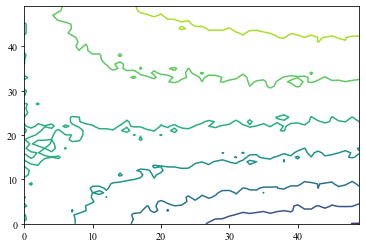

In [457]:
data=[[0.21817733017733018, 0.2287893247893248, 0.16499968499968498, 0.11469988269988265, 0.1260406980406981, 0.048968364968364965, 0.022102618102618113, 0.02066922866922866, -0.027041499041499058, -0.0415832455832456, -0.10351157551157553, -0.1417621417621417, -0.13077859077859083, -0.21418804618804627, -0.21932760332760332, -0.22912190512190506, -0.2626611586611587, -0.29004489804489797, -0.38855515655515654, -0.3793104553104554, -0.3827187827187825, -0.3981463221463221, -0.4299321939321942, -0.44277970677970685, -0.479095787095787, -0.4805306045306045, -0.47012145812145806, -0.5224580704580704, -0.5638592878592877, -0.5222322902322901, -0.5518168318168318, -0.6147601827601827, -0.5614132894132894, -0.6315731115731116, -0.6106509946509945, -0.6233703713703712, -0.647977475977476, -0.6278770718770718, -0.6824917304917304, -0.6912112392112394, -0.6717887997887997, -0.6569181089181088, -0.6834431034431033, -0.6938252138252137, -0.694128526128526, -0.7420154260154261, -0.7381957861957861, -0.7152952992952993, -0.7580274980274981, -0.7587505587505585], [0.2705207225207225, 0.20271969471969467, 0.17546471546471537, 0.13495968295968297, 0.17502964302964305, 0.04953256953256955, 0.005690489690489701, 0.03587819987819989, -0.044726492726492706, -0.07282851682851683, -0.0918043638043638, -0.1438355518355518, -0.10575744975744975, -0.1903049863049863, -0.22356863556863554, -0.18916605316605312, -0.25340805740805744, -0.28079920079920073, -0.3051285891285892, -0.32200645000645006, -0.3068900228900229, -0.3985324825324825, -0.34423637623637626, -0.42784374784374773, -0.4301851181851181, -0.4343826143826144, -0.49153076353076347, -0.4607947367947368, -0.5080570600570602, -0.5087798567798569, -0.5867795267795267, -0.5516978276978276, -0.530886914886915, -0.5710311910311909, -0.5497017097017096, -0.5549711429711431, -0.5632033072033072, -0.5901259461259465, -0.6142621822621822, -0.6251464451464451, -0.60796585996586, -0.6125587205587206, -0.637895485895486, -0.619899163899164, -0.6588390348390349, -0.6664878304878306, -0.6578542418542417, -0.6713494313494314, -0.6546315186315185, -0.6902907902907903], [0.2561242961242961, 0.21709527709527707, 0.16116746916746919, 0.11178002778002782, 0.13626694026694028, 0.047500499500499525, 0.0746128586128586, 0.008956604956604953, -0.025327885327885345, -0.04820788820788822, -0.013312405312405308, -0.11445709845709849, -0.12178491778491776, -0.13787614187614186, -0.18706318306318306, -0.18830543630543634, -0.27478753078753065, -0.26660000660000654, -0.31486106686106685, -0.3128125088125087, -0.3622362742362742, -0.30975764175764176, -0.32822450822450816, -0.3575685575685576, -0.3842729882729882, -0.410183126183126, -0.3556665676665676, -0.38760927960927966, -0.40667266667266655, -0.44838316038316045, -0.46696185496185505, -0.5116366756366756, -0.5328410928410929, -0.5149960669960671, -0.5467053667053666, -0.5153157593157593, -0.5209912009912009, -0.5714876714876715, -0.5352727992727995, -0.5386768306768308, -0.6021058941058942, -0.5648230928230928, -0.6033486873486874, -0.5525970245970248, -0.6238652878652879, -0.6173763893763895, -0.5606538566538565, -0.5961218601218601, -0.6207260967260967, -0.6126244206244207], [0.1922930642930643, 0.22489137289137293, 0.17504663504663506, 0.15584607584607582, 0.1075928755928756, 0.11479159879159881, 0.13505557505557503, -0.004530676530676508, 0.04584557784557784, 0.003020847020847011, -0.04775487575487575, -0.061542397542397535, -0.07489251889251886, -0.073001377001377, -0.14808648408648412, -0.1946676266676267, -0.20580248580248575, -0.23285968085968084, -0.29667503667503675, -0.19257555657555656, -0.3040194040194041, -0.24128277728277733, -0.3275957435957436, -0.36036448836448837, -0.3534195894195895, -0.38137785337785346, -0.35205750405750397, -0.4127965127965128, -0.4147899667899668, -0.3665840585840587, -0.43037840237840236, -0.4232279912279913, -0.4752198552198552, -0.46977039777039753, -0.46147136947136946, -0.4956981156981156, -0.4626698706698707, -0.4758888078888078, -0.4983404943404943, -0.48365341565341585, -0.537910857910858, -0.5231804351804352, -0.5105990825990827, -0.549973041973042, -0.5565438285438283, -0.5825936105936105, -0.5741280101280103, -0.5618111738111738, -0.5595211155211155, -0.5411757851757852], [0.2754207834207834, 0.203913275913276, 0.2063889623889624, 0.1699196179196179, 0.1568678768678768, 0.11364643764643768, 0.0373171933171933, 0.019163983163983146, 0.0565025125025125, -0.002174918174918184, -0.0585863745863746, -0.04252337452337454, -0.09394814194814192, -0.08494046494046494, -0.12483528483528482, -0.1705506145506146, -0.15774818574818572, -0.21631873231873233, -0.2527314127314127, -0.2322241962241962, -0.3012081492081492, -0.28058059658059664, -0.2527251727251728, -0.2570824250824251, -0.3304295824295824, -0.3217898377898378, -0.333973437973438, -0.340033156033156, -0.3005816765816766, -0.38275833475833465, -0.3723535203535204, -0.3880026760026759, -0.38979593379593375, -0.41283437283437285, -0.4197163677163678, -0.46425761625761625, -0.462909366909367, -0.4540832020832021, -0.4492683772683772, -0.48111968511968517, -0.522821922821923, -0.452033708033708, -0.47764558564558574, -0.5097385737385738, -0.44765659565659577, -0.5134356454356457, -0.49156983556983574, -0.4916143196143197, -0.49432127032127027, -0.5452998892998893], [0.23213886413886411, 0.18337260337260333, 0.23514883914883913, 0.21634176034176045, 0.1553786153786154, 0.11991377991377995, 0.07426017826017824, 0.07645003645003647, 0.014825630825630804, 0.025295833295833292, 0.017203529203529175, -0.0697092577092577, -0.07427586227586223, -0.10357489957489954, -0.12763606363606367, -0.09733074133074131, -0.16705237105237103, -0.16921374121374122, -0.1709318069318069, -0.22206305406305407, -0.26980192180192186, -0.22636667836667837, -0.20093046893046895, -0.2217350457350457, -0.2578747018747019, -0.2763827403827404, -0.2950946830946831, -0.2864308424308424, -0.29350022950022947, -0.27222963222963226, -0.3147631947631948, -0.3694748614748615, -0.32850212850212845, -0.34628588228588225, -0.3500568260568261, -0.3016821976821977, -0.34614233814233814, -0.4155441075441075, -0.355974187974188, -0.435153519153519, -0.43637719637719646, -0.4234788394788394, -0.38639348639348625, -0.3884061164061164, -0.43991567591567593, -0.4585801465801467, -0.46658594258594266, -0.43091252291252297, -0.4808663288663291, -0.4564214284214284], [0.25690086490086494, 0.21222981222981227, 0.2342924942924942, 0.18567901767901768, 0.18584791784791785, 0.11275003675003678, 0.10352915552915554, 0.07917229917229919, 0.0875135315135315, 0.07455803055803056, -0.01955839955839955, -0.04486341286341287, 0.0014879894879894777, -0.023965139965139964, -0.07573026373026372, -0.14141968541968541, -0.0918203238203238, -0.0861910581910582, -0.1645343965343965, -0.19754317754317752, -0.18588745788745786, -0.14951869751869756, -0.18411212811212807, -0.19669214869214868, -0.2739251139251139, -0.1947334227334227, -0.27540219540219546, -0.2373755613755614, -0.2633173073173073, -0.2805939645939646, -0.27698508098508107, -0.2863044823044823, -0.29256091656091654, -0.32017154017154015, -0.28699337899337896, -0.34178450978450986, -0.3813420693420693, -0.3510893310893311, -0.34401449601449596, -0.375017919017919, -0.3525974325974326, -0.41965097965097964, -0.3826550986550985, -0.41169062769062786, -0.37722130122130115, -0.3546952986952987, -0.38336948336948334, -0.42186571386571375, -0.3989878349878351, -0.38963299763299775], [0.17432839832839842, 0.21908436308436313, 0.1597747717747718, 0.18952842952842955, 0.19203970803970805, 0.18150993750993755, 0.1240981120981121, 0.08491687291687292, 0.017162201162201164, 0.05960530760530758, -0.001328977328977333, 0.02916476916476916, -0.01897800697800697, -0.013739821739821738, -0.04341093141093141, -0.046577938577938585, -0.04549674949674951, -0.09034811434811434, -0.078032586032586, -0.12313211113211107, -0.12857858057858057, -0.1814008454008454, -0.19894600294600293, -0.16581398181398185, -0.19075268275268278, -0.1995686955686955, -0.2171009651009651, -0.24691836691836694, -0.23297732897732903, -0.27852144252144245, -0.3087466167466168, -0.23485915885915876, -0.31695253695253695, -0.2574441294441295, -0.26624685824685823, -0.24915881715881724, -0.2736966936966937, -0.3209548289548289, -0.2957334077334078, -0.3718293838293837, -0.33757059757059765, -0.3166882606882607, -0.28159063759063757, -0.3223414423414424, -0.3785192225192225, -0.3520392040392041, -0.35138228738228733, -0.3693700893700894, -0.34274521874521874, -0.3300293460293461], [0.23654138054138055, 0.20991428991428995, 0.2283186003186003, 0.1693856893856894, 0.08332753132753137, 0.16384857184857188, 0.1307473187473187, 0.12739018339018338, 0.10994577794577796, 0.06962348162348161, -0.037507321507321514, -0.03580700380700378, 0.0155895035895036, -0.03278958878958878, -0.020561492561492572, -0.028476364476364473, -0.061970401970401975, -0.027972807972807965, -0.040874164874164884, -0.09492610692610692, -0.09855932655932655, -0.023138279138279136, -0.1412730092730093, -0.13696816096816097, -0.20695268695268695, -0.20036417636417633, -0.19131388731388732, -0.212995628995629, -0.19789756189756189, -0.22076092076092077, -0.19412166212166213, -0.21374199374199374, -0.2528158568158569, -0.24610864210864214, -0.23993567993567994, -0.26672040272040276, -0.27433965433965424, -0.2508583908583909, -0.2403542163542163, -0.29255512055512045, -0.30198625398625395, -0.2782113262113262, -0.341051645051645, -0.24998385398385395, -0.26899090099090095, -0.3558366198366198, -0.27346324546324546, -0.32858335658335647, -0.3587809307809309, -0.2992807552807552], [0.20462006462006468, 0.26623095823095827, 0.16670192270192274, 0.20436406836406834, 0.1888244728244728, 0.2164270924270925, 0.1484024204024204, 0.12395741195741194, 0.08556042156042155, 0.09237720837720836, 0.043664935664935664, 0.04326373926373928, 0.03496199896199895, -0.019253371253371274, -0.045264693264693276, -0.053583413583413585, -0.04887666087666087, -0.03292036492036491, -0.056570060570060574, -0.06004143604143606, -0.12428359628359628, -0.10250037050037052, -0.11339485739485737, -0.13402507402507402, -0.13726328926328923, -0.14515264915264914, -0.12194282594282597, -0.1297780777780778, -0.1661851061851062, -0.1934966174966175, -0.18374695574695576, -0.21255112455112457, -0.19950895950895958, -0.16051951651951646, -0.18195291795291796, -0.203012591012591, -0.1802848202848203, -0.2481188841188841, -0.22527364527364532, -0.21376298176298172, -0.20633523833523837, -0.2875938235938237, -0.27335463335463356, -0.24708225108225104, -0.2597647877647878, -0.26845288045288046, -0.21422530622530625, -0.22466634866634871, -0.3154417834417834, -0.1965760245760246], [0.23249208449208442, 0.19886463086463083, 0.22397112797112798, 0.19469187869187865, 0.2101885141885142, 0.183009783009783, 0.13232816432816433, 0.1298671538671539, 0.1359319239319239, 0.1362331122331122, 0.011516363516363516, 0.06127591327591326, 0.08684903084903085, 0.06253244653244654, 0.06715200715200709, 0.020797952797952792, 0.0015846015846015867, -0.017161517161517176, -0.015121623121623134, -0.007326067326067318, -0.03321688521688524, -0.02541973341973343, -0.054871554871554866, -0.11617576417576418, -0.09044550644550643, -0.09467122667122664, -0.15806763806763804, -0.12225612225612223, -0.11261372861372863, -0.14347834747834745, -0.10285385485385488, -0.18374165174165175, -0.1837422277422277, -0.14673865473865474, -0.1046006126006126, -0.20098680898680896, -0.2198820998820999, -0.23403191403191403, -0.18822660822660828, -0.17605463605463606, -0.1365490725490726, -0.2108460788460789, -0.19519587919587922, -0.2053384093384094, -0.20394209994209994, -0.22502696102696101, -0.2217991857991858, -0.20833847233847233, -0.19761445761445762, -0.2263481743481743], [0.26990347790347796, 0.2344179184179184, 0.24440363240363244, 0.2181913701913702, 0.19287238887238892, 0.18066531666531663, 0.18846828846828853, 0.10301442701442702, 0.0795016515016515, 0.04545430545430547, 0.10869532869532869, 0.14064976464976467, 0.0686730686730687, 0.06952000552000549, -0.02280837480837482, 0.04774174774174775, 0.06462184062184065, 0.027321459321459348, -0.05227622827622828, 0.017901341901341895, -0.03754272154272156, -0.01070333870333871, -0.04603185403185406, -0.05711804111804111, -0.04998366198366196, -0.07619213219213221, -0.04870023670023671, -0.095000087000087, -0.11011626211626209, -0.039278547278547286, -0.060446868446868446, -0.14929930129930133, -0.13263604863604864, -0.12508241308241314, -0.09853190653190656, -0.20153000153000158, -0.1397971517971518, -0.15209726009726016, -0.049199377199377205, -0.08151141351141353, -0.19578591978591972, -0.16710841110841113, -0.17400894600894606, -0.189089637089637, -0.1713156393156393, -0.17210929610929612, -0.1640525960525961, -0.19881187881187884, -0.21569186369186363, -0.16087150087150087], [0.28381338781338783, 0.23691700491700485, 0.16080991680991683, 0.21304499704499705, 0.14561539361539363, 0.18357662757662765, 0.1582980982980983, 0.16220730620730622, 0.11514601914601916, 0.17124599124599124, 0.13425432225432227, 0.11813578613578615, 0.06933788133788132, 0.0668886668886669, 0.02915586515586515, 0.01985410385410383, 0.008824148824148816, -0.00996039396039398, -0.02168900168900168, 0.04048979248979248, 0.028611580611580596, -0.06803219603219603, -0.037212073212073205, -0.025654105654105662, -0.02405910005910005, -0.07997279597279601, -0.018468954468954468, -0.12067298467298465, -0.05973649173649174, -0.07908367908367907, -0.0357811317811318, -0.07213869613869613, -0.10928564528564527, -0.03266853266853267, -0.11036365436365439, -0.0981834501834502, -0.1260946740946741, -0.017702333702333695, -0.15522865122865123, -0.10127867327867329, -0.15132543132543136, -0.11655232455232453, -0.17375676575676574, -0.11479687879687879, -0.1419330939330939, -0.1550717270717271, -0.07306495306495307, -0.16038666438666435, -0.1584414624414624, -0.1914132714132714], [0.24851114051114048, 0.21544411144411155, 0.24361628761628765, 0.23202348402348402, 0.22733090333090328, 0.22410713610713617, 0.14047472047472045, 0.18140979740979737, 0.1453019653019653, 0.12685047085047085, 0.19985585585585589, 0.1395770475770476, 0.14053060453060454, 0.10479974079974082, 0.08173953373953373, 0.05241433641433643, 0.038893046893046894, 0.020515388515388516, 0.08985401385401386, -0.026083706083706075, -0.0037347037347037434, 0.014547446547446555, 0.008946632946632942, 0.02658849858849858, 0.020893484893484904, -0.021284973284973304, -0.04632598632598634, -0.007030075030075041, -0.10357890757890759, -0.05973613173613172, -0.037711261711261705, -0.03593417993417993, -0.05654225654225653, -0.014662658662658656, -0.042233934233934234, -0.07609518409518409, -0.05037145437145437, -0.04970810570810569, -0.07714837714837716, -0.07277920877920876, -0.04229904629904632, -0.061933297933297944, -0.06425629625629625, -0.12414748014748017, -0.11271990471990471, -0.07174526374526374, -0.015796995796995804, -0.14098451698451694, -0.09319985719985718, -0.11209549609549609], [0.2311140751140751, 0.2885210285210286, 0.28045822045822055, 0.20758739158739162, 0.20545776145776148, 0.20914988914988916, 0.19112829512829513, 0.17225585225585222, 0.1421443301443301, 0.15324633324633327, 0.18598064998065003, 0.13543711543711542, 0.14887145287145287, 0.10848642048642047, 0.14458653658653658, 0.11957143157143157, 0.12538980538980538, 0.09669172869172867, 0.06508886908886907, 0.10809110409110406, 0.10289836289836285, 0.09806712206712205, 0.05870991470991475, 0.05646351246351247, 0.04626039426039426, 0.015451587451587449, 0.0026046746046746185, 0.012993336993337, -0.006199890199890204, -0.05054499854499854, 0.00465312465312465, 0.025323721323721318, -0.03761929361929363, 0.025779961779961776, -8.802008802008056e-05, -0.033999837999838, -0.01815334215334216, -0.038593166593166604, 0.002340662340662322, -0.0375200055200055, -0.015775935775935786, -0.07610453210453211, -0.1136925176925177, -0.015074571074571066, -0.07364484164484161, -0.059648615648615656, -0.07287129687129688, -0.08082830082830082, -0.08354959154959153, -0.11226031626031625], [0.2778924618924619, 0.23939319539319542, 0.2713394473394473, 0.26801344001343996, 0.25006933006933, 0.26634681834681834, 0.19839636639636635, 0.16888928488928492, 0.1503255663255663, 0.2021169941169941, 0.1543984063984064, 0.15733858933858938, 0.16757264357264356, 0.12656710256710255, 0.15107101907101908, 0.13056796656796657, 0.12380309180309179, 0.13028537828537828, 0.12501924501924505, 0.04435271635271636, 0.04776608376608379, 0.04176367776367778, 0.031336399336399326, 0.10042256842256843, 0.08967233367233367, 0.034282990282990276, 0.0024192384192384194, 0.05889991089991089, 0.05542660342660342, 0.07128261528261529, 0.010822102822102829, -0.0028776268776268734, 0.07253546453546451, -0.0639076839076839, -0.006076602076602074, 0.008752304752304768, 0.01282584082584082, -0.013225933225933222, -0.0027752547752547827, -0.018307758307758305, 0.009515109515109525, -0.0252114492114492, -0.0021678261678261574, -0.00010666810666809504, -0.011939411939411957, -0.011595083595083615, -0.03156149556149557, -0.010977994977994994, 0.012866964866964864, -0.02767263967263969], [0.24408017208017202, 0.23380673380673384, 0.2528763848763849, 0.22028270828270827, 0.22746860346860345, 0.21032387432387434, 0.20647286647286647, 0.22177612177612177, 0.20365147165147168, 0.22835361635361637, 0.17218963618963623, 0.1884660924660925, 0.1509116589116589, 0.16296213096213094, 0.16526340926340924, 0.1483588723588724, 0.0832891672891673, 0.14884129684129685, 0.08538049338049339, 0.17549694749694753, 0.11621038421038424, 0.08107972507972508, 0.006668934668934678, 0.10467972867972869, 0.12573317373317366, 0.12158191358191356, 0.06423058023058023, 0.038343458343458356, 0.07888978288978289, -0.0037541917541917525, 0.019942351942351933, 0.05608895608895609, -0.010090078090078095, 0.0547082347082347, 0.004484644484644495, 0.017202857202857202, 0.009999873999874016, 0.05224054024054023, 0.0006942366942366785, 0.037065049065049094, -0.03424895824895823, -0.016288204288204287, 0.022393246393246392, -0.030200550200550198, 0.02627360627360627, 0.00824582024582025, 0.000872172872172876, -0.05793633393633395, 0.016862992862992855, 0.006400458400458406], [0.2308277428277428, 0.3085455205455204, 0.2838615198615198, 0.24905264105264108, 0.3214686454686455, 0.18944424944424945, 0.25808653808653814, 0.19412365412365407, 0.2064823224823224, 0.1563696243696244, 0.1823975663975664, 0.2296654096654097, 0.17172528372528373, 0.13939789939789934, 0.18383751983751992, 0.14337998337998337, 0.1571805131805132, 0.15802481002481, 0.14575418575418578, 0.13837501837501837, 0.07744255744255744, 0.16407210807210812, 0.11671720471720472, 0.14925176925176925, 0.10573956973956979, 0.12909690909690907, 0.11471953871953873, 0.09134014334014334, 0.08259213459213458, 0.13393065793065795, 0.019994815994816006, 0.06038313638313638, 0.08280154680154678, 0.06297606297606297, 0.08960926160926161, 0.022688146688146678, 0.05392946992946993, 0.06465982065982066, 0.05534853134853134, 0.02507818907818907, 0.04770658770658771, -0.0036028476028476036, 0.03944694344694342, 0.050920046920046924, 0.0347953187953188, 0.030415074415074433, 0.04195823395823395, 0.06252975852975855, 0.025248445248445224, -0.00804324804324803], [0.2242013242013242, 0.2562767922767923, 0.22242705042705047, 0.2111701871701871, 0.2618332298332298, 0.23179854379854387, 0.21037563037563037, 0.20804099204099202, 0.22091647691647692, 0.21847106647106643, 0.1540819180819181, 0.1327169407169407, 0.2074747354747355, 0.1821279861279862, 0.20269409869409863, 0.18566417366417368, 0.17170401970401966, 0.16392334392334396, 0.16683602283602286, 0.11721309321309323, 0.17213419613419606, 0.13935462735462736, 0.11587633987633987, 0.19215597615597615, 0.2253749973749974, 0.1394996474996475, 0.2205381765381765, 0.1258867258867259, 0.15262932862932863, 0.15207023607023606, 0.15659826059826062, 0.08654192654192655, 0.1236631476631477, 0.13452858252858252, 0.06786882786882789, 0.10173162573162575, 0.10385789585789586, 0.06841690441690441, 0.05291869691869694, 0.07696350496350497, 0.1104201864201864, 0.11571785571785574, 0.03785118185118187, 0.10835556035556036, 0.06564398964398963, 0.12715985515985512, 0.1278203598203598, 0.0958300198300198, 0.08098076098076097, 0.052670524670524646], [0.24476005676005694, 0.30386451986451984, 0.25628854028854026, 0.2580768300768301, 0.24904046104046104, 0.23161436761436757, 0.20373146373146372, 0.28691281091281096, 0.2635269115269116, 0.20537864537864534, 0.22295196695196695, 0.23238230838230836, 0.21788066588066587, 0.200044652044652, 0.14814948414948415, 0.2177812097812098, 0.16351176751176752, 0.26808030408030414, 0.19001293001293001, 0.20425318825318828, 0.17913739113739113, 0.21408913008913008, 0.17826485826485822, 0.1748597708597708, 0.17317896517896514, 0.17270009270009268, 0.1677282477282477, 0.15589312789312793, 0.17024132624132624, 0.19182484782484782, 0.12783561183561185, 0.1765045285045285, 0.12627372627372627, 0.1221177861177861, 0.10820892020892021, 0.20857753657753647, 0.12672241872241874, 0.2056095376095376, 0.16314653514653513, 0.10191968991968992, 0.08410977610977616, 0.09677491277491279, 0.12508331308331308, 0.09842867042867046, 0.1097812577812578, 0.07834764634764636, 0.12163904563904565, 0.09756986556986554, 0.11625257625257626, 0.05597889197889199], [0.23733138933138934, 0.22092272892272893, 0.26558544158544156, 0.2546433266433266, 0.2705127665127665, 0.18645475845475842, 0.24650194250194243, 0.2504318384318384, 0.2880995520995521, 0.2202793482793483, 0.24256061056061054, 0.19871944271944272, 0.24719869919869908, 0.18979031779031777, 0.19189947589947592, 0.18144708144708144, 0.25166180366180363, 0.24404884004884006, 0.21487768687768685, 0.21474734274734278, 0.2570316650316649, 0.20224171024171028, 0.19463247863247868, 0.17066397866397867, 0.2041632601632601, 0.20424439224439228, 0.21659972459972454, 0.18852094452094453, 0.18619037419037424, 0.17224525624525625, 0.1636589116589116, 0.17275067275067277, 0.08824837624837624, 0.1816027456027456, 0.14940319740319744, 0.1934053334053334, 0.1655666735666735, 0.09480190680190682, 0.1608117648117648, 0.13237809637809644, 0.15197495597495594, 0.15443539043539042, 0.1342636822636823, 0.20995931395931391, 0.14324606324606323, 0.17407843807843806, 0.1633612753612754, 0.17782647382647385, 0.12474700074700076, 0.11699034899034899], [0.27191286791286795, 0.2061051981051981, 0.2257845937845939, 0.2768801288801289, 0.276054144054144, 0.2351098751098752, 0.29352074952074947, 0.3483188763188763, 0.2815241455241455, 0.22845445245445245, 0.24954362154362159, 0.23491861891861895, 0.22574630174630173, 0.2434726834726835, 0.23649237249237245, 0.29340694140694146, 0.19250005250005256, 0.2122102162102162, 0.22934312534312534, 0.2555014835014835, 0.18753367953367947, 0.223008127008127, 0.28766573966573966, 0.180990408990409, 0.2047552927552927, 0.18016658416658415, 0.19446566646566646, 0.2406233406233407, 0.23585884385884381, 0.22545374145374145, 0.23709195309195316, 0.17635194835194837, 0.20913226113226116, 0.19741078141078147, 0.20091622491622493, 0.17127637527637524, 0.18028184428184424, 0.24299341499341506, 0.2581364461364461, 0.18012211212211213, 0.1535187815187815, 0.1945983985983985, 0.15526283926283926, 0.17559486759486756, 0.15544550344550345, 0.18060033660033667, 0.16682845082845082, 0.16497814497814497, 0.1767922167922168, 0.15775034575034574], [0.23839979839979847, 0.2815279735279736, 0.2296971496971497, 0.24524074124074122, 0.2261180501180501, 0.2921920481920482, 0.22934284934284935, 0.26801635601635604, 0.2404824244824245, 0.24534197334197325, 0.2445655365655365, 0.2715981795981796, 0.2821584901584901, 0.28816177216177224, 0.23893304293304293, 0.23449177849177844, 0.26057013257013245, 0.25702937302937306, 0.3172245772245773, 0.2988214188214188, 0.2436176916176917, 0.2615338055338055, 0.22085544485544487, 0.29568250368250365, 0.3128368928368928, 0.2448611328611328, 0.21907575907575907, 0.25002200202200203, 0.25717595317595326, 0.24290125490125494, 0.20188596988596993, 0.24052248052248054, 0.21557615957615958, 0.266025974025974, 0.24417068817068815, 0.21743600543600544, 0.25940361140361146, 0.154990834990835, 0.25958418758418755, 0.22936336936336937, 0.23078516678516672, 0.22036482436482444, 0.24006582006581997, 0.16845619245619245, 0.21463726663726662, 0.21820043020043017, 0.18909765309765308, 0.15313112113112107, 0.1782487062487062, 0.1841212361212361], [0.2583899583899584, 0.29155339555339554, 0.26640859440859443, 0.30024915624915627, 0.2747684867684868, 0.3026301386301386, 0.30624388224388227, 0.23125033525033523, 0.2492693612693613, 0.25401461001461006, 0.2682077442077442, 0.25345545745545744, 0.2771113451113451, 0.2761922881922882, 0.30244869844869837, 0.23225070425070415, 0.2916998676998678, 0.27305825705825715, 0.2652376932376932, 0.2852125532125532, 0.2664509304509305, 0.3039681519681519, 0.29837258237258235, 0.272051192051192, 0.25480916680916676, 0.2832327072327072, 0.26694102294102284, 0.22309545109545106, 0.25651234051234056, 0.28713453513453513, 0.3118917118917119, 0.2088275088275088, 0.316013872013872, 0.21587032787032787, 0.31864469464469464, 0.2762307722307722, 0.2963118083118083, 0.27602887202887205, 0.2806964686964686, 0.2633978033978034, 0.25676038076038077, 0.32586963786963785, 0.21388438588438577, 0.23870470670470667, 0.2628980868980869, 0.2432897672897673, 0.24246001446001453, 0.2508938268938269, 0.22362609162609165, 0.25026706626706635], [0.25290186090186095, 0.27011172611172607, 0.25893213093213097, 0.32080049680049677, 0.2997030117030117, 0.3126271806271806, 0.29136080736080733, 0.23642610842610842, 0.2457083817083817, 0.33749444549444557, 0.30588674988674985, 0.31437896637896645, 0.3524505404505404, 0.25064365064365063, 0.2681538401538402, 0.2833384153384154, 0.32805060405060393, 0.2652665652665653, 0.2867720627720628, 0.3117377397377398, 0.3394711714711714, 0.3425153225153225, 0.33190980790980784, 0.25215542415542413, 0.3198110718110717, 0.2828210348210348, 0.3107977067977069, 0.3181271341271341, 0.32260340260340253, 0.27388516588516587, 0.29142306342306334, 0.3287188007188008, 0.26974949374949375, 0.294108078108078, 0.27483591483591485, 0.2942806022806022, 0.2911056511056512, 0.23998849198849206, 0.1897429657429657, 0.27417455817455816, 0.2930732570732571, 0.3156942996942997, 0.24341930741930742, 0.28673123873123874, 0.3454260334260334, 0.24281995481995486, 0.2801288441288441, 0.2884071484071483, 0.2445547965547966, 0.30794392394392395], [0.1978994218994219, 0.3042993402993403, 0.2712481992481993, 0.29976658776658777, 0.34485677685677674, 0.31274518874518875, 0.29722696522696523, 0.3159188919188919, 0.3215215535215535, 0.2861147981147981, 0.3276220356220356, 0.3307959187959188, 0.2914430674430674, 0.2940915540915541, 0.32045682845682844, 0.27654040854040857, 0.3671640551640551, 0.3357245637245637, 0.388028092028092, 0.2815770415770416, 0.3144918624918625, 0.26936634536634535, 0.3174351894351895, 0.28626887826887826, 0.3534998094998095, 0.3276932076932077, 0.3412546012546014, 0.34304713904713907, 0.28817523617523616, 0.30201959001959006, 0.31136494736494735, 0.3203240603240602, 0.26311767511767514, 0.329117417117417, 0.34367943167943166, 0.3612036372036372, 0.3100852900852901, 0.3544729024729026, 0.2946272346272346, 0.2963921363921364, 0.30087429687429695, 0.2855494415494415, 0.2902403662403663, 0.3118025998025998, 0.3071605151605152, 0.3104521424521424, 0.3032067992067991, 0.30787266787266787, 0.3914265554265554, 0.2573259053259054], [0.22324991524991517, 0.3328065808065807, 0.3088290328290329, 0.3095112215112215, 0.26706272706272705, 0.29451030651030646, 0.34651791451791447, 0.3043073083073083, 0.38301182301182296, 0.32228299028299034, 0.30700813900813906, 0.364936576936577, 0.33957998757998753, 0.3326241686241686, 0.30166935766935765, 0.36122970122970127, 0.31849762249762253, 0.32923544923544934, 0.3372949212949213, 0.34886419286419285, 0.3502794382794383, 0.29565633165633165, 0.35799946599946597, 0.3437216597216598, 0.3333637893637894, 0.29393111393111393, 0.36917440517440525, 0.2768042048042048, 0.33386907386907383, 0.33526378726378725, 0.3261520341520342, 0.3311864231864232, 0.36930036930036947, 0.37303792903792904, 0.3232941712941714, 0.27005421005421004, 0.36287459087459084, 0.3113189873189874, 0.3074040434040434, 0.3147593427593428, 0.33512449112449105, 0.3927486327486327, 0.35705757305757296, 0.3462357102357102, 0.35892848292848295, 0.35421654621654625, 0.30603861003861005, 0.3479733239733239, 0.2865866265866267, 0.36220557820557825], [0.2254938934938936, 0.2838428238428238, 0.23835088635088644, 0.3181199701199702, 0.2972215772215772, 0.29065031065031066, 0.3061179181179182, 0.3189275109275109, 0.33100403500403497, 0.3571720531720531, 0.3207816927816927, 0.3413779613779614, 0.37921468321468316, 0.3488082608082608, 0.32819621219621214, 0.3555153795153795, 0.36085358485358476, 0.3893364893364893, 0.3335968295968295, 0.34700201900201894, 0.3974412494412495, 0.3438945918945919, 0.3798721878721877, 0.38126164526164524, 0.35217239217239216, 0.34800882000881994, 0.338048834048834, 0.4072938712938713, 0.3684171564171564, 0.38600883800883806, 0.3611851091851092, 0.39919523119523115, 0.37751582951582946, 0.35266786066786077, 0.40401669201669205, 0.3814307254307254, 0.3432894072894072, 0.41727647727647726, 0.37746906546906556, 0.362070554070554, 0.3937190497190498, 0.39196032796032804, 0.3762545682545684, 0.3629464829464831, 0.38999360999361, 0.3133344253344254, 0.3404637404637405, 0.3423020823020823, 0.30372200772200775, 0.36225968625968613], [0.38352299952299956, 0.26479039279039274, 0.2937167817167817, 0.3280896520896522, 0.3234737034737034, 0.33585494385494397, 0.3170040170040171, 0.37918848718848724, 0.3767873687873689, 0.33798133398133395, 0.33227770427770426, 0.3342449382449381, 0.377148041148041, 0.40790135990136, 0.35545919545919547, 0.36923128523128523, 0.3379590259590259, 0.3464345864345864, 0.3868693108693108, 0.38606943806943805, 0.40035335235335234, 0.37422846222846223, 0.4189859629859631, 0.393907317907318, 0.3594892554892555, 0.45096763896763903, 0.42047492447492457, 0.38641811041811036, 0.3956641556641555, 0.3808776688776689, 0.4325028725028726, 0.4033907113907115, 0.33648030048030053, 0.35472522672522677, 0.37294598494598497, 0.4131198411198412, 0.36649423849423846, 0.4262489822489822, 0.3711799551799552, 0.38268285468285473, 0.40205739005739005, 0.41618457218457217, 0.4167361287361287, 0.3880873000873, 0.4036918396918398, 0.3413401373401373, 0.3839129999129999, 0.3877023997023997, 0.38573208173208173, 0.39302159702159706], [0.2428175668175669, 0.31857747057747055, 0.3060205500205501, 0.3184905544905545, 0.31621733221733217, 0.2888271488271488, 0.31440242640242644, 0.3336980136980137, 0.381108405108405, 0.3684539724539725, 0.40732855132855134, 0.29881207081207073, 0.3890377970377971, 0.38039195639195633, 0.3573836013836014, 0.3317655917655917, 0.39511288711288717, 0.3973689013689014, 0.42993263793263803, 0.43676956076956086, 0.3910946350946352, 0.39954435954435963, 0.38920624120624125, 0.36372270372270366, 0.4081347961347961, 0.403976731976732, 0.4336200856200856, 0.4322328962328962, 0.38990360990360995, 0.45615256815256827, 0.44518491718491715, 0.42381206781206787, 0.3976081336081336, 0.3987648867648868, 0.46371852771852784, 0.43768686568686566, 0.4035360795360795, 0.38860474060474054, 0.40044691644691643, 0.3969735849735849, 0.4471412071412071, 0.4277020637020638, 0.390139338139338, 0.4165364725364725, 0.41209654009654006, 0.40837874437874444, 0.4585948585948587, 0.4383850743850744, 0.3835290235290237, 0.39142705942705946], [0.22935085335085337, 0.2947055347055347, 0.28889860889860886, 0.29657199257199257, 0.3536414576414576, 0.30448481248481246, 0.3422352902352902, 0.39065105465105454, 0.36215552615552626, 0.37252064452064465, 0.40505056505056514, 0.3943056703056702, 0.3995078915078914, 0.385034521034521, 0.38815049215049213, 0.4594900954900955, 0.4167295767295768, 0.4069084189084189, 0.3333999213999215, 0.3688878688878689, 0.40959822159822157, 0.427076779076779, 0.4255875775875775, 0.4666092826092825, 0.4577578457578456, 0.44347768747768745, 0.4131862611862611, 0.41995495195495186, 0.4646927846927846, 0.4457476697476698, 0.43744805344805354, 0.48734122334122343, 0.3998299238299239, 0.4537675057675057, 0.43523936723936724, 0.44204849804849816, 0.44817298017298013, 0.43991470391470394, 0.46377757977757966, 0.4595403635403635, 0.38385601185601187, 0.4396936996936997, 0.3947450267450268, 0.4183204303204303, 0.42854669654669647, 0.45405908205908213, 0.4263203343203342, 0.403987027987028, 0.459219783219783, 0.43469090669090665], [0.323044439044439, 0.26653244653244657, 0.29275862875862874, 0.2975763935763936, 0.3496083256083257, 0.2901909621909621, 0.3478620358620359, 0.4033604113604114, 0.36667485067485067, 0.35029878229878225, 0.4244485004485004, 0.38807082407082405, 0.47242326442326427, 0.3834379434379435, 0.4330082410082411, 0.4478384558384558, 0.44716106716106707, 0.4257685497685499, 0.4821976821976822, 0.3867753267753268, 0.43718122118122116, 0.4348843228843229, 0.3982390342390342, 0.4450916050916053, 0.4300065460065461, 0.469082521082521, 0.4598607518607518, 0.4325281205281207, 0.4578991578991579, 0.4255045735045735, 0.4382032382032382, 0.49556454356454355, 0.4563002163002162, 0.4997677637677638, 0.4695713655713656, 0.45589586389586395, 0.5364155484155483, 0.4707606507606507, 0.4641644361644361, 0.45404011004011, 0.5240075720075722, 0.4495332055332055, 0.4423848463848464, 0.4473197193197193, 0.49215037215037183, 0.46759849159849165, 0.4380472620472621, 0.4753736593736593, 0.47892765492765504, 0.4434341634341635], [0.27121810321810325, 0.2782151182151182, 0.325146829146829, 0.2699276819276819, 0.3095170775170775, 0.38263781863781865, 0.2969879969879971, 0.37515302715302706, 0.39994898794898803, 0.3882487842487843, 0.42103425703425706, 0.4166990846990847, 0.4356458676458676, 0.4036892356892357, 0.43695296895296903, 0.42630641430641436, 0.4517167757167759, 0.4840220560220561, 0.49623737223737235, 0.4529438249438248, 0.41886281886281884, 0.4962778842778844, 0.5216163896163895, 0.4772787452787451, 0.48039332439332444, 0.44830176430176427, 0.49903558303558304, 0.4932039132039135, 0.4773704973704972, 0.5103945783945784, 0.46589777789777786, 0.44432414432414435, 0.4504886704886706, 0.5173995613995614, 0.49204748404748405, 0.47062239862239863, 0.5546524706524708, 0.48942639342639355, 0.4840751800751802, 0.5156348756348756, 0.5358878118878119, 0.4901638061638061, 0.510974274974275, 0.48699931899931903, 0.48128779328779325, 0.481041349041349, 0.47250946050946047, 0.4986115626115626, 0.4858452658452659, 0.46483276483276476], [0.22715792315792319, 0.2735133935133935, 0.3108230988230989, 0.3195549915549915, 0.3636337356337356, 0.3545513705513705, 0.37008488208488205, 0.37301208101208094, 0.3874029274029274, 0.4656097176097176, 0.42125530925530913, 0.45132024732024734, 0.4656361896361896, 0.47192454392454386, 0.49109965109965104, 0.4782468822468824, 0.5149613509613511, 0.4683997323997325, 0.4896617736617737, 0.5195697395697395, 0.45315915315915317, 0.47593467193467204, 0.5087070887070887, 0.5182365622365621, 0.4934119214119215, 0.44836337236337237, 0.5294609894609895, 0.45714978114978116, 0.4668657108657109, 0.5026440226440226, 0.5526517086517088, 0.5272039312039313, 0.4360977400977402, 0.5487210807210808, 0.5306760986760987, 0.534937698937699, 0.5086772446772446, 0.5460702300702301, 0.48982247782247784, 0.4728244608244611, 0.49841320241320247, 0.4794512514512513, 0.5183061383061381, 0.5214989694989697, 0.49315767715767717, 0.5426165786165784, 0.5475806595806597, 0.5344476664476664, 0.52985824985825, 0.5336632016632017], [0.2877141837141838, 0.31670527670527665, 0.35203043203043205, 0.34747635547635547, 0.39617229617229616, 0.4075015555015555, 0.3845411645411645, 0.4004188484188484, 0.45759980559980545, 0.4227294627294629, 0.4253459693459694, 0.4692738612738614, 0.4696788616788615, 0.432817056817057, 0.44222414222414214, 0.47577142377142395, 0.4531677931677932, 0.5206004326004325, 0.5320978720978721, 0.47962192762192785, 0.522091734091734, 0.5232873432873435, 0.5172230532230534, 0.5542749862749863, 0.4627905547905547, 0.5382437622437622, 0.4890734490734491, 0.5418113538113536, 0.5409672729672731, 0.5364273324273324, 0.5513328353328353, 0.538977046977047, 0.523871191871192, 0.5746891906891907, 0.5482717162717163, 0.534043038043038, 0.5722488082488084, 0.5247034767034766, 0.5982957102957104, 0.5436483516483517, 0.5067687627687627, 0.5551400791400791, 0.4870782670782671, 0.5575417255417255, 0.5522811122811122, 0.53001251001251, 0.5586618666618667, 0.5123841323841324, 0.5305677025677025, 0.5541440781440782], [0.2952353592353592, 0.2990909030909031, 0.2987575187575187, 0.304014412014412, 0.38662652662652663, 0.3566143286143286, 0.4586258906258906, 0.4451674811674813, 0.4397376917376918, 0.3923415563415563, 0.4723718443718443, 0.45260888060888077, 0.4573282693282693, 0.5389373029373029, 0.4832220032220033, 0.5218118098118099, 0.530990030990031, 0.49609427209427226, 0.5173462573462573, 0.5228675708675709, 0.5243851523851525, 0.5043809883809882, 0.48645719445719443, 0.5336105576105576, 0.4988975588975589, 0.5088504168504168, 0.5917534237534237, 0.5726508566508568, 0.5763105963105964, 0.565117105117105, 0.5737381297381298, 0.5942840942840942, 0.5388518148518149, 0.585026277026277, 0.6021998301998303, 0.5444591204591206, 0.5556029316029317, 0.5263241143241144, 0.5821103941103941, 0.5836145476145475, 0.5565740805740808, 0.6050798570798569, 0.5781113301113303, 0.5730667050667052, 0.5911609951609951, 0.6114726474726476, 0.5810431610431611, 0.6014541014541014, 0.5781267261267262, 0.5846495006495007], [0.2485163485163485, 0.2954338874338875, 0.36796747996747997, 0.35293366093366096, 0.37852698652698646, 0.3361603921603922, 0.42173343773343774, 0.4056333816333816, 0.4596904956904957, 0.4516574836574836, 0.45829569829569833, 0.47636667236667246, 0.5046192246192246, 0.5101191301191301, 0.4698865458865458, 0.529155169155169, 0.5230722310722311, 0.5072872592872593, 0.5383540903540903, 0.5682218442218441, 0.5415171975171975, 0.5036563196563196, 0.547964707964708, 0.5818159018159019, 0.5715117675117676, 0.6025426945426946, 0.5344293904293905, 0.5925572565572566, 0.6012676812676813, 0.5500204660204661, 0.605184017184017, 0.5808751008751011, 0.6152368712368711, 0.5837298077298076, 0.6097608577608578, 0.5574391974391972, 0.5607137607137609, 0.610027786027786, 0.5998405918405918, 0.5794107994107993, 0.5913146913146914, 0.6049846729846731, 0.6256149256149256, 0.6065382425382425, 0.5660525420525422, 0.6035206595206596, 0.5919651039651039, 0.5860746940746939, 0.6000633120633121, 0.5828269748269748], [0.24803472803472806, 0.2977035817035817, 0.3364496044496044, 0.3433636633636633, 0.41005669405669404, 0.40047162447162443, 0.4251886971886973, 0.4411355971355971, 0.46069495669495664, 0.47638584838584835, 0.47318094518094533, 0.49538928338928334, 0.5128823608823608, 0.5162970962970963, 0.531812691812692, 0.5245730845730846, 0.5266095466095467, 0.5385096945096945, 0.5437824277824278, 0.5692548292548291, 0.5946018306018305, 0.6035247755247756, 0.5498356538356539, 0.6049497889497888, 0.5884236604236602, 0.5629898989898989, 0.5866241626241625, 0.5773695733695732, 0.5748599388599389, 0.5757027957027958, 0.6105229185229185, 0.6057304137304137, 0.5807850167850167, 0.6240556200556201, 0.6122652842652843, 0.6313132393132392, 0.6210682170682169, 0.6342525702525702, 0.599925311925312, 0.6181658941658944, 0.6333750093750092, 0.5987944187944186, 0.6145096105096104, 0.5931331611331611, 0.613868533868534, 0.6157032517032517, 0.5653775533775534, 0.6477891117891118, 0.6105207945207946, 0.6339107499107498], [0.22315519915519916, 0.33421588621588627, 0.3701510141510142, 0.3698245778245779, 0.3982741822741824, 0.4158124398124398, 0.45351573351573354, 0.4745117105117104, 0.4933742773742775, 0.4944807024807026, 0.4864654024654024, 0.4915344595344595, 0.5386756906756905, 0.5581727221727221, 0.4813848493848493, 0.5565953325953327, 0.6063206103206104, 0.5732080652080653, 0.5466184386184386, 0.5986517506517506, 0.5800525240525238, 0.6116950556950557, 0.6246044766044766, 0.6281554481554482, 0.6353786273786274, 0.633148365148365, 0.6273549873549873, 0.5890974250974251, 0.6457527697527699, 0.5952434352434354, 0.6333854853854853, 0.6666231906231906, 0.6291584811584812, 0.6331111291111294, 0.6310218070218071, 0.6517966477966478, 0.661102321102321, 0.6604747444747446, 0.6706947826947829, 0.6386368346368347, 0.6533125733125733, 0.6411963651963652, 0.6534479214479216, 0.6424411744411744, 0.6578830778830778, 0.6362774882774884, 0.6894015534015535, 0.6793112593112592, 0.6459079899079899, 0.6335307095307094], [0.26842511242511247, 0.3133054213054213, 0.3333604413604414, 0.417984813984814, 0.3484195564195564, 0.41369687369687375, 0.40872793272793284, 0.4574206094206095, 0.49717861717861705, 0.48159398559398564, 0.5392633552633553, 0.5197886197886197, 0.5536371496371497, 0.5501633021633023, 0.544100908100908, 0.5847551007551006, 0.5316791916791918, 0.6343361743361744, 0.6402596082596084, 0.6014236454236455, 0.6287547647547651, 0.6071736071736072, 0.624884244884245, 0.647889203889204, 0.635143367143367, 0.5655860295860294, 0.6017067137067138, 0.6184759384759382, 0.6104613584613584, 0.6600679440679439, 0.5966655206655206, 0.637970725970726, 0.6480385920385923, 0.6639762999763001, 0.6597809277809278, 0.6281175041175042, 0.6602118002118001, 0.6654485214485216, 0.6623638463638463, 0.6571786051786052, 0.6781324981324981, 0.6746009426009425, 0.6678337998337998, 0.6774191094191095, 0.6927282567282567, 0.6751656031656034, 0.6502618462618464, 0.6784951024951024, 0.6853799893799897, 0.6447697407697408], [0.32149979749979746, 0.34199621399621405, 0.2841121401121401, 0.39005963405963406, 0.3993841593841595, 0.44374420774420764, 0.3807470487470488, 0.4604948924948925, 0.5331614091614092, 0.4810284730284731, 0.5677223797223797, 0.5414795654795654, 0.549013797013797, 0.5985712545712545, 0.5700015540015542, 0.572974244974245, 0.6026954786954788, 0.5711703311703311, 0.6210426930426929, 0.6345896025896026, 0.6044678204678204, 0.6276813876813876, 0.6233210753210753, 0.6217735777735777, 0.6328353688353688, 0.6222398382398382, 0.6830883470883472, 0.6515500595500596, 0.6262227262227263, 0.6889842289842287, 0.6576737136737137, 0.6532229572229575, 0.6805027405027404, 0.6486312486312484, 0.7235640875640875, 0.6658301818301819, 0.6925766005766008, 0.6845775965775964, 0.6801523881523881, 0.6808809928809927, 0.6850623730623732, 0.6875476595476595, 0.7115982875982876, 0.698100314100314, 0.7086759846759846, 0.6850857730857731, 0.7241044961044959, 0.6944290064290066, 0.6838440358440357, 0.6703792663792665], [0.282013014013014, 0.3359900039900039, 0.36276621876621884, 0.3686434286434286, 0.382932874932875, 0.40858609258609263, 0.4982466782466782, 0.47724100524100516, 0.5032555552555552, 0.5197325797325798, 0.5245894165894166, 0.590981114981115, 0.5746888906888907, 0.5984811584811585, 0.6197675837675838, 0.5828689988689988, 0.6127665607665607, 0.6337531417531418, 0.6186647586647585, 0.6138529338529339, 0.6495931575931577, 0.6615442815442817, 0.6416677616677617, 0.671172131172131, 0.642914346914347, 0.6489923529923531, 0.6779437019437019, 0.6693267693267694, 0.6517654477654476, 0.7226159426159426, 0.7068875628875629, 0.6835517515517517, 0.662957642957643, 0.667050019050019, 0.6864620784620783, 0.6931973251973251, 0.7311263391263392, 0.6967613047613049, 0.7304657624657624, 0.6886683766683767, 0.7143952863952865, 0.7016657096657097, 0.7185315825315827, 0.753003693003693, 0.7121893361893361, 0.7442176202176202, 0.7242055002055003, 0.7489373209373209, 0.7203418323418324, 0.6966197766197767], [0.2847575487575488, 0.30791382791382793, 0.3752157512157512, 0.42354498354498343, 0.41087340287340285, 0.44641075441075423, 0.46548082548082553, 0.4636193356193355, 0.534043674043674, 0.5279899439899439, 0.5686648486648485, 0.5446231006231006, 0.5651029091029092, 0.6062345582345583, 0.6056846096846097, 0.6462286902286903, 0.6614842454842454, 0.6549141669141672, 0.6543826383826385, 0.6665171825171827, 0.6657154377154377, 0.6703078423078422, 0.6577806697806698, 0.6951488391488393, 0.7254657414657413, 0.6888641808641808, 0.7036574836574837, 0.7136178776178775, 0.7106165666165666, 0.7217983217983218, 0.7303341343341343, 0.6895896295896297, 0.7413844893844894, 0.7271708351708351, 0.7465475305475303, 0.7019216099216099, 0.7203620043620043, 0.7490473730473729, 0.7545958425958426, 0.7283489363489363, 0.728850740850741, 0.7499880779880782, 0.7377695217695218, 0.7509572229572231, 0.7495836535836536, 0.738043974043974, 0.7567511887511886, 0.7518667278667279, 0.7324845244845247, 0.7384513144513143], [0.22573268173268174, 0.31629745629745615, 0.3400363120363122, 0.3387909627909628, 0.4088072528072528, 0.47814952614952616, 0.4696244896244896, 0.5446796446796446, 0.5374678774678775, 0.5018145818145816, 0.6082819042819042, 0.5813662133662134, 0.5704356304356305, 0.5935927615927615, 0.6382162822162825, 0.6419038739038737, 0.6438649518649519, 0.6472918792918793, 0.6711274671274672, 0.6404912924912924, 0.6682986442986443, 0.6915563715563715, 0.6975806775806774, 0.6855643815643816, 0.7231691791691792, 0.7004477084477084, 0.7114364674364673, 0.7293306213306214, 0.7184260784260783, 0.7354425274425272, 0.7341523941523941, 0.7436431796431797, 0.7580669300669299, 0.7370658410658413, 0.7387593427593426, 0.7438942798942799, 0.7526852006852007, 0.752694380694381, 0.7525323325323326, 0.7533283773283773, 0.7665063105063105, 0.765979401979402, 0.7608400248400251, 0.7581369981369982, 0.7748482148482148, 0.7731660171660173, 0.7583741903741904, 0.8002064602064604, 0.7965798885798886, 0.7743721023721025], [0.20980087780087778, 0.3574614934614935, 0.3646764766764767, 0.37728485328485334, 0.4889844689844689, 0.4497629457629458, 0.41304268104268105, 0.5124816804816804, 0.5247338247338248, 0.5504691584691584, 0.575101163101163, 0.5709097509097508, 0.5952151512151512, 0.6085899085899085, 0.6280879000879004, 0.6511114231114232, 0.6758160158160159, 0.6752678912678912, 0.6884708924708928, 0.6879529359529359, 0.6938535698535698, 0.7225688785688786, 0.7167935847935848, 0.7716112836112836, 0.7358454758454757, 0.7282971562971563, 0.7190890670890673, 0.7661187101187102, 0.7650646770646772, 0.7608113808113811, 0.744884124884125, 0.774953214953215, 0.7896310896310897, 0.7618469338469338, 0.7574614334614335, 0.7695768255768254, 0.7903122583122584, 0.7790167790167791, 0.7929109329109332, 0.7765074205074205, 0.7753352713352711, 0.7939283779283779, 0.784893112893113, 0.7841751521751522, 0.7871712191712192, 0.7878330078330079, 0.7946946866946867, 0.8047445767445766, 0.815088659088659, 0.790806322806323], [0.2286450966450967, 0.3115362595362595, 0.3161785121785123, 0.3722144282144282, 0.4752664392664393, 0.43666795666795666, 0.46468726468726457, 0.507912171912172, 0.5102596142596142, 0.5433280233280233, 0.6340956220956222, 0.6228636708636708, 0.606946650946651, 0.6979295779295779, 0.6429680589680589, 0.6797848997849001, 0.7003616323616323, 0.6880322800322802, 0.6780893580893581, 0.686904494904495, 0.7248955248955248, 0.7426450786450789, 0.7292930972930972, 0.727905883905884, 0.729121821121821, 0.7717279357279355, 0.7829162309162309, 0.752157068157068, 0.7753815313815318, 0.787013287013287, 0.7840430680430682, 0.7553824433824431, 0.8122542682542684, 0.7804494724494725, 0.7938500418500419, 0.8083897003897003, 0.7854755694755695, 0.8073396753396751, 0.810113862113862, 0.793078849078849, 0.7922700122700121, 0.7957175797175796, 0.7884901884901886, 0.8130222690222693, 0.8076238476238474, 0.8117868197868197, 0.8151915351915352, 0.8012156852156852, 0.8102986502986504, 0.8055337935337934], [0.2894115734115734, 0.32633738633738635, 0.35062269862269857, 0.42628175428175435, 0.4394932154932155, 0.5171322491322492, 0.5455237735237735, 0.5025427545427545, 0.5497331497331498, 0.5844261804261804, 0.5922137442137442, 0.6479849879849878, 0.6613874173874174, 0.6459356139356138, 0.6797394317394316, 0.687021795021795, 0.6784658464658466, 0.7421346821346821, 0.7197641997641998, 0.7139542859542858, 0.7422656742656741, 0.7466459666459666, 0.748776388776389, 0.7734338574338576, 0.7561526881526883, 0.7858775698775701, 0.7819426459426461, 0.7785034665034665, 0.796915408915409, 0.7711315831315829, 0.8025064665064663, 0.8081482841482841, 0.8132567732567728, 0.8245799605799605, 0.8317510237510239, 0.8384935784935785, 0.8138236658236659, 0.8187919107919107, 0.8095215055215057, 0.8111066831066831, 0.8258646938646937, 0.8201566361566363, 0.8327921207921208, 0.8456499176499175, 0.8417935577935577, 0.8233617673617675, 0.8483308283308281, 0.8365152685152687, 0.843195063195063, 0.8437657357657357], [0.2876936996936996, 0.29778803778803786, 0.3645841605841605, 0.37366534966534964, 0.4913798153798154, 0.5434609594609597, 0.525915117915118, 0.5464673704673705, 0.5692320412320413, 0.6132096732096732, 0.6370397050397052, 0.6315839235839237, 0.624726396726397, 0.6450528570528571, 0.6842532962532962, 0.6714692394692394, 0.7266949986949985, 0.7333733053733051, 0.7433789153789155, 0.767920931920932, 0.7407079767079767, 0.7862911502911502, 0.7655585015585014, 0.7993813033813034, 0.7799518559518559, 0.7931755451755452, 0.8117234957234957, 0.8126946926946926, 0.8104354264354265, 0.8011700251700252, 0.8241351201351201, 0.8316794796794795, 0.8165407325407326, 0.8302361902361902, 0.8458528738528741, 0.8462397782397784, 0.8477014037014037, 0.8411076131076132, 0.8624524544524543, 0.8344043464043462, 0.8728489408489412, 0.8627712587712589, 0.878925146925147, 0.8627070707070709, 0.8656788016788017, 0.8666524106524109, 0.8685901605901606, 0.8698755058755056, 0.877130185130185, 0.8720770520770518], [0.2864811464811464, 0.3387787467787467, 0.3833248673248673, 0.42833378033378033, 0.4420368700368699, 0.4853269373269373, 0.5273934953934954, 0.5620630660630662, 0.596043176043176, 0.5821855501855502, 0.6306953706953705, 0.688155784155784, 0.6670996030996029, 0.6752651072651072, 0.6923464523464524, 0.7389707109707109, 0.7301912981912984, 0.7636906876906876, 0.7754020634020633, 0.7815877935877937, 0.7709408549408551, 0.7714665274665276, 0.817313749313749, 0.7787329427329428, 0.8044432084432084, 0.8214564654564656, 0.815152403152403, 0.8175959775959776, 0.8473595233595234, 0.860877212877213, 0.8505816225816225, 0.8430398790398791, 0.8494233094233096, 0.8550513630513628, 0.8455661095661097, 0.8683986883986887, 0.8754802794802793, 0.8686397206397206, 0.8776897816897818, 0.888988908988909, 0.8695642255642256, 0.8806163566163566, 0.8953678753678753, 0.8929678009678012, 0.8728696288696287, 0.8763970083970085, 0.8894202734202736, 0.8968718848718847, 0.8914396954396954, 0.8973594933594929], [0.29719996519996517, 0.3160956640956641, 0.35136149136149125, 0.4342702702702703, 0.4722189642189642, 0.4808137688137689, 0.5150688470688469, 0.5744289944289943, 0.6050954450954452, 0.5945890025890028, 0.6612180612180611, 0.6747639147639147, 0.7130300930300931, 0.7076527436527437, 0.7359957999958002, 0.7238861198861201, 0.7390912510912508, 0.771808443808444, 0.7537034737034738, 0.8032238272238273, 0.771039951039951, 0.7995324915324915, 0.8142480342480342, 0.7883386643386644, 0.8236653556653555, 0.8266044466044465, 0.8214389814389813, 0.8466546066546067, 0.8374634494634494, 0.8562876762876762, 0.8672854832854835, 0.8759852639852641, 0.8596615876615875, 0.8745757305757303, 0.866698286698287, 0.8736558216558215, 0.8783466023466028, 0.8877327357327356, 0.891966663966664, 0.8949407229407227, 0.8943335343335346, 0.8939099819099819, 0.9075833475833476, 0.9098087498087498, 0.9068617868617869, 0.9185134985134986, 0.922878454878455, 0.9111707391707397, 0.9091462771462769, 0.91401857001857]]

plt.contour(data)

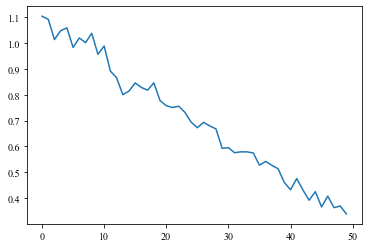

In [463]:
tdata=np.transpose(data)
plt.plot(np.subtract(1,tdata[10]))
plt.show()

In [461]:
len(tdata)

50

In [711]:
correlateResources(np.array([[3,1],[2,3],[1,2]]))

(-0.4999999999999999,
 [100.0, 66.66666666666667, 33.333333333333336],
 [33.333333333333336, 100.0, 66.66666666666667])